# 1 Importing packages and the functions.py

In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import getpass
import glob
import seaborn as sns
import functions
import lfp_pre_processing_functions
import power_functions
import coherence_functions
import spectrogram_plotting_functions
import plotting_styles
import scipy.stats
import mne_connectivity
import mne
importlib.reload(functions) #loads our custom made functions.py file
importlib.reload(spectrogram_plotting_functions)
importlib.reload(plotting_styles)

linestyle = plotting_styles.linestyles
colors = plotting_styles.colors

# 2 - Loading the data files

This code fetches the current 'user' by using getpass. Then it sets the basepath, loads the files and specifies the savepath. Note that the basepath, files and savepath need to be changed depending on where you have kept the files and where you want the results to be stored. In this case, I have set it up to be in a particular folder in my Dropbox account, which is stored locally.

In [2]:
#Fetch the current user
user= (getpass.getuser())
print("Hello", user)

if user == 'CPLab':
    base='D:\\Dropbox\\CPLab'
else:
    base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
#Set the basepath, savepath and load the data files
files = glob.glob(base+'\\all_data_mat_250825\\*.mat')
savepath = base+'\\results\\'
print("Base path:", base)
print("Save path:", savepath)
print(files)


all_bands_dict = {'total':[1,100], 'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}


Hello sinha
Base path: C:\Users\sinha\Dropbox\CPLab
Save path: C:\Users\sinha\Dropbox\CPLab\results\
['C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230529_dk1_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230529_dk3_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230529_dk5_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230529_dk6_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\

# Extracting LFP data

In [ ]:

keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'} #specifying the map of keyboard annotations to their meanings.
all_bands={'total':[1,100],'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}
importlib.reload(lfp_pre_processing_functions) #Reloading the lfp_pre_processing_functions module to ensure we have the latest version
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat_filtered\\20230615_dk6_BW_context_day1.mat', f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230626_dk6_BW_nocontext_day1.mat'] #This is just for testing purposes
time_window=1
fs=2000
#Initializing a few empty things to store data
events_codes_all = {}
compiled_data_all_epochs = []
compiled_data_list=[]
compiled_shuffled_data_list = []
baseline_lfp_all = []
normalization_comparison_all = []
for file in files: #Looping through data files
    
    ## Get the date, mouse_id and task from the file name
    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)
    date, mouse_id, task=lfp_pre_processing_functions.exp_params(base_name) #Using a custom made function [see functions.py]
    print(date, mouse_id, task)
    if task == 'nocontextday2' or task == 'nocontextos2':
        task = 'nocontext'
    if task =='nocontext':
        continue
    f=h5py.File(file, 'r')  ## Open the data file
    channels = list(f.keys()) ## Extract channels list from the data file
    print(channels)
    if not any("AON" in channel or "vHp" in channel for channel in channels):
        continue
    events,reference_electrode=lfp_pre_processing_functions.get_keyboard_and_ref_channels(f,channels)

    events_codes=np.array(events['codes'][0]) #saving the keyboard annotations of the events (door open, door close etc.)
    events_times=np.array(events['times'][0]) #saving when the events happened
    events_codes_all[base_name] = events_codes #saving the codes in a dictionary to be analyzed later for events other than the ones in our keyboard_dict map
    
    #Generating epochs from events (epochs are basically start of a trial and end of a trial)
    epochs=lfp_pre_processing_functions.generate_epochs_with_first_event(events_codes, events_times)

    # task Start time
    first_event=events_times[0]
    #finding global start and end time of all channels, since they start and end recordings at different times
    global_start_time, global_end_time=lfp_pre_processing_functions.find_global_start_end_times(f,channels)
    
    ## Reference electrode finding and padding
    reference_time = np.array(reference_electrode['times']).flatten()
    reference_value = np.array(reference_electrode['values']).flatten()
    padd_ref_data,padded_ref_time=lfp_pre_processing_functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)


    for channeli in channels:
        if "AON" in channeli or  "vHp" in channeli :
            
            channel_id=channeli
            # Extracting raw data and time
            data_all=f[channeli]
            raw_data=np.array(data_all['values']).flatten()
            raw_time = np.array(data_all['times']).flatten()
            sampling_rate = 2000
            print(channel_id)
            print(raw_data.shape, raw_time.shape, sampling_rate)
            
            padded_data,padded_time=lfp_pre_processing_functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)
            subtracted_data = padded_data - padd_ref_data
            raw_data=subtracted_data
            notch_filtered_data = lfp_pre_processing_functions.iir_notch(raw_data, sampling_rate, 60)
            
            data_before, time, baseline_mean, baseline_std=lfp_pre_processing_functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
            first_event_index=np.where(raw_time>first_event)[0][0]

            baseline_row=[mouse_id,task,channel_id,np.array(data_before)]
            baseline_lfp_all.append(baseline_row)
            normalized_data=notch_filtered_data

            #Saving non-normalized data and normalized data for plotting
            normalization_row=[mouse_id,task,channel_id,[notch_filtered_data[first_event_index:first_event_index+30*sampling_rate]],np.mean(data_before),np.std(data_before),[normalized_data[first_event_index:first_event_index+30*sampling_rate]]]
            normalization_comparison_all.append(normalization_row)


            for i,epochi in enumerate(epochs):
                
                compiled_data = pd.DataFrame() # Initializing a dataframe to store the data of a single epoch
                compiled_shuffled_data = pd.DataFrame() # Initializing a dataframe to store the shuffled data of a single epoch
                door_timestamp = epochi[0][0]
                trial_type = epochi[0][1]
                dig_type = epochi[1, 1]
                dig_timestamp = epochi[1, 0]
                print(door_timestamp,trial_type,dig_timestamp,dig_type)
                
                
                data_complete_trial=lfp_pre_processing_functions.extract_complete_trial_data(notch_filtered_data,time,door_timestamp,dig_timestamp,sampling_rate,time_window)
                data_trial_before, data_trial_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,door_timestamp,sampling_rate,time_window)
                data_dig_before, data_dig_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,dig_timestamp,sampling_rate,time_window)
                data_door_around=np.append(data_trial_before, data_trial_after)
                data_dig_around=np.append(data_dig_before, data_dig_after)
                epoch_data = [data_complete_trial, data_trial_before, data_trial_after, data_dig_before, data_dig_after, data_door_around, data_dig_around]
                epoch_data = [lfp_pre_processing_functions.zscore_event_data(x, baseline_std) for x in epoch_data]
                shuffled_epoch_data = [np.random.permutation(x) for x in epoch_data]  # Shuffle the epoch data
                compiled_data = dict(rat=mouse_id, date=date, task=task, channel=channel_id, trial=i, timestamps=[door_timestamp, dig_timestamp],
                                     side=keyboard_dict.get(str(int(trial_type)), ''), correct=keyboard_dict.get(str(int(dig_type)), ''), time=time,
                                     **dict(zip(['complete_trial', 'pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door', 'around_dig'], epoch_data)))
                compiled_shuffled_data = dict(rat=mouse_id, date=date, task=task, channel=channel_id, trial=i, timestamps=[door_timestamp, dig_timestamp],
                                     side=keyboard_dict.get(str(int(trial_type)), ''), correct=keyboard_dict.get(str(int(dig_type)), ''), time=time,
                                     **dict(zip(['complete_trial', 'pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door', 'around_dig'], shuffled_epoch_data)))
                compiled_data_list.append(compiled_data)
                compiled_shuffled_data_list.append(compiled_shuffled_data)
def combine_and_save_data(data_list, name):
    compiled_data_all_epochs = []
    compiled_data_all_epochs.extend(data_list)
    compiled_data_all_epochs = pd.DataFrame(compiled_data_all_epochs)
    compiled_data_all_epochs= compiled_data_all_epochs[compiled_data_all_epochs['task']!='nocontext']
    compiled_data_all_epochs.to_pickle(savepath+'{}.pkl'.format(name))

combine_and_save_data(compiled_data_list, f'compiled_data_all_epochs_truncated_{int(time_window*fs)}')
combine_and_save_data(compiled_shuffled_data_list, f'compiled_shuffled_data_all_epochs_truncated_{int(time_window*fs)}')

baseline_lfp_all = pd.DataFrame(baseline_lfp_all, columns=['rat', 'task', 'channel', 'data'])
baseline_lfp_all.to_pickle(savepath+'baseline_lfp_all.pkl')
normalization_comparison_all = pd.DataFrame(normalization_comparison_all, columns=['rat', 'task', 'channel', 'non_normalized_data', 'baseline_mean', 'baseline_std', 'normalized_data'])   


# 3 Waveform Analysis

### Single Rat 1-100Hz around door and digging

In [ ]:
compiled_data_all_epochs=pd.read_pickle(savepath+'compiled_data_all_epochs.pkl')
waveform_data_all = compiled_data_all_epochs.copy()


In [ ]:
waveform_data_all['channel'] = waveform_data_all['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
event_dictionary = {'around_door':'Before and After door open', 'around_dig': 'Before and After Digging'}
all_bands_dict = {'total':[1,100], 'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}
rat_list=['dk5']
for rat in rat_list:
    writer=pd.ExcelWriter(os.path.join(savepath, f'{rat}_waveform_data.xlsx'), engine='xlsxwriter')
    
    waveform_data = waveform_data_all[waveform_data_all['rat'] == rat]
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))
    fig.suptitle(f'{rat} LFP (1-100Hz)', fontsize=20)
    
    subfigs = fig.subfigures(2, 1)
    subfigs=subfigs.flatten()
    for subfig in subfigs:
        subfig.patch.set_edgecolor('black')
        subfig.patch.set_linewidth(2)

    areas=['AON','vHp']
    for outerind, area in enumerate(areas):
        subfig=subfigs[outerind]
        axs = subfig.subplots(1, 2)
        subfig.suptitle(f'{area}', fontsize=16)
        waveform_data_area = waveform_data[waveform_data['channel'] == area]
        waveform_data_area = waveform_data_area.reset_index(drop=True)

        for innerind, col in enumerate(['around_door', 'around_dig']):
            data = np.array(waveform_data_area[col].tolist())  # Ensure data is a numpy array
            ax = axs[innerind]  # Correct indexing for axs
            ax.set_title(f'{event_dictionary[col]}', fontsize=16)            
            sheet_dict={}
            for task in (['BWcontext', 'BWnocontext']):
                task_data = data[waveform_data_area['task'] == task]
                
                if len(task_data) > 0:
                    task_data = np.array([functions.freq_band(row, all_bands_dict['total'][0], all_bands_dict['total'][1], 2000) for row in task_data])
                    data_mean = np.mean(task_data, axis=0)
                    data_sem = scipy.stats.sem(task_data, axis=0)
                    time_axis = np.linspace(-0.7, 0.7, len(data_mean))
                    ax.plot(time_axis, data_mean, color=plotting_styles.colors[task])
                    ax.fill_between(time_axis, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
                    sheet_dict[f'{task}_mean'] = data_mean
                    sheet_dict[f'{task}_sem'] = data_sem
            sheet_dict['time'] = time_axis
            sheet_df=pd.DataFrame(sheet_dict)
            sheet_df.to_excel(writer, sheet_name=f'{area}_{col}', index=False)
            ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='k', linestyle='--')
            ax.set_xlabel('Time (s)', fontsize=14)
            ax.set_ylabel('Amplitude (uV)', fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=14)
            #ax.tick_params(axis='both', which='minor', labelsize=10)
    #writer.close()
    #fig.savefig(os.path.join(savepath,f' LFP_total_waveform_{rat}'), dpi=300)
    plt.show()

### All rats alls bands around door and digging

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
compiled_data_all_epochs = pd.read_pickle(savepath+'compiled_data_all_epochs.pkl')
rat_list=list(np.unique(compiled_data_all_epochs['rat']))
window = [-2, 2]  # Set the window for the waveform

#band = 'total'  # Insert the band of interest
tasks = ['BWcontext', 'BWnocontext']
areas=['AON','vHp']
compiled_data_all_epochs['around_door'] = compiled_data_all_epochs['pre_door'].apply(lambda x: x.tolist()) + compiled_data_all_epochs['post_door'].apply(lambda x: x.tolist())
compiled_data_all_epochs['around_dig'] = compiled_data_all_epochs['pre_dig'].apply(lambda x: x.tolist()) + compiled_data_all_epochs['post_dig'].apply(lambda x: x.tolist())
print(np.array(compiled_data_all_epochs['around_door'][0]).shape, np.array(compiled_data_all_epochs['around_dig'][0]).shape)
all_bands_dict = {'total':[1,100], 'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}

for rati in rat_list:
    rat_dict = {}
    rat_data = compiled_data_all_epochs[compiled_data_all_epochs['rat'] == rati]
    rat_data['channel']=rat_data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
    rat_data = rat_data.reset_index(drop=True)
    fig = plt.figure(constrained_layout=True, figsize=(10, 10))    
    subfigs = fig.subfigures(2, 1)
    subfigs=subfigs.flatten()
    subfigs[1].set_facecolor('0.85')
    fig.suptitle(f'{rati}')
    
    for outerind, area in enumerate(areas):
        subfig=subfigs[outerind]
        axs = subfig.subplots(4, 2)
        
        rat_data_area = rat_data[rat_data['channel'] == area]
        rat_data_area = rat_data_area.reset_index(drop=True)   
    
        for i, band in enumerate(all_bands_dict.keys()):
            rat_data_band=rat_data_area.__deepcopy__()
            for col in (['around_door', 'around_dig']):
                rat_data_band[col] = rat_data_area[col].apply(lambda x: functions.freq_band(x, all_bands_dict[band][0], all_bands_dict[band][1], 2000))

            rat_data_band_grouped = rat_data_band.groupby(['task', 'channel'])
            for (task, channel), group in rat_data_band_grouped:
                group=group.reset_index(drop=True)
                print(group.shape)
                #group['around_dig']=np.concatenate([group['pre_dig'], group['post_dig']], axis=1)
                for j, col in enumerate(['around_door', 'around_dig']):
                    data = np.array(group[col])
                    data_mean = np.mean(data, axis=0)
                    data_sem = scipy.stats.sem(data, axis=0)
                    time_axis = np.linspace(-0.7, 0.7, len(data_mean))
                    ax = axs[i, j]
                    ax.set_title(f'{band} {channel} {col}')
                    ax.plot(time_axis, data_mean, color=plotting_styles.colors[task])
                    ax.fill_between(time_axis, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
                    ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='k', linestyle='--')
    #fig.savefig(os.path.join(savepath,f' LFP_waveform{rati}'), dpi=300)
    plt.show()
    #plt.close(fig)

### Averaged across rats single band 

In [ ]:
waveform_data = compiled_data_all_epochs.copy()
waveform_data['channel'] = waveform_data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
event_dictionary = {'around_door':'Before and After door open', 'around_dig': 'Before and After Digging'}
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
fig.suptitle(f'raw LFP averaged across rats', fontsize=20)

subfigs = fig.subfigures(2, 1)
subfigs=subfigs.flatten()
for subfig in subfigs:
    subfig.patch.set_edgecolor('black')
    subfig.patch.set_linewidth(0.5)
areas=['AON','vHp']
for outerind, area in enumerate(areas):
    subfig=subfigs[outerind]
    axs = subfig.subplots(1, 2)
    subfig.suptitle(f'{area}', fontsize= 16) 
    waveform_data_area = waveform_data[waveform_data['channel'] == area]
    waveform_data_area = waveform_data_area.reset_index(drop=True)

    for innerind, col in enumerate(['around_door', 'around_dig']):
        data = np.array(waveform_data_area[col].tolist())  # Ensure data is a numpy array
        ax = axs[innerind]  # Correct indexing for axs
        ax.set_title(f'{event_dictionary[col]}', fontsize=14)
        for task in (['BWcontext', 'BWnocontext']):
            task_data = data[waveform_data_area['task'] == task]
            if len(task_data) > 0:
            
                data_mean = np.mean(task_data, axis=0)
                data_sem = scipy.stats.sem(task_data, axis=0)
                time_axis = np.linspace(-2, 2, len(data_mean))
                
                ax.plot(time_axis, data_mean, color=plotting_styles.colors[task])
                ax.fill_between(time_axis, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
        ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='k', linestyle='--')
        ax.set_xlabel('Time (s)', fontsize=14)
        ax.set_ylabel('Amplitude (uV)', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='minor', labelsize=10)
#fig.savefig(os.path.join(savepath,f' LFP_raw_waveform_averaged'), dpi=300)
plt.show()

### Averaged across rats all bands (To be Deleted later)

In [ ]:
waveform_data = compiled_data_all_epochs.copy()
waveform_data['channel'] = waveform_data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
waveform_data = waveform_data.reset_index(drop=True)
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
subfigs = fig.subfigures(2, 1)
subfigs=subfigs.flatten()
subfigs[1].set_facecolor('0.85')
fig.suptitle(f'Waveform')

for i, band in enumerate(all_bands_dict.keys()):
    print(band)

waveform_data_grouped = waveform_data.groupby(['task', 'channel'])
for outerind, area in enumerate(areas):
    subfig=subfigs[outerind]
    axs = subfig.subplots(4, 2)
    waveform_data_area = waveform_data[waveform_data['channel'] == area]
    waveform_data_area = waveform_data_area.reset_index(drop=True)
    
    for i, band in enumerate(all_bands_dict.keys()):
        for col in (['around_door', 'around_dig']):
            waveform_data_area[col+'_'+band] = waveform_data_area[col].apply(lambda x: functions.freq_band(x, all_bands_dict[band][0], all_bands_dict[band][1], 2000))

        data = waveform_data_area[[f'around_door_{band}', f'around_dig_{band}']]
        data_mean = data.groupby(waveform_data_area['task']).mean() 
        data_sem = data.groupby(waveform_data_area['task']).sem()
        time_axis = np.linspace(-2, 2, len(data_mean.columns))
        for j, task in enumerate(tasks):
            ax = axs[i, j]
            ax.set_title(f'{band} {task}')
            ax.plot(time_axis, data_mean.loc[task], color=plotting_styles.colors[task])
            ax.fill_between(time_axis, data_mean.loc[task] - data_sem.loc[task], data_mean.loc[task] + data_sem.loc[task], alpha=0.2, color=plotting_styles.colors[task])
            ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='k', linestyle='--')
plt.show() 

### Plotting waveform using MNE

In [33]:
time_window = 1
fs =2000
lfp_data = pd.read_pickle(savepath +f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')

test_epoch = lfp_data['mne_epoch_door_before'].iloc[0]

Setting up band-pass filter from 4 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 12.00 Hz: -6.02, -6.02 dB

(19, 2, 2000)
(19, 2, 2000)
(19, 2, 2000)
(19, 2, 2000)


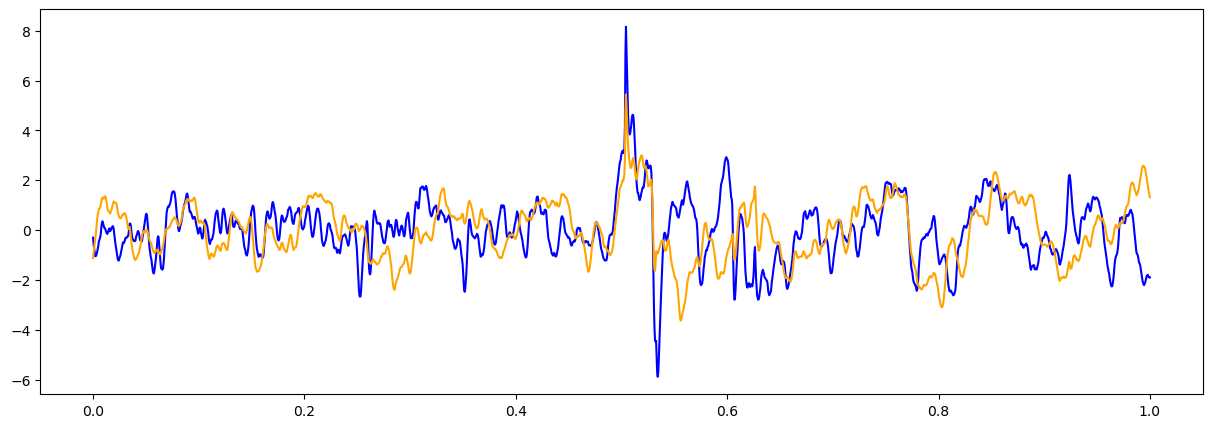

In [34]:
import mne

epochs_filtered = test_epoch.copy().filter(
    l_freq=4, 
    h_freq=12, 
    method='iir',
    iir_params={'order': 4, 'ftype': 'butter'}
)

def get_epoch_lfp_single(test_epoch, time_window):
    channels = list(test_epoch.ch_names)
    aon_channels = [channel for channel in channels if "AON" in channel]
    vhp_channels = [channel for channel in channels if "vHp" in channel]
    test_epoch_aon = test_epoch.get_data(picks=aon_channels)
    test_epoch_vhp = test_epoch.get_data(picks=vhp_channels)
    test_epoch_aon_mean = list(np.mean(test_epoch_aon, axis=(0,1)))
    test_epoch_vhp_mean = list(np.mean(test_epoch_vhp, axis = (0,1)))
    times = np.linspace(0, time_window, len(test_epoch_aon_mean))
    return test_epoch_aon_mean, test_epoch_vhp_mean, times

def get_epoch_lfp_single(test_epoch, time_window, trial_num):
    channels = list(test_epoch.ch_names)
    aon_channels = [channel for channel in channels if "AON" in channel]
    vhp_channels = [channel for channel in channels if "vHp" in channel]
    test_epoch_aon = test_epoch.get_data(picks=aon_channels)
    test_epoch_vhp = test_epoch.get_data(picks=vhp_channels)
    print(test_epoch_aon.shape)
    test_epoch_aon = list(test_epoch_aon[trial_num,0,:])
    test_epoch_vhp = list(test_epoch_vhp[trial_num,0,:])
    times = list(np.linspace(0, time_window, len(test_epoch_aon)))
    return test_epoch_aon, test_epoch_vhp, times


total_aon, total_vhp, total_time = get_epoch_lfp_single(test_epoch, time_window=1, trial_num=0)
beta_aon, beta_vhp, beta_time = get_epoch_lfp_single(epochs_filtered, time_window=1, trial_num=0)

total_aon_single, total_vhp_single, total_time_single = get_epoch_lfp_single(test_epoch, time_window=1, trial_num=0)
beta_aon_single, beta_vhp_single, beta_time_single = get_epoch_lfp_single(epochs_filtered, time_window=1, trial_num=0)

fig, ax = plt.subplots(1,1, figsize =(15,5))

ax.plot(total_time_single, total_aon_single, label ='total', color = 'blue')
ax.plot(total_time_single, total_vhp_single, label ="beta", color='orange')

plt.show()

#### Single Trial

<EpochsArray | 14 events (all good), 0 – 1 s (baseline off), ~665 kB, data loaded, with metadata,
 '1': 14>
  Processing total band (1-100 Hz)
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

(14, 1, 2000)
(14, 4, 2000)
  Processing theta band (4-12 Hz)
Setting up band-pass filter from 4 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 12.0

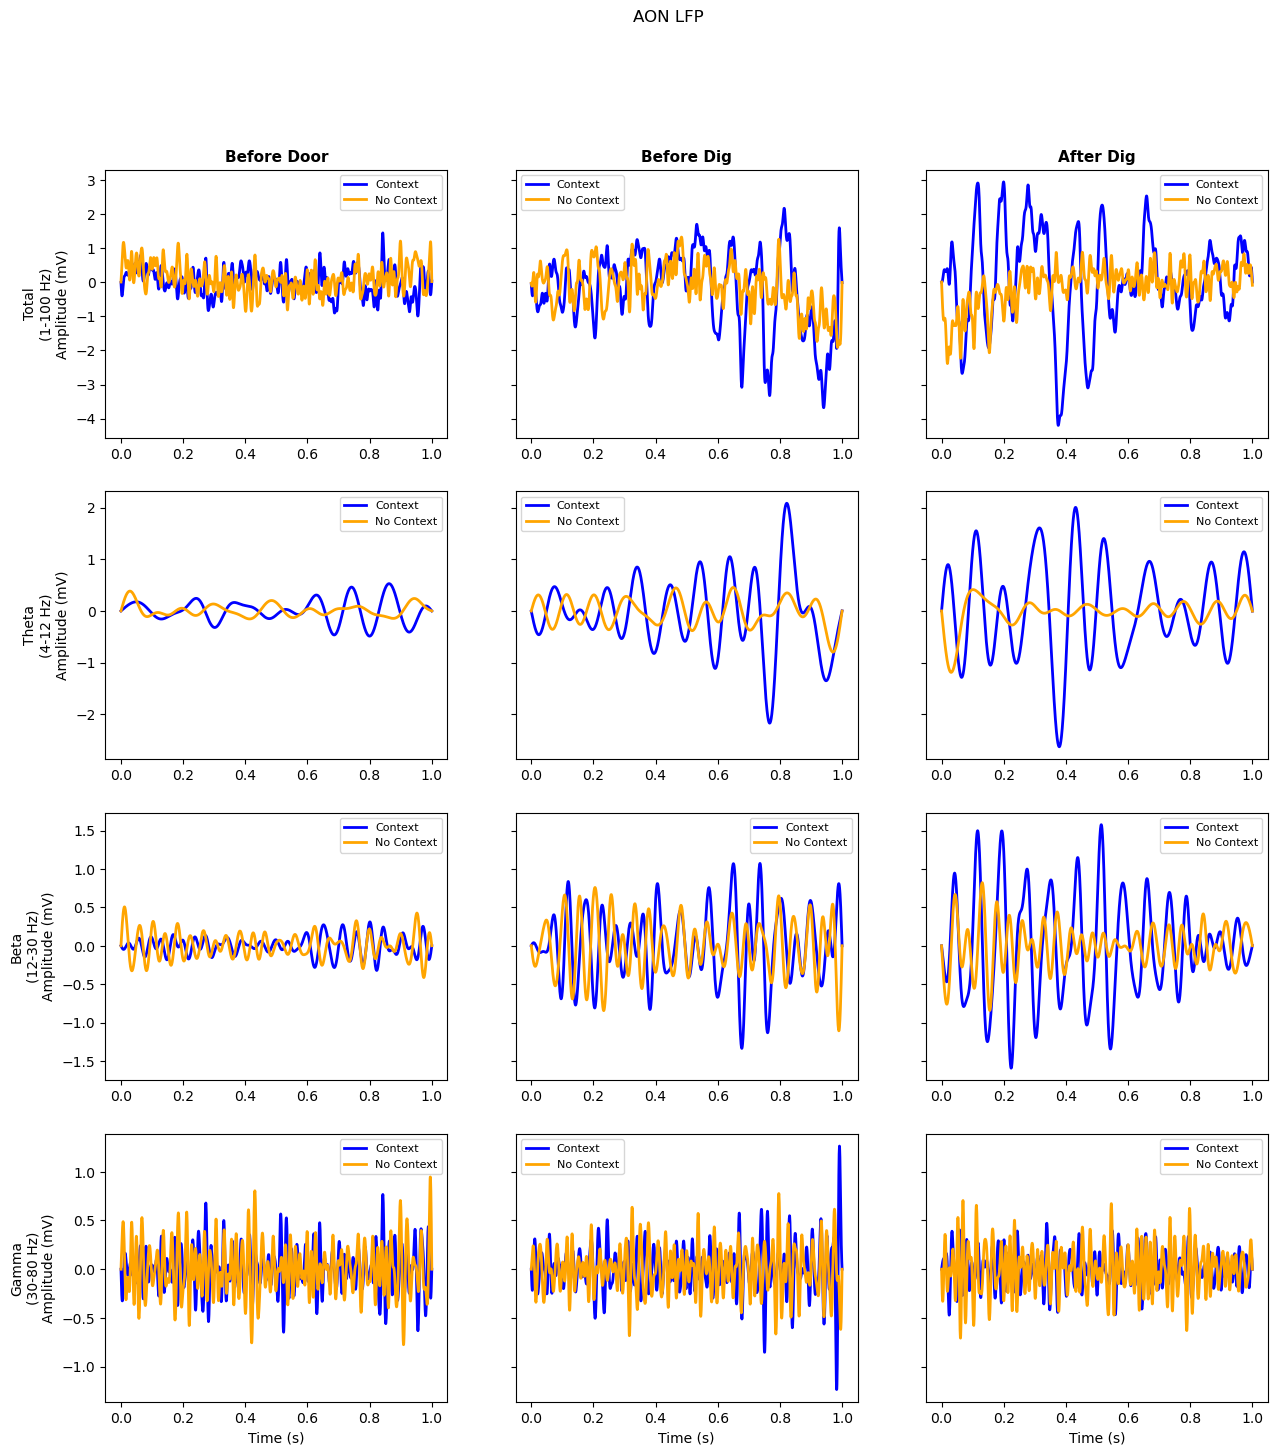

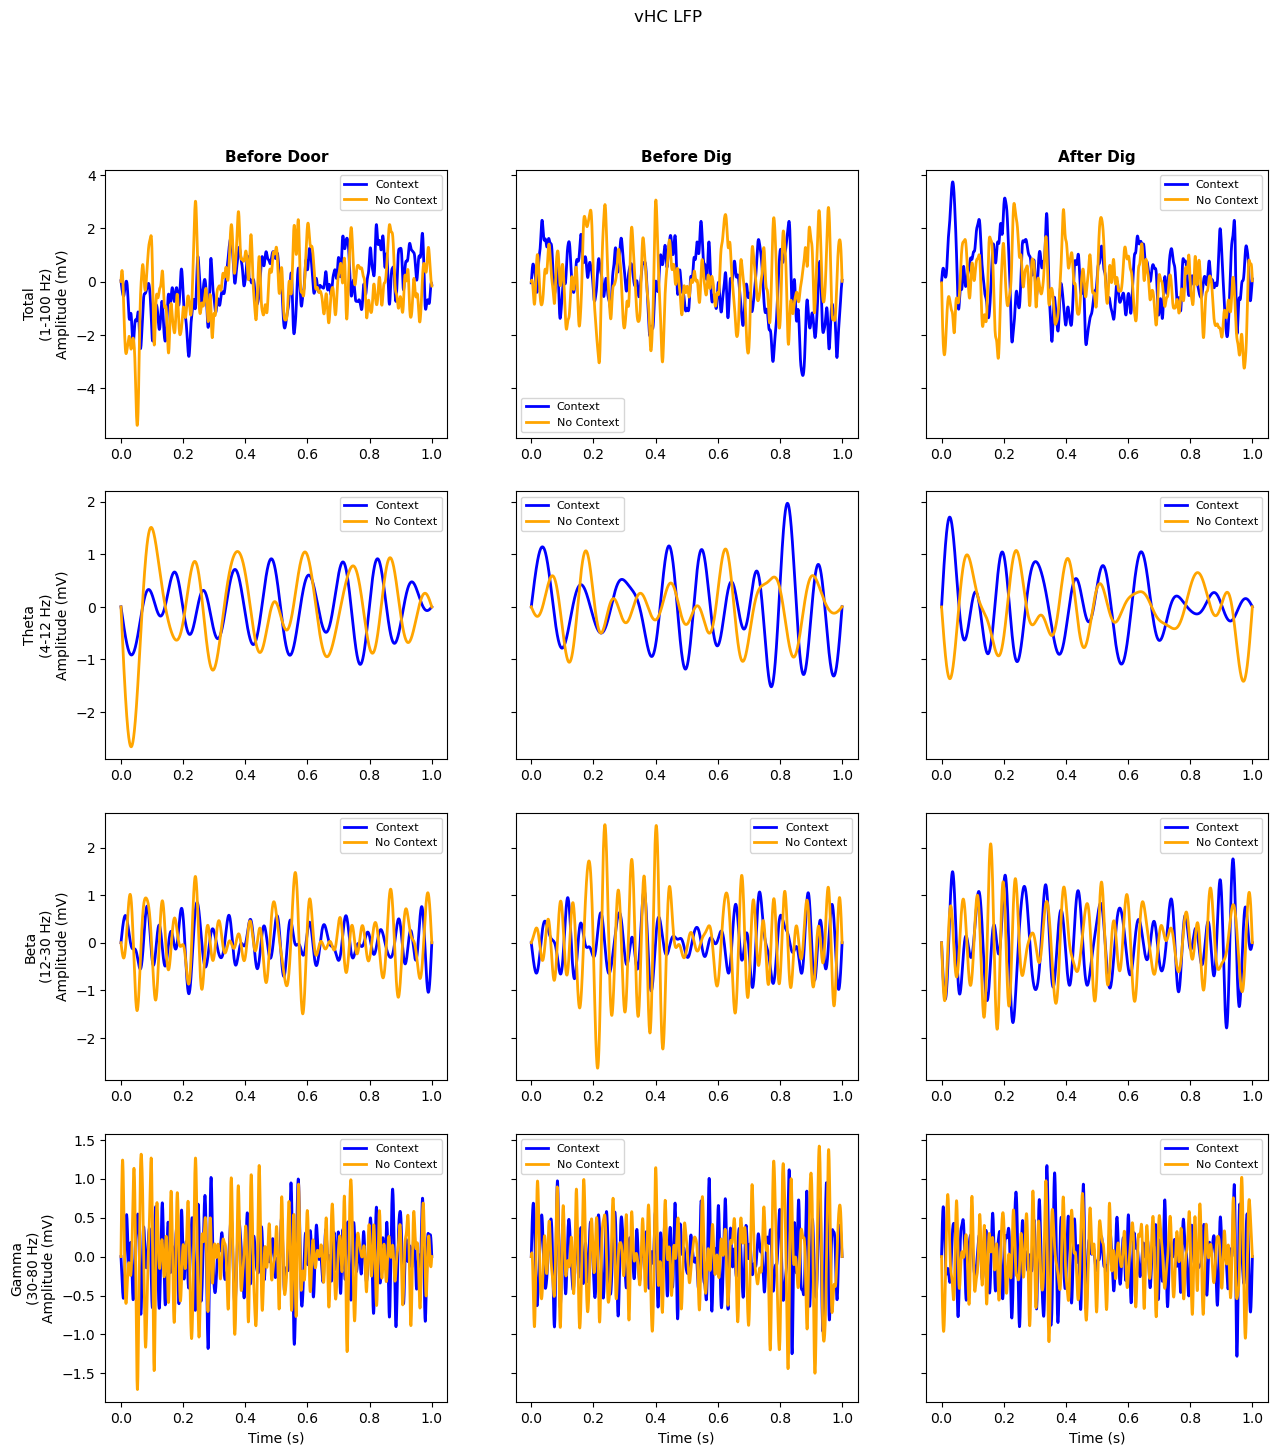

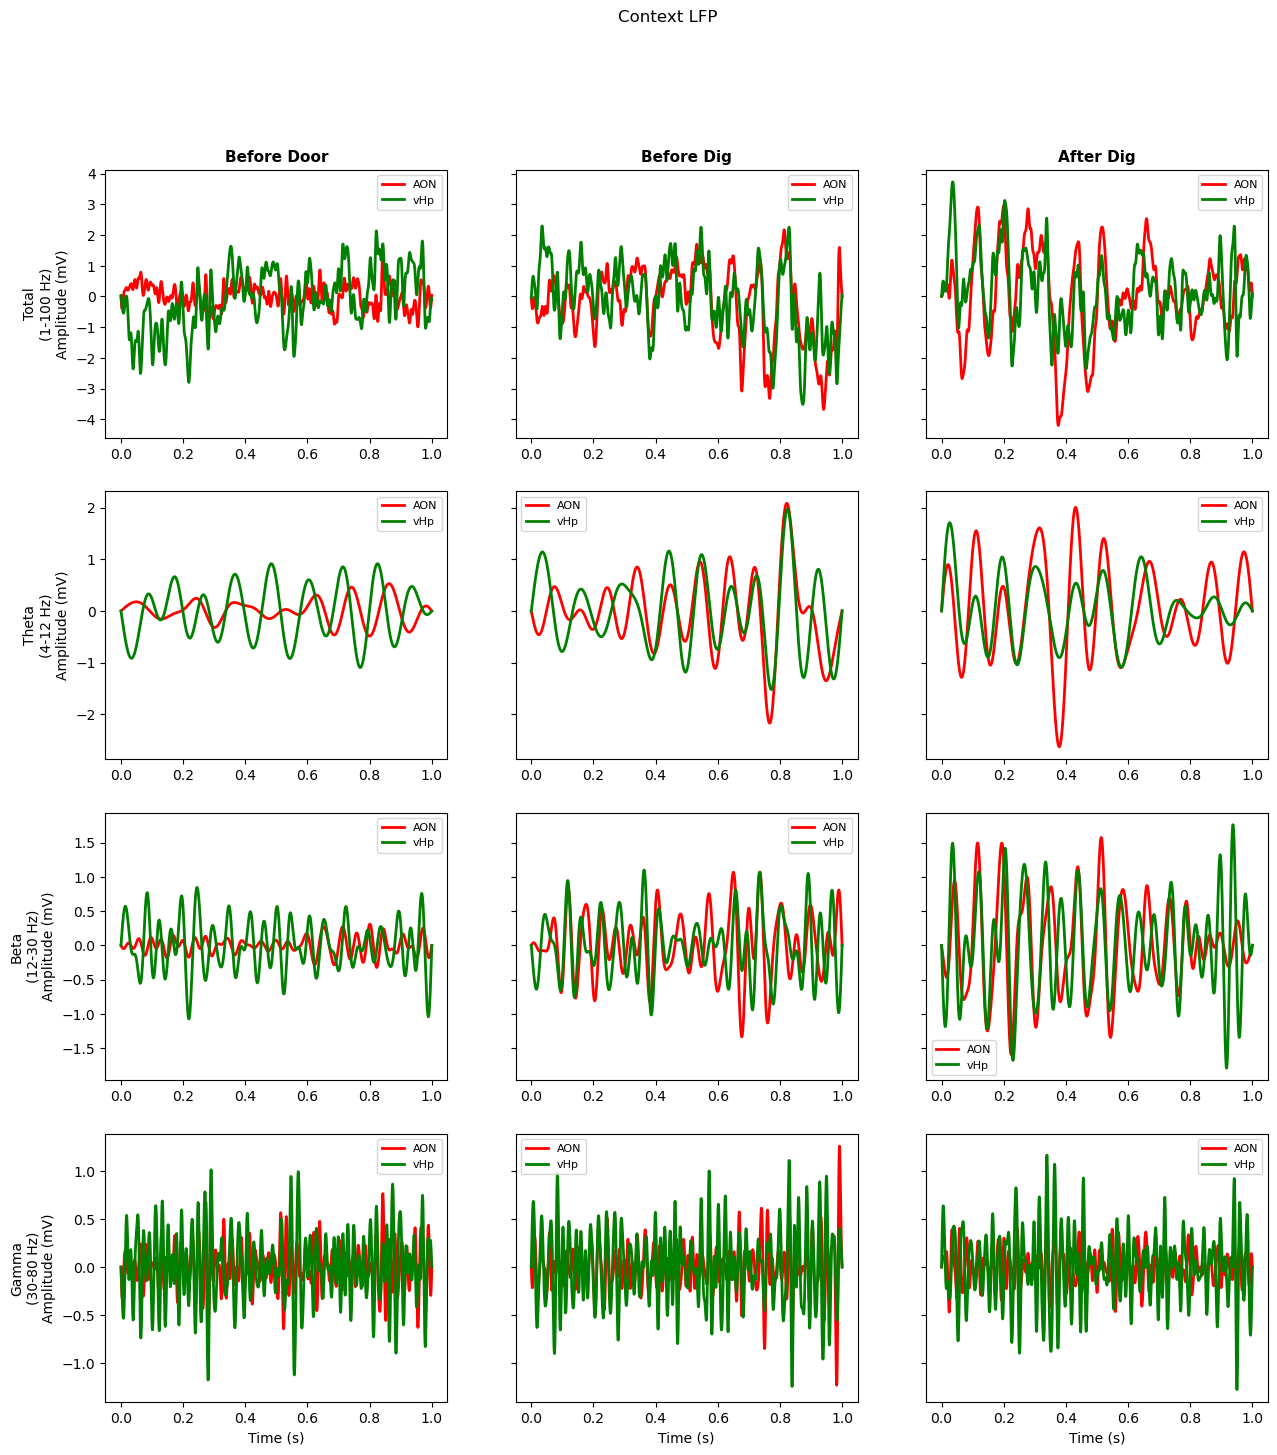

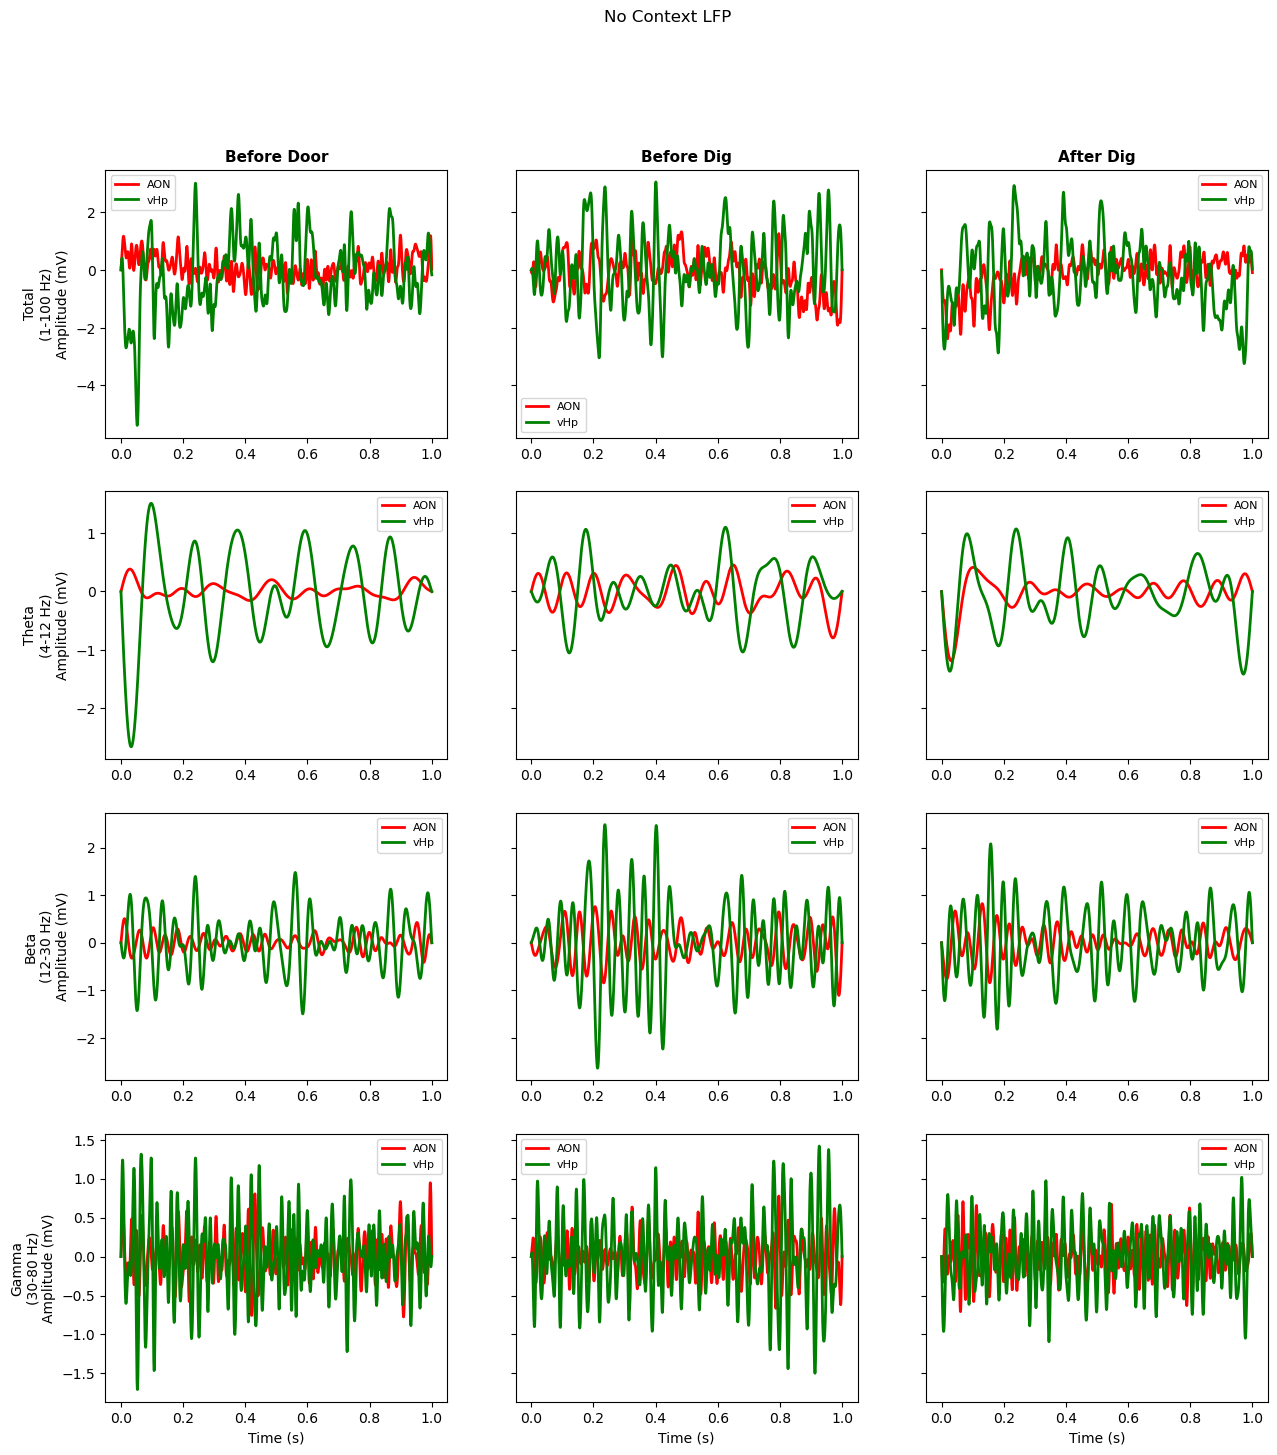

In [35]:
time_window=1
fs=2000
trial_num =4
## Potential Candidates - 3, 
lfp_data = pd.read_pickle(savepath + f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')

dk6_bwcontext = lfp_data[(lfp_data['rat_id']=='dk6') & (lfp_data['task']=='BWcontext')]
dk6_bwnocontext = lfp_data[(lfp_data['rat_id']=='dk6') & (lfp_data['task']=='BWnocontext')]


event_dict = {
    'mne_epoch_door_before': 'Before Door',
    'mne_epoch_dig_before': 'Before Dig',
    'mne_epoch_dig_after': 'After Dig'
}
all_bands_dict = {
    'total': [1, 100],
    'theta': [4, 12],
    'beta': [12, 30],
    'gamma': [30, 80]
}
time_window = 1.0

def filter_epoch(epoch, l_freq, h_freq):
    """Apply bandpass filter to epoch"""
    return epoch.copy().filter(
        l_freq=l_freq,
        h_freq=h_freq,
        method='iir',
        iir_params={'order': 4, 'ftype': 'butter'}
    )
    
aon_fig, aon_axs = plt.subplots(4, 3, figsize=(15, 16), sharey='row')
aon_fig.suptitle('AON LFP')
aon_writer = pd.ExcelWriter(savepath + f'lfp_events_aon_{int(time_window*fs/2)}ms.xlsx')

vhp_fig, vhp_axs = plt.subplots(4, 3, figsize=(15, 16), sharey='row')
vhp_fig.suptitle('vHC LFP')
vhp_writer = pd.ExcelWriter(savepath + f'lfp_events_vhp_{int(time_window*fs/2)}ms.xlsx')

bwcontext_fig, bwcontext_axs = plt.subplots(4, 3, figsize=(15, 16), sharey='row')
bwcontext_fig.suptitle('Context LFP')
bwcontext_writer = pd.ExcelWriter(savepath + f'lfp_events_bwcontext_{int(time_window*fs/2)}ms.xlsx')

bwnocontext_fig, bwnocontext_axs = plt.subplots(4, 3, figsize=(15, 16), sharey='row')
bwnocontext_fig.suptitle('No Context LFP')
bwnocontext_writer = pd.ExcelWriter(savepath + f'lfp_events_bwnocontext_{int(time_window*fs/2)}ms.xlsx')

for event_idx, event in enumerate(event_dict.keys()):
    aon_dict = {}
    vhp_dict = {}
    
    bwcontext_dict = {}
    bwnocontext_dict={}
    
    bwcontext_epoch_object = dk6_bwcontext[event].iloc[0]
    bwnocontext_epoch_object = dk6_bwnocontext[event].iloc[0]
    
    print(bwcontext_epoch_object)
    
    for band_idx, (band_name, (l_freq, h_freq)) in enumerate(all_bands_dict.items()):
        print(f"  Processing {band_name} band ({l_freq}-{h_freq} Hz)")
        bwcontext_epoch_object_filtered = filter_epoch(bwcontext_epoch_object, l_freq, h_freq)
        bwnocontext_epoch_object_filtered = filter_epoch(bwnocontext_epoch_object, l_freq, h_freq) 
        
        aon_bwcontext,vhp_bwcontext,time_bwcontext = get_epoch_lfp_single(bwcontext_epoch_object_filtered, time_window, trial_num)
        aon_bwnocontext,vhp_bwnocontext,time_bwnocontext = get_epoch_lfp_single(bwnocontext_epoch_object_filtered, time_window, trial_num)
        
        #==============Plot AON====================================
        
        ax_aon = aon_axs[band_idx, event_idx]
        ax_aon.plot(time_bwcontext, aon_bwcontext, label='Context', linewidth=2, color='blue')
        ax_aon.plot(time_bwnocontext, aon_bwnocontext, label='No Context', linewidth=2, color='Orange')
        
        if event_idx == 0:
            ax_aon.set_ylabel(f'{band_name.capitalize()}\n({l_freq}-{h_freq} Hz)\nAmplitude (mV)', fontsize=10)
        if band_idx == 0:
            ax_aon.set_title(f'{event_dict[event]}', fontsize=11, fontweight='bold')
        if band_idx == 3:
            ax_aon.set_xlabel('Time (s)', fontsize=10)
        ax_aon.legend(loc='best', fontsize=8)

        #==============Plot vHp====================================
        
        ax_vhp = vhp_axs[band_idx, event_idx]
        ax_vhp.plot(time_bwcontext, vhp_bwcontext, label='Context', linewidth=2, color='blue')
        ax_vhp.plot(time_bwnocontext, vhp_bwnocontext, label='No Context', linewidth=2, color='Orange')
        
        if event_idx == 0:
            ax_vhp.set_ylabel(f'{band_name.capitalize()}\n({l_freq}-{h_freq} Hz)\nAmplitude (mV)', fontsize=10)
        if band_idx == 0:
            ax_vhp.set_title(f'{event_dict[event]}', fontsize=11, fontweight='bold')
        if band_idx == 3:
            ax_vhp.set_xlabel('Time (s)', fontsize=10)
        ax_vhp.legend(loc='best', fontsize=8)

        #====================Plotting BW Context ==================
        ax_bwcontext = bwcontext_axs[band_idx, event_idx]
        ax_bwcontext.plot(time_bwcontext, aon_bwcontext, label='AON', linewidth=2, color='red')
        ax_bwcontext.plot(time_bwcontext, vhp_bwcontext, label='vHp', linewidth=2, color='green')
        
        if event_idx == 0:
            ax_bwcontext.set_ylabel(f'{band_name.capitalize()}\n({l_freq}-{h_freq} Hz)\nAmplitude (mV)', fontsize=10)
        if band_idx == 0:
            ax_bwcontext.set_title(f'{event_dict[event]}', fontsize=11, fontweight='bold')
        if band_idx == 3:
            ax_bwcontext.set_xlabel('Time (s)', fontsize=10)
        ax_bwcontext.legend(loc='best', fontsize=8)
        #====================Plotting BW No Context ==================
        ax_bwnocontext = bwnocontext_axs[band_idx, event_idx]
        ax_bwnocontext.plot(time_bwnocontext, aon_bwnocontext, label='AON', linewidth=2, color='red')
        ax_bwnocontext.plot(time_bwnocontext, vhp_bwnocontext, label='vHp', linewidth=2, color='green')
        
        if event_idx == 0:
            ax_bwnocontext.set_ylabel(f'{band_name.capitalize()}\n({l_freq}-{h_freq} Hz)\nAmplitude (mV)', fontsize=10)
        if band_idx == 0:
            ax_bwnocontext.set_title(f'{event_dict[event]}', fontsize=11, fontweight='bold')
        if band_idx == 3:
            ax_bwnocontext.set_xlabel('Time (s)', fontsize=10)
        ax_bwnocontext.legend(loc='best', fontsize=8)

        #=================Saving in AON -vHp CSV===================
        if time_bwcontext==time_bwnocontext:
            aon_dict['time'] = time_bwcontext
        else:
            print("WTF Why are times different")
            break
        aon_dict[f'bwcontext_{band_name}'] = aon_bwcontext
        aon_dict[f'bwnocontext_{band_name}'] = aon_bwnocontext
        
        if time_bwcontext==time_bwnocontext:
            vhp_dict['time'] = time_bwcontext
        else:
            print("WTF Why are times different")
            break
        vhp_dict[f'bwcontext_{band_name}'] = vhp_bwcontext
        vhp_dict[f'bwnocontext_{band_name}'] = vhp_bwnocontext
        
        aon_df = pd.DataFrame(aon_dict)
        vhp_df = pd.DataFrame(vhp_dict)
        
        aon_df.to_excel(aon_writer, sheet_name=event_dict[event])
        vhp_df.to_excel(vhp_writer, sheet_name=event_dict[event])

        #=================Saving in Context - NoContext CSV===================
        if time_bwcontext==time_bwnocontext:
            bwcontext_dict['time'] = time_bwcontext
        else:
            print("WTF Why are times different")
            break
        bwcontext_dict[f'aon_{band_name}'] = aon_bwcontext
        bwcontext_dict[f'vhp_{band_name}'] = vhp_bwcontext
        
        if time_bwcontext==time_bwnocontext:
            vhp_dict['time'] = time_bwcontext
        else:
            print("WTF Why are times different")
            break
        bwnocontext_dict[f'aon_{band_name}'] = aon_bwnocontext
        bwnocontext_dict[f'vhp_{band_name}'] = vhp_bwnocontext
                
        bwcontext_df = pd.DataFrame(bwcontext_dict)
        bwnocontext_df = pd.DataFrame(bwnocontext_dict)
        
        bwcontext_df.to_excel(bwcontext_writer, sheet_name=event_dict[event])
        bwnocontext_df.to_excel(bwnocontext_writer, sheet_name=event_dict[event])

aon_writer.close()
vhp_writer.close()
bwcontext_writer.close()
bwnocontext_writer.close()

aon_fig.savefig(savepath+f'lfp_events_aon_{int(time_window*fs/2)}ms.png', format='png', dpi=300, bbox_inches='tight')
vhp_fig.savefig(savepath+f'lfp_events_vhp_{int(time_window*fs/2)}ms.png', format='png', dpi=300, bbox_inches='tight')

bwcontext_fig.savefig(savepath+f'lfp_events_bwcontext_{int(time_window*fs/2)}ms.png', format='png', dpi=300, bbox_inches='tight')
bwnocontext_fig.savefig(savepath+f'lfp_events_bwnocontext_{int(time_window*fs/2)}ms.png', format='png', dpi=300, bbox_inches='tight')

plt.show()




In [ ]:

aon_fig, aon_axs = plt.subplots(4, 3, figsize=(15, 16))
vhp_fig, vhp_axs = plt.subplots(4, 3, figsize=(15, 16))

# Process each frequency band
for band_idx, (band_name, (l_freq, h_freq)) in enumerate(all_bands_dict.items()):
    print(f"  Processing {band_name} band ({l_freq}-{h_freq} Hz)")
    
    # Process each event type
    for event_idx, (col, event_name) in enumerate(event_dict.items()):
        
        # Filter and process context data
        if len(dk6_bwcontext) > 0:
            context_filtered = filter_epoch(dk6_bwcontext[col], l_freq, h_freq)

            context_results = get_epoch_lfp_single(context_filtered, time_window)
            
            # Extract components correctly
            context_times = np.array(context_results.iloc[0][2])
            context_aon_list = [result[0] for result in context_results]
            context_vhp_list = [result[1] for result in context_results]
            
            context_aon_means = np.array(context_aon_list)
            context_vhp_means = np.array(context_vhp_list)
            
            context_aon_avg = np.mean(context_aon_means, axis=0)
            context_aon_sem = np.std(context_aon_means, axis=0) / np.sqrt(len(context_aon_means))
            
            context_vhp_avg = np.mean(context_vhp_means, axis=0)
            context_vhp_sem = np.std(context_vhp_means, axis=0) / np.sqrt(len(context_vhp_means))
        
        # Filter and process no context data
        if len(dk6_bwnocontext) > 0:
            nocontext_filtered = filter_epoch(dk6_bwnocontext[col], l_freq, h_freq)

            nocontext_results = get_epoch_lfp_single(nocontext_filtered, time_window)
            
            # Extract components correctly
            nocontext_times = np.array(nocontext_results.iloc[0][2])
            nocontext_aon_list = [result[0] for result in nocontext_results]
            nocontext_vhp_list = [result[1] for result in nocontext_results]
            
            nocontext_aon_means = np.array(nocontext_aon_list)
            nocontext_vhp_means = np.array(nocontext_vhp_list)
            
            nocontext_aon_avg = np.mean(nocontext_aon_means, axis=0)
            nocontext_aon_sem = np.std(nocontext_aon_means, axis=0) / np.sqrt(len(nocontext_aon_means))
            
            nocontext_vhp_avg = np.mean(nocontext_vhp_means, axis=0)
            nocontext_vhp_sem = np.std(nocontext_vhp_means, axis=0) / np.sqrt(len(nocontext_vhp_means))
        
        # ============ AON PLOTS ============
        ax_aon = aon_axs[band_idx, event_idx]
        
        if len(dk6_bwcontext) > 0:
            ax_aon.plot(context_times, context_aon_avg, label='Context', linewidth=2, color='blue')
            ax_aon.fill_between(
                context_times,
                context_aon_avg - context_aon_sem,
                context_aon_avg + context_aon_sem,
                alpha=0.3,
                color='blue'
            )
        
        if len(dk6_bwnocontext) > 0:
            ax_aon.plot(nocontext_times, nocontext_aon_avg, label='No Context', linewidth=2, color='orange')
            ax_aon.fill_between(
                nocontext_times,
                nocontext_aon_avg - nocontext_aon_sem,
                nocontext_aon_avg + nocontext_aon_sem,
                alpha=0.3,
                color='orange'
            )
        
        # Formatting for AON
        if event_idx == 0:
            ax_aon.set_ylabel(f'{band_name.capitalize()}\n({l_freq}-{h_freq} Hz)\nAmplitude (μV)', fontsize=10)
        if band_idx == 0:
            ax_aon.set_title(f'{event_name}', fontsize=11, fontweight='bold')
        if band_idx == 3:
            ax_aon.set_xlabel('Time (s)', fontsize=10)
        
        ax_aon.legend(loc='best', fontsize=8)
        ax_aon.grid(True, alpha=0.3)
        ax_aon.axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
        
        # ============ vHp PLOTS ============
        ax_vhp = vhp_axs[band_idx, event_idx]
        
        if len(dk6_bwcontext) > 0:
            ax_vhp.plot(context_times, context_vhp_avg, label='Context', linewidth=2, color='blue')
            ax_vhp.fill_between(
                context_times,
                context_vhp_avg - context_vhp_sem,
                context_vhp_avg + context_vhp_sem,
                alpha=0.3,
                color='blue'
            )
        
        if len(dk6_bwnocontext) > 0:
            ax_vhp.plot(nocontext_times, nocontext_vhp_avg, label='No Context', linewidth=2, color='orange')
            ax_vhp.fill_between(
                nocontext_times,
                nocontext_vhp_avg - nocontext_vhp_sem,
                nocontext_vhp_avg + nocontext_vhp_sem,
                alpha=0.3,
                color='orange'
            )
        
        # Formatting for vHp
        if event_idx == 0:
            ax_vhp.set_ylabel(f'{band_name.capitalize()}\n({l_freq}-{h_freq} Hz)\nAmplitude (μV)', fontsize=10)
        if band_idx == 0:
            ax_vhp.set_title(f'{event_name}', fontsize=11, fontweight='bold')
        if band_idx == 3:
            ax_vhp.set_xlabel('Time (s)', fontsize=10)
        
        ax_vhp.legend(loc='best', fontsize=8)
        ax_vhp.grid(True, alpha=0.3)
        ax_vhp.axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=1)

# Add overall titles and adjust layout
aon_fig.suptitle(f'Rat {rat} - AON LFP Analysis (Frequency Bands)', fontsize=14, fontweight='bold', y=0.995)
vhp_fig.suptitle(f'Rat {rat} - vHp LFP Analysis (Frequency Bands)', fontsize=14, fontweight='bold', y=0.995)

aon_fig.tight_layout()
vhp_fig.tight_layout()

plt.show()

#### Mean Waveform

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
lfp_data = pd.read_pickle(savepath + f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')
rat_list = np.unique(lfp_data['rat_id'])
print(f"Processing {len(rat_list)} rats: {rat_list}")

# Define events and parameters
event_dict = {
    'mne_epoch_door_before': 'Before Door',
    'mne_epoch_dig_before': 'Before Dig',
    'mne_epoch_dig_after': 'After Dig'
}
all_bands_dict = {
    'total': [1, 100],
    'theta': [4, 12],
    'beta': [12, 30],
    'gamma': [30, 80]
}
time_window = 1.0

def filter_epoch(epoch, l_freq, h_freq):
    """Apply bandpass filter to epoch"""
    return epoch.copy().filter(
        l_freq=l_freq,
        h_freq=h_freq,
        method='iir',
        iir_params={'order': 4, 'ftype': 'butter'}
    )

# Process each rat
for rat in rat_list:
    print(f"Processing rat: {rat}")
    
    # Filter data for current rat
    rat_data = lfp_data[lfp_data['rat_id'] == rat].copy()
    
    # Separate data by task and reset index
    bwcontext_data = rat_data[rat_data['task'] == 'BWcontext'].copy().reset_index(drop=True)
    bwnocontext_data = rat_data[rat_data['task'] == 'BWnocontext'].copy().reset_index(drop=True)
    
    # Skip if no data for this rat
    if len(bwcontext_data) == 0 and len(bwnocontext_data) == 0:
        print(f"  No data for rat {rat}, skipping...")
        continue
    
    # Create separate figures for AON and vHp with 4 rows (one per band)
    aon_fig, aon_axs = plt.subplots(4, 3, figsize=(15, 16))
    vhp_fig, vhp_axs = plt.subplots(4, 3, figsize=(15, 16))
    
    # Process each frequency band
    for band_idx, (band_name, (l_freq, h_freq)) in enumerate(all_bands_dict.items()):
        print(f"  Processing {band_name} band ({l_freq}-{h_freq} Hz)")
        
        # Process each event type
        for event_idx, (col, event_name) in enumerate(event_dict.items()):
            
            # Filter and process context data
            if len(bwcontext_data) > 0:
                context_filtered = bwcontext_data[col].apply(
                    lambda epoch: filter_epoch(epoch, l_freq, h_freq)
                )
                context_results = context_filtered.apply(
                    lambda epoch: get_epoch_lfp_single(epoch, time_window)
                )
                
                # Extract components correctly
                context_times = np.array(context_results.iloc[0][2])
                context_aon_list = [result[0] for result in context_results]
                context_vhp_list = [result[1] for result in context_results]
                
                context_aon_means = np.array(context_aon_list)
                context_vhp_means = np.array(context_vhp_list)
                
                context_aon_avg = np.mean(context_aon_means, axis=0)
                context_aon_sem = np.std(context_aon_means, axis=0) / np.sqrt(len(context_aon_means))
                
                context_vhp_avg = np.mean(context_vhp_means, axis=0)
                context_vhp_sem = np.std(context_vhp_means, axis=0) / np.sqrt(len(context_vhp_means))
            
            # Filter and process no context data
            if len(bwnocontext_data) > 0:
                nocontext_filtered = bwnocontext_data[col].apply(
                    lambda epoch: filter_epoch(epoch, l_freq, h_freq)
                )
                nocontext_results = nocontext_filtered.apply(
                    lambda epoch: get_epoch_lfp_single(epoch, time_window)
                )
                
                # Extract components correctly
                nocontext_times = np.array(nocontext_results.iloc[0][2])
                nocontext_aon_list = [result[0] for result in nocontext_results]
                nocontext_vhp_list = [result[1] for result in nocontext_results]
                
                nocontext_aon_means = np.array(nocontext_aon_list)
                nocontext_vhp_means = np.array(nocontext_vhp_list)
                
                nocontext_aon_avg = np.mean(nocontext_aon_means, axis=0)
                nocontext_aon_sem = np.std(nocontext_aon_means, axis=0) / np.sqrt(len(nocontext_aon_means))
                
                nocontext_vhp_avg = np.mean(nocontext_vhp_means, axis=0)
                nocontext_vhp_sem = np.std(nocontext_vhp_means, axis=0) / np.sqrt(len(nocontext_vhp_means))
            
            # ============ AON PLOTS ============
            ax_aon = aon_axs[band_idx, event_idx]
            
            if len(bwcontext_data) > 0:
                ax_aon.plot(context_times, context_aon_avg, label='Context', linewidth=2, color='blue')
                ax_aon.fill_between(
                    context_times,
                    context_aon_avg - context_aon_sem,
                    context_aon_avg + context_aon_sem,
                    alpha=0.3,
                    color='blue'
                )
            
            if len(bwnocontext_data) > 0:
                ax_aon.plot(nocontext_times, nocontext_aon_avg, label='No Context', linewidth=2, color='orange')
                ax_aon.fill_between(
                    nocontext_times,
                    nocontext_aon_avg - nocontext_aon_sem,
                    nocontext_aon_avg + nocontext_aon_sem,
                    alpha=0.3,
                    color='orange'
                )
            
            # Formatting for AON
            if event_idx == 0:
                ax_aon.set_ylabel(f'{band_name.capitalize()}\n({l_freq}-{h_freq} Hz)\nAmplitude (μV)', fontsize=10)
            if band_idx == 0:
                ax_aon.set_title(f'{event_name}', fontsize=11, fontweight='bold')
            if band_idx == 3:
                ax_aon.set_xlabel('Time (s)', fontsize=10)
            
            ax_aon.legend(loc='best', fontsize=8)
            ax_aon.grid(True, alpha=0.3)
            ax_aon.axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
            
            # ============ vHp PLOTS ============
            ax_vhp = vhp_axs[band_idx, event_idx]
            
            if len(bwcontext_data) > 0:
                ax_vhp.plot(context_times, context_vhp_avg, label='Context', linewidth=2, color='blue')
                ax_vhp.fill_between(
                    context_times,
                    context_vhp_avg - context_vhp_sem,
                    context_vhp_avg + context_vhp_sem,
                    alpha=0.3,
                    color='blue'
                )
            
            if len(bwnocontext_data) > 0:
                ax_vhp.plot(nocontext_times, nocontext_vhp_avg, label='No Context', linewidth=2, color='orange')
                ax_vhp.fill_between(
                    nocontext_times,
                    nocontext_vhp_avg - nocontext_vhp_sem,
                    nocontext_vhp_avg + nocontext_vhp_sem,
                    alpha=0.3,
                    color='orange'
                )
            
            # Formatting for vHp
            if event_idx == 0:
                ax_vhp.set_ylabel(f'{band_name.capitalize()}\n({l_freq}-{h_freq} Hz)\nAmplitude (μV)', fontsize=10)
            if band_idx == 0:
                ax_vhp.set_title(f'{event_name}', fontsize=11, fontweight='bold')
            if band_idx == 3:
                ax_vhp.set_xlabel('Time (s)', fontsize=10)
            
            ax_vhp.legend(loc='best', fontsize=8)
            ax_vhp.grid(True, alpha=0.3)
            ax_vhp.axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
    
    # Add overall titles and adjust layout
    aon_fig.suptitle(f'Rat {rat} - AON LFP Analysis (Frequency Bands)', fontsize=14, fontweight='bold', y=0.995)
    vhp_fig.suptitle(f'Rat {rat} - vHp LFP Analysis (Frequency Bands)', fontsize=14, fontweight='bold', y=0.995)
    
    aon_fig.tight_layout()
    vhp_fig.tight_layout()
    
    plt.show()

# 4 Power Spectra Analysis


## 4.1 Baseline Power

### Baseline PSD

In [ ]:
import plotting_styles
from mne.time_frequency import psd_array_multitaper
importlib.reload(plotting_styles)
importlib.reload(power_functions)
linestyle = plotting_styles.linestyles
colors = plotting_styles.colors
baseline_lfp_all = pd.read_pickle(savepath+'baseline_lfp_all.pkl')
df= baseline_lfp_all.__deepcopy__()
df['channel']=df['channel'].apply(lambda x:'AON' if 'AON' in x else 'vHp')
channel_experiment_group=df.groupby(['task','channel'])
channel_dict = {'BWcontext_AON': 'context AON', 'BWcontext_vHp': 'context vHp',
                'BWnocontext_AON': 'No context AON', 'BWnocontext_vHp': 'No context vHp'}

fig, ax = plt.subplots(figsize=(15, 10))
mean_dict={}
for channel, data in channel_experiment_group:
    print(channel)
    data_array=np.vstack(data['data'].to_numpy())
    print(data_array.shape)
    data_array_welch = np.array([power_functions.apply_welch_transform(row) for row in data_array]) # Applying Welch's method to each row of data_array
    print(data_array_welch.shape)
    freqs = np.linspace(0,1000,num=int(data_array_welch.shape[1]))  # Assuming the frequency range is 0-1000 Hz
    print(freqs.shape)

    data_array_welch_mean = np.mean(data_array_welch, axis=0)
    data_array_welch_std = np.std(data_array_welch, axis=0)
    print(data_array_welch_mean.shape, data_array_welch_std.shape)
    mean_dict[channel[0] + '_' + channel[1] + '_mean'] = data_array_welch_mean
    mean_dict[channel[0] + '_' + channel[1] + '_std'] = data_array_welch_std
    
    ax.plot(freqs,data_array_welch_mean, linestyle=linestyle[channel[1]], color=colors[channel[0]], label=f'{channel[0]} {channel[1]}')
    ax.fill_between(freqs,data_array_welch_mean-data_array_welch_std,data_array_welch_mean+data_array_welch_std, alpha=0.1, color=colors[channel[0]])
    #ax.set_yscale('log')
    ax.set_xlim(0,100)
    ax.legend(loc='upper right', fontsize=20)
    ax.set_title('Baseline Power Spectral Density', fontsize=20)
    ax.set_xlabel('Frequency (Hz)', fontsize=20)
    ax.set_ylabel('Power (V^2/Hz)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
#    ax.set_yscale('log')
mean_dict['frequency']=freqs
mean_df=pd.DataFrame(mean_dict)
#mean_df.to_csv(savepath+'baseline_power_truncated.csv')
#plt.savefig(savepath+'baseline_power_truncated.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)

# Calculate multitaper PSD for each group and plot
fig_mt, ax_mt = plt.subplots(figsize=(15, 10))
mt_mean_dict = {}
for channel, data in channel_experiment_group:
    data_array = np.vstack(data['data'].to_numpy())
    # Multitaper PSD: average across trials
    psds = []
    for row in data_array:
        psd, freqs_mt = psd_array_multitaper(row, sfreq=2000,bandwidth=2, fmin=0, fmax=100, adaptive=True, normalization='full', verbose=0)
        psds.append(psd)
    psds = np.array(psds)
    psd_mean = psds.mean(axis=0)
    psd_std = psds.std(axis=0)
    mt_mean_dict[channel[0] + '_' + channel[1] + '_mean'] = psd_mean
    mt_mean_dict[channel[0] + '_' + channel[1] + '_std'] = psd_std
    ax_mt.plot(freqs_mt, psd_mean, linestyle=linestyle[channel[1]], color=colors[channel[0]], label=f'{channel[0]}_{channel[1]}')
    ax_mt.fill_between(freqs_mt, psd_mean-psd_std, psd_mean+psd_std, alpha=0.1, color=colors[channel[0]])
ax_mt.set_xlim(0, 100)
handles, labels = ax_mt.get_legend_handles_labels()
ax_mt.legend(handles, [channel_dict[l] for l in labels], loc='upper right', fontsize=20)
ax_mt.set_title('Baseline Power Spectral Density (Multitaper)', fontsize=20)
ax_mt.set_xlabel('Frequency (Hz)', fontsize=20)
ax_mt.set_ylabel('Power (V^2/Hz)', fontsize=20)
ax_mt.tick_params(axis='both', which='major', labelsize=20)

mt_mean_dict['frequency'] = freqs_mt
mt_mean_df = pd.DataFrame(mt_mean_dict)
mt_mean_df.to_csv(savepath+'baseline_psd_multitaper.csv')
plt.savefig(savepath+'baseline_psd_multitaper.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig_mt)

In [ ]:
from scipy.stats import f_oneway

# Prepare data for ANOVA: for each frequency, compare power between tasks
# We'll do this for both AON and vHp channels

results = {'frequency': [], 'AON_F': [], 'AON_p': [], 'vHp_F': [], 'vHp_p': []}
tasks = ['BWcontext', 'BWnocontext']
def make_welch_data_dfs(data, task, channel):
    data_task_channel = data[(data['task'] == task) & (data['channel'] == channel)]
    data_array = np.vstack(data_task_channel['data'].to_numpy())
    data_array_welch = np.array([power_functions.apply_welch_transform(row) for row in data_array])  # Applying Welch's method to each row of data_array
    return data_array_welch

aon_context_vals= make_welch_data_dfs(df, 'BWcontext', 'AON')
aon_nocontext_vals= make_welch_data_dfs(df, 'BWnocontext', 'AON')
vHp_context_vals= make_welch_data_dfs(df, 'BWcontext', 'vHp')
vHp_nocontext_vals= make_welch_data_dfs(df, 'BWnocontext', 'vHp')
for freq in range(aon_context_vals.shape[1]):
    aon_f, aon_p = f_oneway(aon_context_vals[:, freq], aon_nocontext_vals[:, freq])
    vHp_f, vHp_p = f_oneway(vHp_context_vals[:, freq], vHp_nocontext_vals[:, freq])
    
    results['frequency'].append(freq)
    results['AON_F'].append(aon_f)
    results['AON_p'].append(aon_p)
    results['vHp_F'].append(vHp_f)
    results['vHp_p'].append(vHp_p)
    # Convert results to DataFrame and filter for frequency 1 to 100
results_df = pd.DataFrame(results)
results_df = results_df[(results_df['frequency'] >= 1) & (results_df['frequency'] <= 100)]
results_df.to_csv(savepath + 'anova_psd_per_frequency_1_100.csv', index=False)
print(results_df.head())

In [ ]:


# For each frequency, extract power for each task and channel
for i, freq in enumerate(mean_df['frequency']):
    # For ANOVA, we need the raw values, not the means, so we go back to the original data
    # Get all AON/vHp power values at this frequency for each task
    aon_mask = (data['channel'] == 'AON')
    vhp_mask = (data['channel'] == 'vHp')
    context_mask = (data['task'] == 'BWcontext')
    nocontext_mask = (data['task'] == 'BWnocontext')

    aon_context_vals = data_array_welch[aon_mask & context_mask, i]
    aon_nocontext_vals = data_array_welch[aon_mask & nocontext_mask, i]
    vhp_context_vals = data_array_welch[vhp_mask & context_mask, i]
    vhp_nocontext_vals = data_array_welch[vhp_mask & nocontext_mask, i]

    # ANOVA for AON
    if len(aon_context_vals) > 1 and len(aon_nocontext_vals) > 1:
        F_aon, p_aon = f_oneway(aon_context_vals, aon_nocontext_vals)
    else:
        F_aon, p_aon = float('nan'), float('nan')

    # ANOVA for vHp
    if len(vhp_context_vals) > 1 and len(vhp_nocontext_vals) > 1:
        F_vhp, p_vhp = f_oneway(vhp_context_vals, vhp_nocontext_vals)
    else:
        F_vhp, p_vhp = float('nan'), float('nan')

    results['frequency'].append(freq)
    results['AON_F'].append(F_aon)
    results['AON_p'].append(p_aon)
    results['vHp_F'].append(F_vhp)
    results['vHp_p'].append(p_vhp)

anova_df = pd.DataFrame(results)
anova_df.to_csv(savepath + 'anova_psd_per_frequency.csv', index=False)
print(anova_df.head())

### BaselinePower Boxplot

In [ ]:
from mne.time_frequency import psd_array_multitaper

baseline_lfp_all = pd.read_pickle(savepath+'baseline_lfp_all.pkl') #Loading the baseline LFP data
df= baseline_lfp_all.__deepcopy__()

In [ ]:


importlib.reload(plotting_styles)
importlib.reload(power_functions)
linestyles = plotting_styles.linestyles
colors = plotting_styles.colors
brain_areas = ['AON','vHp']


number_per_segment = 2000
tukey_window = scipy.signal.get_window(('tukey', 0.2), number_per_segment)    
all_bands_dict = {'total':[1,100], 'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}
task_dict = {'BWcontext': 'Context', 'BWnocontext': 'No Context'}
df['data']=df['data'].apply(lambda x:power_functions.apply_welch_transform(x))

for band_name, band_values in all_bands_dict.items():
    df[band_name+'_power']=df['data'].apply(lambda x:power_functions.get_band_power(x, band_values[0], band_values[1]))

writer=pd.ExcelWriter(savepath+'baseline_power_per_band_welch.xlsx')
fig, axs = plt.subplots(1,2, figsize=(15, 10), sharey=True)
axs=axs.flatten()
for i, area in enumerate(brain_areas):
    data = df[df['channel'].str.contains(area)]
    data_melted = data.melt(id_vars=['rat','task','channel'], value_vars=['total_power','beta_power','gamma_power','theta_power'], var_name='band', value_name='power')
    sns.barplot(
        data=data_melted, x='band', y='power', hue='task',
        hue_order=['BWcontext', 'BWnocontext'], palette=colors, ax=axs[i])
    sns.stripplot(data=data_melted, x='band', y='power', hue='task', hue_order=['BWcontext','BWnocontext'], palette=colors, dodge=True, alpha=0.5, jitter=0.2, ax=axs[i], linewidth=1, legend=False )
#    axs[i].set_yscale('log')
    axs[i].set_title(f'Baseline {area} Power per Band', fontsize=20)
    axs[i].set_xlabel('Band', fontsize=20)
    axs[i].set_ylabel('Power V^2', fontsize=20)
    axs[i].legend(loc='upper right', fontsize=15)
    axs[i].set_xticks(([0,1,2,3]),list(all_bands_dict.keys()))
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    data_melted.to_excel(writer, sheet_name=area)
writer.close()
plt.savefig(savepath+'baseline_power_per_band_welch.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

baseline_lfp_all = pd.read_pickle(savepath+'baseline_lfp_all.pkl') #Loading the baseline LFP data
df= baseline_lfp_all.__deepcopy__()

# Calculate multitaper PSD and band power for each row
df['data_mt'] = df['data'].apply(lambda x: psd_array_multitaper(x, sfreq=2000, fmin=0, fmax=100, adaptive=True,bandwidth=2, normalization='full', verbose=0, max_iter=500)[0])

for band_name, band_values in all_bands_dict.items():
    # df[band_name + '_power_mt'] = df['data_mt'].apply(lambda x: psd_array_multitaper(x, sfreq=2000, fmin=band_values[0], fmax=band_values[1], adaptive=True,bandwidth=2, normalization='full', verbose=0, max_iter=500,faverage=True)[0])

    df[band_name + '_power_mt'] = df['data_mt'].apply(lambda x: power_functions.get_band_power(x, band_values[0], band_values[1]))
    epsilon = 1e-12
    #df[band_name + '_power_mt'] = df[band_name + '_power_mt'].apply(lambda x: 10*np.log10(x + epsilon))     # Log-normalize multitaper band power, handling log(0) by adding a small epsilon

    # Plot multitaper band power
writer_mt = pd.ExcelWriter(savepath + 'baseline_power_per_band_multitaper.xlsx')

fig_mt, axs_mt = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
axs_mt = axs_mt.flatten()
for i, area in enumerate(brain_areas):
    data_mt = df[df['channel'].str.contains(area)]
    data_melted_mt = data_mt.melt(
        id_vars=['rat', 'task', 'channel'],
        value_vars=['total_power_mt', 'beta_power_mt', 'gamma_power_mt', 'theta_power_mt'],
        var_name='band', value_name='power'
    )
    # Plot log-normalized multitaper band power
    sns.barplot(
        data=data_melted_mt, x='band', y='power', hue='task',
        hue_order=['BWcontext', 'BWnocontext'], palette=colors, ax=axs_mt[i]
    )
    sns.stripplot(
        data=data_melted_mt, x='band', y='power', hue='task',
        hue_order=['BWcontext', 'BWnocontext'], palette=colors, dodge=True, alpha=1, jitter=0.2,
        ax=axs_mt[i], linewidth=1, legend=False
    )
    axs_mt[i].set_title(f'Baseline {area} Power per band', fontsize=20)
    axs_mt[i].set_xlabel('Band', fontsize=20)
    axs_mt[i].set_ylabel('Power (V^2)', fontsize=20)
    handles, labels = axs_mt[i].get_legend_handles_labels()
    axs_mt[i].legend(handles, [task_dict[l] for l in labels], loc='upper right', fontsize=15)
    #axs_mt[i].legend(loc='upper right', fontsize=15)
    axs_mt[i].set_xticks([0, 1, 2, 3], list(all_bands_dict.keys()))
    axs_mt[i].tick_params(axis='both', which='major', labelsize=15)
    data_melted_mt.to_excel(writer_mt, sheet_name=area)
writer_mt.close()
plt.savefig(savepath + 'baseline_power_per_band_multitaper.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


### Baseline Power Spectrogram

In [ ]:
baseline_lfp_all = pd.read_pickle(savepath+'baseline_lfp_all.pkl')
df= baseline_lfp_all.__deepcopy__()
df['channel']=df['channel'].apply(lambda x:'AON' if 'AON' in x else 'vHp')
channel_experiment_group=df.groupby(['task','channel'])
channel_dict = {'BWcontext_AON': 'context AON', 'BWcontext_vHp': 'context vHp',
                'BWnocontext_AON': 'No context AON', 'BWnocontext_vHp': 'No context vHp'}

"""
Doing a test run

test_array = df['data'].iloc[0]
print(test_array.shape)

test_array_new = test_array.reshape((1,1,-1))
print(test_array_new.shape)

fmin = 1
fmax = 100
freqs = np.arange(fmin, fmax)
n_cycles = freqs / 3.  # different number of cycles per frequency
fs =2000

tfr_array = tfr_array_morlet(test_array_new, sfreq=fs, freqs=freqs, n_cycles=n_cycles, n_jobs=-1, output='power')

print(tfr_array.shape)  # Should be (n_epochs,n_channels, n_freqs, n_times)

tfr_array_squeezed = tfr_array.squeeze()
print(tfr_array_squeezed.shape)  # Should be (n_freqs, n_times)

plt.imshow(tfr_array_squeezed, aspect='auto', origin='lower', extent=[-2, 0, fmin, fmax])
plt.colorbar(label='Power')
#for task_channel, data in channel_experiment_group:
"""


from mne.time_frequency import tfr_array_morlet

def compute_tfr(data_array, fmin=1, fmax=100, fs=2000):
    data_array = data_array.reshape((1, 1, -1))
    freqs = np.arange(fmin, fmax)
    n_cycles = freqs / 3.  # different number of cycles per frequency
    tfr_array = tfr_array_morlet(data_array, sfreq=fs, freqs=freqs, n_cycles=n_cycles, n_jobs=1, output='power')
    tfr_array_squeezed = tfr_array.squeeze()
    #tfr_normalized = scipy.stats.zscore(tfr_array_squeezed, axis=1)
    tfr_normalized = 10*np.log10(tfr_array_squeezed) #dB normalization
    return tfr_normalized

df['data_tfr'] = df['data'].apply(compute_tfr)


channel_experiment_group=df.groupby(['task','channel'])
channel_dict = {'BWcontext_AON': 'context AON', 'BWcontext_vHp': 'context vHp',
                'BWnocontext_AON': 'No context AON', 'BWnocontext_vHp': 'No context vHp'}
fig, axs= plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Baseline Power Spectrograms', fontsize=20)
axs=axs.flatten()
for i, (task_channel, data) in enumerate(channel_experiment_group):
    ax = axs[i]
    print(task_channel)
    data_array_tfr = np.array(data['data_tfr'].tolist())
    print(data_array_tfr.shape)  # Should be (n_epochs, n_freqs, n_times)
    
    data_array_tfr_mean = np.mean(data_array_tfr, axis=0)
    print(data_array_tfr_mean.shape)  # Should be (n_freqs, n_times)
    ax.imshow(data_array_tfr_mean, aspect='auto', origin='lower', extent=[-2, 0, 1, 100])

    ax.set_title(f'{task_channel[0]} {task_channel[1]}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
fig.colorbar(ax.images[0], ax=axs, label='Power (dB)')

Now we will plot the power spectra for each rat and the mean power spectra

We will plot the power spectra for the complete trial # [NOT USED]

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
axs=axs.flatten()
fig.suptitle('Power Spectral Density')
linestyles = {'AON': '-', 'vHp': '--'}

for i,rati in enumerate(rat_list):
    rat_data=power_df[power_df['rat']==rati]
    rat_data=rat_data.reset_index(drop=True)
    rat_data_grouped=rat_data.groupby(['task','channel'])
    for (task, channel),group in rat_data_grouped:
        print(task, channel)
        group=group.reset_index(drop=True)
        col='complete_trial'
        data = np.array(group[col])
        data_mean = np.mean(data, axis=0)
        data_sem = scipy.stats.sem(data, axis=0)
        freq = np.linspace(0, 1000, len(data_mean))        
        ax = axs[i]
        ax.set_title(f'{rati}')
        ax.plot(freq, data_mean, color=colors[task], linestyle=linestyles[channel])
        ax.fill_between(freq, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=colors[task])
        ax.set_xlim(0, 100)

4.2 Average Power Spectra across all rats

4.3 Event Power Spectra individual Rats

## 4.2 Events PSD Welch

In [ ]:
##################

time_window=0.7
fs=2000

##################

from mne.time_frequency import psd_array_multitaper

importlib.reload(power_functions)
compiled_data_all_epochs = pd.read_pickle(savepath+f'compiled_data_all_epochs_truncated_{int(time_window*fs)}.pkl')
power_df=compiled_data_all_epochs.__deepcopy__()
# number_per_segment = 700
# tukey_window = scipy.signal.get_window(('tukey', 0.1), number_per_segment)
columns= ['complete_trial','pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door', 'around_dig']

power_df.loc[:,columns]=power_df.loc[:,columns].applymap(lambda x:power_functions.apply_welch_transform(x))
events_dict={'pre_door':' Pre Door','post_door':'Post Door','pre_dig':'Pre Dig','post_dig':'Post Dig'}
fig, axs=plt.subplots(1,4, figsize=(40,10), sharex=True, sharey=True)
axs=axs.flatten()
for ax in axs:
    ax.tick_params(axis='y', which='both', labelleft=True)
writer=pd.ExcelWriter(savepath+'events_power_spectral_density.xlsx')
for i, event in enumerate(events_dict.keys()):

    data = power_df[['rat','task','channel',event]]
    data['channel']=data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
    data_groups=data.groupby(['task','channel'])
    mean_data_dict={}
    for (task, channel), group in data_groups:
        group=group.reset_index(drop=True)
        data = np.array(group[event])
        data_mean = np.mean(data, axis=0)
        data_sem = scipy.stats.sem(data, axis=0)
        mean_data_dict[task+'_'+channel+'_mean']=data_mean
        mean_data_dict[task+'_'+channel+'_sem']=data_sem
        freq = np.linspace(0, 1000, len(data_mean))
        ax = axs[i]
        ax.set_title(f'{events_dict[event]}', fontsize=20)
        ax.plot(freq, data_mean, color=plotting_styles.colors[task], linestyle=plotting_styles.linestyles[channel])
        ax.fill_between(freq, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
        ax.set_xlim(0, 100)
        #ax.set_yscale('log')
        ax.set_xlabel('Frequency (Hz)', fontsize=20)
        if i == 0:
            ax.set_ylabel('Power (V^2/Hz)', fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=20)
    mean_data_dict['frequency'] = freq
    mean_df=pd.DataFrame(mean_data_dict)
    mean_df.to_excel(writer, sheet_name=event)
writer.close()
fig.savefig(savepath+f'pow_events_psd{int(time_window*fs/2)}ms.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


## Events PSD MT

In [ ]:
###############
time_window=0.4
fs=2000
###############


importlib.reload(power_functions)
compiled_data_all_epochs = pd.read_pickle(savepath+f'compiled_data_all_epochs_truncated_{int(time_window*fs)}.pkl')
power_df=compiled_data_all_epochs.__deepcopy__()
# number_per_segment = 700
# tukey_window = scipy.signal.get_window(('tukey', 0.1), number_per_segment)
columns= ['pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door', 'around_dig']
# Apply multitaper PSD to each event column
def multitaper_transform(x):
    # x is a 1D array or list of values
    psd, _ = psd_array_multitaper(x, sfreq=2000, fmin=0, fmax=100, adaptive=True, bandwidth=6, normalization='length', verbose=0, max_iter=1000)
    #psd = 10 * np.log10(psd)
    return psd

power_df.loc[:, columns] = power_df.loc[:, columns].applymap(multitaper_transform)
task_dict = {'BWcontext': 'Context', 'BWnocontext': 'No Context'}
events_dict = {'pre_door': ' Pre Door', 'post_door': 'Post Door', 'pre_dig': 'Pre Dig', 'post_dig': 'Post Dig'}
fig, axs = plt.subplots(1, 4, figsize=(40, 10), sharex=True, sharey=True)
axs = axs.flatten()
for ax in axs:
    ax.tick_params(axis='y', which='both', labelleft=True)
writer = pd.ExcelWriter(savepath + f'pow_events_psd_{int(time_window*fs/2)}ms.xlsx')
for i, event in enumerate(events_dict.keys()):
    data = power_df[['rat', 'task', 'channel', event]]
    data['channel'] = data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
    data_groups = data.groupby(['task', 'channel'])
    mean_data_dict = {}
    for (task, channel), group in data_groups:
        group = group.reset_index(drop=True)
        data_arr = np.array(group[event])
        data_mean = np.mean(data_arr, axis=0)
        data_sem = scipy.stats.sem(data_arr, axis=0)
        mean_data_dict[task + '_' + channel + '_mean'] = data_mean
        mean_data_dict[task + '_' + channel + '_sem'] = data_sem
        freq = np.linspace(0, 100, len(data_mean))
        ax = axs[i]
        ax.set_title(f'{events_dict[event]}', fontsize=20)
        ax.plot(freq, data_mean, color=plotting_styles.colors[task], linestyle=plotting_styles.linestyles[channel], label=f'{task_dict[task]} {channel}')
        ax.fill_between(freq, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
        ax.set_xlim(0, 100)
        # ax.set_yscale('log')
        ax.set_xlabel('Frequency (Hz)', fontsize=20)
        if i == 0:
            ax.set_ylabel('Power (V^2/Hz)', fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=20)
    mean_data_dict['frequency'] = freq
    mean_df = pd.DataFrame(mean_data_dict)
    mean_df.to_excel(writer, sheet_name=event)
writer.close()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', fontsize=20)
fig.savefig(savepath + f'pow_events_psd_{int(time_window*fs/2)}ms.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


##

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')
event_list = ['mne_epoch_door_before', 'mne_epoch_dig_before', 'mne_epoch_dig_after']

def get_channel_groups(channel_names, task):
    """
    Identify channel groups based on channel names and task.
    Returns dictionary with channel indices for each group.
    """
    aon_channels = [ch for ch in channel_names if 'AON' in ch]
    vhp_channels = [ch for ch in channel_names if 'vHp' in ch]
    
    groups = {
        f'{task}_AON': aon_channels,
        f'{task}_vHp': vhp_channels
    }
    
    return groups

print(con_data_df_clean.columns)

# Dictionary to store PSD data for each event and task combination
# Structure: event_psd_data[event][task][group_name] = list of (n_trials, n_freqs) arrays
event_psd_data = {event: {} for event in event_list}
freqs_array = None  # Will store frequency values

for i in range(len(con_data_df_clean)):
    rat = con_data_df_clean.loc[i, 'rat_id']
    task = con_data_df_clean.loc[i, 'task']
    date = con_data_df_clean.loc[i, 'date']
    
    print(f"Processing rat {rat}, task {task}, date {date} ({i+1}/{len(con_data_df_clean)})")
    
    for event in event_list:
        test_epoch = con_data_df_clean.loc[i, event]
        
        # Compute PSD
        test_epoch_psd = test_epoch.compute_psd(
            method='multitaper', 
            fmin=0, 
            fmax=100, 
            adaptive=True, 
            bandwidth=6, 
            normalization='full', 
            verbose=0,
            exclude=['Ref']
        )
        
        # Get PSD data and frequencies
        psd_array = test_epoch_psd.get_data()  # shape: (n_trials, n_channels, n_freqs)
        freqs = test_epoch_psd.freqs
        channel_names = test_epoch_psd.ch_names
        
        # Store frequency array (same for all)
        if freqs_array is None:
            freqs_array = freqs
        
        # Identify channel groups based on task and channel names
        channel_groups = get_channel_groups(channel_names, task)
        
        # Initialize task dictionary if needed
        if task not in event_psd_data[event]:
            event_psd_data[event][task] = {group: [] for group in channel_groups.keys()}
        
        # Process each channel group
        for group_name, group_channels in channel_groups.items():
            # Find indices of channels in this group
            channel_indices = [idx for idx, ch in enumerate(channel_names) 
                             if ch in group_channels]
            
            if len(channel_indices) > 0:
                # Get PSD data for these channels: (n_trials, n_channels_in_group, n_freqs)
                group_psd = psd_array[:, channel_indices, :]
                
                # Average across channels: (n_trials, n_freqs)
                group_psd_avg_channels = np.mean(group_psd, axis=1)
                
                # Store this rat's data
                event_psd_data[event][task][group_name].append(group_psd_avg_channels)

# Now aggregate across rats for each event and task
print("\nAggregating across rats...")
final_psd_dfs = {}

for event in event_list:
    # Dictionary to hold columns for this event
    df_dict = {'frequency': freqs_array}  # Add frequency column first
    
    # Get all tasks for this event
    for task in event_psd_data[event].keys():
        # Process each channel group
        for group_name in event_psd_data[event][task].keys():
            rat_data = event_psd_data[event][task][group_name]
            
            if len(rat_data) > 0:
                # rat_data is a list of (n_trials, n_freqs) arrays, one per rat
                # Concatenate all rats' trials: (total_trials_all_rats, n_freqs)
                all_trials = np.concatenate(rat_data, axis=0)
                
                # Calculate mean and SEM across all trials from all rats
                psd_mean = np.mean(all_trials, axis=0)
                psd_sem = stats.sem(all_trials, axis=0)
                
                # Add as columns
                df_dict[f'{group_name}_mean'] = psd_mean
                df_dict[f'{group_name}_sem'] = psd_sem
            else:
                df_dict[f'{group_name}_mean'] = np.full(len(freqs_array), np.nan)
                df_dict[f'{group_name}_sem'] = np.full(len(freqs_array), np.nan)
    
    # Create dataframe where each row is a frequency bin
    final_psd_dfs[event] = pd.DataFrame(df_dict)
    print(f"{event}: {len(final_psd_dfs[event])} frequency bins, {len(df_dict)} columns")

# Save PSD Mean/SEM to Excel
excel_filename_psd = savepath + f'pow_events_psd_{int(time_window*fs/2)}ms.xlsx'
print(f"\nSaving PSD mean/SEM to {excel_filename_psd}...")

with pd.ExcelWriter(excel_filename_psd, engine='openpyxl') as writer:
    for event, df in final_psd_dfs.items():
        sheet_name = event.replace('mne_epoch_', '')[:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)
        print(f"Saved sheet: {sheet_name} ({len(df)} rows, {len(df.columns)} columns)")

print("\nPSD Mean/SEM Analysis Done!")

# Display sample
print("\n=== PSD Mean/SEM Sample ===")
for event, df in final_psd_dfs.items():
    print(f"\n{event}:")
    print(df.head(10))
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")


In [ ]:

# ===== Plotting =====
print("\nCreating plots...")

# Create figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Event titles for subplots
event_titles = {
    'mne_epoch_door_before': 'Door Before',
    'mne_epoch_dig_before': 'Dig Before',
    'mne_epoch_dig_after': 'Dig After'
}

for idx, event in enumerate(event_list):
    ax = axes[idx]
    df = final_psd_dfs[event]
    freqs = df['frequency'].values
    
    # Get all column names except frequency
    data_columns = [col for col in df.columns if col != 'frequency']
    
    # Extract task and region from column names and plot
    plotted_lines = []
    for col in data_columns:
        if '_mean' in col:
            # Parse column name: e.g., 'BWContext_AON_mean'
            col_name = col.replace('_mean', '')
            
            mean_col = col
            sem_col = col.replace('_mean', '_sem')
            
            if mean_col in df.columns and sem_col in df.columns:
                mean = df[mean_col].values
                sem = df[sem_col].values
                
                # Determine color and linestyle based on column name
                if 'BWcontext' in col_name:
                    color = 'blue'
                elif 'BWnocontext' in col_name or 'BWNocontext' in col_name:
                    color = 'orange'
                else:
                    color = 'black'
                
                if 'AON' in col_name:
                    linestyle = '-'
                elif 'vHp' in col_name:
                    linestyle = '--'
                else:
                    linestyle = '-'
                
                # Create label
                label = col_name.replace('_', ' ')
                
                # Plot mean line
                line = ax.plot(freqs, mean, color=color, linestyle=linestyle, 
                       linewidth=2, label=label)
                
                # Add shaded SEM
                ax.fill_between(freqs, mean - sem, mean + sem, 
                               color=color, alpha=0.2)
    
    # Formatting
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    ax.set_ylabel('Power Spectral Density (mV^2/Hz)', fontsize=12)
    ax.set_title(event_titles[event], fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([freqs.min(), freqs.max()])

plt.tight_layout()

# Save figure
plot_filename = savepath + f'pow_events_psd_{int(time_window*fs/2)}ms.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
print(f"Plot saved to {plot_filename}")

plt.show()

print("\nAll done!")

## Power Spectrograms for each each trial

In [ ]:
time_window=0.7
fs=2000
mne_epochs = pd.read_pickle(savepath+f'mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')

## Test Epoch

test_epoch_pre_door = mne_epochs['mne_epoch_door_before'].iloc[0]
test_epoch_pre_dig = mne_epochs['mne_epoch_dig_before'].iloc[0]
fmin=2.5
fmax=100
fs=2000
freqs = np.arange(fmin,fmax)
n_cycles = freqs/3

power_pre_door = test_epoch_pre_door.compute_tfr(
    method="morlet", freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False
)

power_pre_door_data = power_pre_door.get_data()
print(power_pre_door_data.shape)
power_pre_dig = test_epoch_pre_dig.compute_tfr(
    method="morlet", freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False
)
power_pre_dig_data = power_pre_dig.get_data()
print(power_pre_dig_data.shape)
channel_names = power_pre_door.ch_names
print(channel_names)
plt.imshow(power_pre_door_data[0, 0, :, :], aspect='auto', origin='lower', extent=[-0.7, 0, fmin, fmax])
plt.show()

plt.imshow(power_pre_dig_data[0, 0, :, :], aspect='auto', origin='lower', extent=[-0.7, 0, fmin, fmax])
plt.show()



In [ ]:

num_of_cols = power_pre_door_data.shape[0]
num_of_rows = power_pre_door_data.shape[1]

fig, axs = plt.subplots(num_of_rows, num_of_cols, figsize=(20, 10), sharex=True, sharey=True)
vmin_global = 0
vmax_global = 0

for i in range(num_of_rows):
    for j in range(num_of_cols):
        pre_door = power_pre_door_data[j,i, :, :]
        pre_dig = power_pre_dig_data[j,i, :, :]
        net_power = pre_dig - pre_door
        axs[i, j].imshow(pre_door, aspect='auto', origin='lower', extent=[-0.7, 0, fmin, fmax])
        if j == 0:
            axs[i, j].set_ylabel(f'{channel_names[i]}', fontsize=10)
        if i==0:
            axs[i, j].set_title(f'trial {j}', fontsize=10)
            
        vmin_global = min(vmin_global, pre_door.min())
        vmax_global = max(vmax_global, pre_door.max())

# for ax in axs.flat:
#     # Set color limits for all axes to the global min/max
#     for im in ax.get_images():
#         im.set_clim(vmin_global, vmax_global)
fig.colorbar(axs[0, 0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()

In [ ]:
mne_epochs = pd.read_pickle(savepath+'mne_epochs_array_df_truncated_1400.pkl')
def get_power_tfr(epoch):
    fmin=2.5
    fmax=100
    fs=2000
    freqs = np.arange(fmin,fmax)
    n_cycles = freqs/3

    power = epoch.compute_tfr(
        method="morlet", freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False, method_kw
        
    )

    return power
results = []
for row in mne_epochs.itertuples(index=False):
    experiment, rat_id, task = row.experiment, row.rat_id, row.task
    door_before,door_after = row.mne_epoch_door_before, row.mne_epoch_door_after
    dig_before,dig_after = row.mne_epoch_dig_before, row.mne_epoch_dig_after
    around_door, around_dig = row.mne_epoch_around_door, row.mne_epoch_around_dig

    power_door_before = get_power_tfr(door_before)
    power_door_after = get_power_tfr(door_after)
    power_dig_before = get_power_tfr(dig_before)
    power_dig_after = get_power_tfr(dig_after)
    power_around_door = get_power_tfr(around_door)
    power_around_dig = get_power_tfr(around_dig)

    net_power = power_dig_before - power_door_before
    channel_names = door_before.ch_names
    new_row = [experiment, rat_id, task,power_door_before,power_door_after,power_dig_before,power_dig_after, power_around_door, power_around_dig, net_power, channel_names]
    results.append(new_row)

results_df = pd.DataFrame(results, columns=['experiment', 'rat_id', 'task', 'power_pre_door', 'power_post_door','power_pre_dig','power_post_dig','power_around_door','power_around_dig','net_power_pre_dig_pre_door', 'channel_names'])
results_df.to_pickle(savepath + 'power_tfr_epochs_mrlt.pkl')

In [ ]:
print(results_df.head())

In [ ]:
test_power_epoch = results_df['power_pre_door'].iloc[0]
test_power_epoch_2 = results_df['power_pre_door'].iloc[1]
def plot_power_spec_from_epochs(test_power_epoch):
    print(test_power_epoch.ch_names)
    aon_channels = [channel for channel in test_power_epoch.ch_names if "AON" in channel]
    vhp_channels = [channel for channel in test_power_epoch.ch_names if "vHp" in channel]
    print(aon_channels,vhp_channels)
    averaged_epoch_power = test_power_epoch.average(dim='epochs')
    averaged_epoch_power.plot(title="auto", vlim = (0, None))
    averaged_epoch_power.plot(picks=aon_channels,title="AON power", combine='mean', vlim = (0, None))
    averaged_epoch_power.plot(picks=vhp_channels, title="VHP power", combine='mean', vlim = (0, None))
    return averaged_epoch_power, aon_channels,vhp_channels
epoch1_avg, aon_1, vhp_1 = plot_power_spec_from_epochs(test_power_epoch)
epoch2_avg, aon_2, vhp_2 = plot_power_spec_from_epochs(test_power_epoch_2)

In [ ]:
np.linspace(0,1400,8)
list(np.arange(0,1600,200))
list(np.round(np.arange(0,0.8,0.1), decimals = 1))

In [ ]:
results_df = pd.read_pickle(savepath+'power_tfr_epochs_mrlt.pkl')

def make_averaged_power(epoch, area):
    #print(epoch.ch_names)
    area_channels = [channel for channel in epoch.ch_names if area in channel]
    #print(area_channels)

    if len(area_channels)==0:
        print("Error")
        return None
    else:
        area_epoch = epoch.copy()
        area_epoch.pick(area_channels)
        averaged_epoch_power = area_epoch.average(dim='epochs')
        print(f"Data shape before mean: {averaged_epoch_power.shape}")  # DEBUG
        mean_ch_power = np.mean(averaged_epoch_power.get_data(), axis = 0)
        print(f"Data shape after mean: {mean_ch_power.shape}")  # DEBUG
        return mean_ch_power

# test_averaged_epoch_power = make_averaged_power(test_power_epoch, "vHp")
# print(test_averaged_epoch_power.shape)

for area in ["AON", "vHp"]:
    area_df = pd.DataFrame()
    fig, axs = plt.subplots(2,3, figsize= (15,10))
    fig.suptitle(f'Average {area} Power')
    for rowi, task in enumerate(["BWcontext", "BWnocontext"]):
        task_data=results_df[results_df['task']==task]
        print(f"\nTask: {task}, Area: {area}, Rows in task_data: {len(task_data)}")
        #for coli, event in enumerate(['power_pre_door', 'power_pre_dig','power_post_dig']):
        for coli, event in enumerate(['power_around_door']):
        
            print(coli,event, task, area)
            event_arrays = task_data[event].apply(lambda x: make_averaged_power(x, area))
            
            valid_arrays = [arr for arr in event_arrays.values if arr is not None]
            
            print(f"Valid arrays found: {len(valid_arrays)}")
            
            if len(valid_arrays) > 0:
                averaged_array = np.mean(np.stack(valid_arrays), axis=0)
                print(f"Averaged array shape: {averaged_array.shape}")
                
                ax = axs[rowi, coli]
                im = ax.imshow(X= averaged_array, cmap = 'viridis', aspect='auto', origin='lower')
                                # Add titles and labels
                ax.set_title(f'{event.replace("_", " ").title()}')
                ax.set_xlabel('Time (samples)')
                ax.set_ylabel('Frequency (Hz)')
                # ax.set_xticks(list(np.arange(0,1600,200)))
                # ax.set_xticklabels(list(np.round(np.arange(0,0.8,0.1), decimals = 1)))
                # Add colorbar
                plt.colorbar(im, ax=ax, label='Power (mV^2/Hz)')
                
                # Add row labels
                if coli == 0:
                    ax.set_ylabel(f'{task}\nFrequency (Hz)', fontweight='bold')
                # Add your plotting code here
            else:
                print(f"WARNING: No valid data for {area}, {task}, {event}")
                ax = axs[rowi, coli]
                ax.text(0.5, 0.5, 'No data', ha='center', va='center')
    plt.tight_layout()
    fig.savefig(savepath+f'power_spectrogram_{area}.png')
    plt.show()

In [ ]:

for resulti in results_df.itertuples(index=False):
    net_power = resulti.net_power_pre_dig_pre_door
    vmin=net_power.min()
    vmax=net_power.max()
    num_of_trials = net_power.shape[0]
    num_of_channels = net_power.shape[1]
    fig, axs = plt.subplots(nrows=num_of_channels, ncols=num_of_trials,figsize=(10, 5))
    for channeli in range(num_of_channels):
        for triali in range(num_of_trials):
            net_power_tfr = net_power[triali, channeli, :, :]
            ax= axs[channeli, triali]
            ax.imshow(net_power_tfr, aspect='auto', origin='lower', extent=[-0.7, 0, 2.5, 100], vmin=vmin, vmax=vmax)

    plt.colorbar(ax.images[0], ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    plt.show()

In [ ]:
print(power_around_dig.shape)

net_power = power_dig_before - power_door_before

print(net_power.shape)
print(net_power[0, 0, 0, 0])

## Plotting the Power for 1s around digging only [NOT USED]

In [ ]:
events_list=['around_dig','around_door']
fig, axs=plt.subplots(2,2, figsize=(20,10), sharex=True, sharey=True)
axs=axs.flatten()
writer=pd.ExcelWriter(savepath+'events_power_spectral_density.xlsx')
for i, event in enumerate(events_list):

    data = power_df[['rat','task','channel',event]]
    data['channel']=data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
    data_groups=data.groupby(['task','channel'])
    mean_data_dict={}
    for (task, channel), group in data_groups:
        group=group.reset_index(drop=True)
        data = np.array(group[event])
        data_mean = np.mean(data, axis=0)
        data_sem = scipy.stats.sem(data, axis=0)
        mean_data_dict[task+'_'+channel+'_mean']=data_mean
        mean_data_dict[task+'_'+channel+'_sem']=data_sem
        freq = np.linspace(0, 1000, len(data_mean))
        ax = axs[i]
        ax.set_title(f'{event}')
        ax.plot(freq, data_mean, color=plotting_styles.colors[task], linestyle=plotting_styles.linestyles[channel])
        ax.fill_between(freq, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
        ax.set_xlim(0, 100)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power uV^2/Hz')
    mean_df=pd.DataFrame(mean_data_dict)
    #mean_df.to_excel(writer, sheet_name=event)
#writer.close()
#plt.savefig(savepath+'events_power_spectral_density.png')
plt.show()




## Events Power Spectrogram

## 4.5 Power Boxplots


### Per Trial [NOT USED]

In [ ]:
import seaborn as sns
compiled_data_all_epochs=pd.read_pickle(savepath+'compiled_data_all_epochs_truncated.pkl')
boxplot_df=compiled_data_all_epochs.__deepcopy__()

boxplot_df.loc[:,['pre_door','post_door','pre_dig','post_dig']]=boxplot_df.loc[:,['pre_door','post_door','pre_dig','post_dig']].applymap(lambda x: power_functions.apply_welch_transform(x))
new_boxplot_df=boxplot_df[['rat', 'task', 'date', 'channel','trial']].copy()
bands_dict = {'beta': [12, 30], 'gamma': [30, 80], 'theta': [4, 12], 'total': [1, 100]}
for col in ['pre_door','post_door','pre_dig','post_dig']:
    for band, (band_start, band_end) in bands_dict.items():
        new_boxplot_df[band + '_' + col] = boxplot_df[col].apply(lambda x: power_functions.get_band_power(x, band_start, band_end))

new_boxplot_df['unique_id'] = new_boxplot_df['rat'] + '_' + new_boxplot_df['task']+ '_' + new_boxplot_df['date']

all_boxplot_df=new_boxplot_df.__deepcopy__()

all_boxplot_df['channel'] = all_boxplot_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
aon_channels=all_boxplot_df[all_boxplot_df['channel']=='AON']
vhp_channels=all_boxplot_df[all_boxplot_df['channel']=='vHp']

area_list= ['AON', 'vHp']
for area in area_list:
    area_channels = all_boxplot_df[all_boxplot_df['channel'] == area]
    writer=pd.ExcelWriter(savepath+'events_power_per_band_{}_truncated.xlsx'.format(area), engine='xlsxwriter')
    fig, axs = plt.subplots(1, 4, figsize=(40, 10), sharex=True, sharey=True)

    axs=axs.flatten()
    for ax in axs:
        ax.tick_params(axis='y', which='both', labelleft=True)
    events_dict={'pre_door':'Pre Door', 'post_door':'Post Door', 'pre_dig':'Pre Dig', 'post_dig':'Post Dig'}
    for i, event in enumerate(events_dict.keys()):
        area_df=area_channels.__deepcopy__()
        event_cols = [col for col in area_df.columns if event in col]
        print(event_cols)
        event_df = area_df[['rat', 'task', 'channel','trial', *event_cols]]
        event_df_melted = pd.melt(event_df, id_vars=['rat', 'task', 'channel','trial'], var_name='band', value_name='power')
        event_df_melted['band'] = event_df_melted['band'].apply(lambda x: x.split('_')[0])
        ax=axs[i]
        #sns.boxplot(data=event_df_melted, x='band', y='power', hue='task', hue_order=['BWcontext','BWnocontext'], palette=colors, showfliers=False, ax=axs[i])
        #sns.stripplot(data=event_df_melted, x='band', y='power', hue='task', hue_order=['BWcontext','BWnocontext'], palette=colors, dodge=True, alpha=0.5, jitter=0.2, ax=axs[i], linewidth=1, legend=False )
        sns.violinplot(x='band',y='power',hue='task',hue_order=['BWcontext','BWnocontext'],data=event_df_melted, ax=ax)
        #sns.stripplot(x='band',y='power',hue='task',hue_order=['BWcontext','BWnocontext'],data=event_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax, color=".3", size=2)

        ax.set_title(f'{events_dict[event]} {area}', fontsize=20)
        ax.set_xlabel('Band', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        #axs[i].set_yscale('log')
        #axs[i].set_ylim(1e-3, 1e3)
        if i == 0:
            axs[i].set_ylabel('Power (V^2)', fontsize=25)
        event_df_melted.to_excel(writer, sheet_name=event)
    writer.close()
    plt.savefig(savepath+'events_power_per_band_{}_truncated.png'.format(area), format='png', dpi=300, bbox_inches='tight')
    plt.show()


### Per Trial Multitaper [NOT USED]

In [ ]:
import seaborn as sns
from mne.time_frequency import psd_array_multitaper

compiled_data_all_epochs = pd.read_pickle(savepath + 'compiled_data_all_epochs_truncated.pkl')
boxplot_df = compiled_data_all_epochs.__deepcopy__()

event_cols = ['pre_door', 'post_door', 'pre_dig', 'post_dig']
bands_dict = {'beta': [12, 30], 'gamma': [30, 80], 'theta': [4, 12], 'total': [1, 100]}
sfreq = 2000
epsilon = 1e-12  # for log-normalization

# Apply multitaper PSD to each event column
for col in event_cols:
    boxplot_df[col] = boxplot_df[col].apply(lambda x: psd_array_multitaper(x, sfreq=sfreq, fmin=0, fmax=1000, adaptive=True, normalization='full', verbose=0, max_iter=500, bandwidth=4)[0])

# Calculate band power from multitaper PSD and log-normalize
new_boxplot_df = boxplot_df[['rat', 'task', 'date', 'channel', 'trial']].copy()
for col in event_cols:
    for band, (band_start, band_end) in bands_dict.items():
        new_boxplot_df[f'{band}_{col}_mt'] = boxplot_df[col].apply(lambda x: np.log10(power_functions.get_band_power(x, band_start, band_end) + epsilon))

new_boxplot_df['unique_id'] = new_boxplot_df['rat'] + '_' + new_boxplot_df['task'] + '_' + new_boxplot_df['date']
all_boxplot_df = new_boxplot_df.__deepcopy__()
all_boxplot_df['channel'] = all_boxplot_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
all_boxplot_df.to_excel(savepath + 'power_per_trial_mt.xlsx', index=False)
area_list = ['AON', 'vHp']
for area in area_list:
    area_channels = all_boxplot_df[all_boxplot_df['channel'] == area]
    writer = pd.ExcelWriter(savepath + f'events_power_per_band_multitaper_log10_{area}_truncated.xlsx', engine='xlsxwriter')
    fig, axs = plt.subplots(1, 4, figsize=(40, 10), sharex=True, sharey=True)
    axs = axs.flatten()
    for ax in axs:
        ax.tick_params(axis='y', which='both', labelleft=True)
    events_dict = {'pre_door': 'Pre Door', 'post_door': 'Post Door', 'pre_dig': 'Pre Dig', 'post_dig': 'Post Dig'}
    for i, event in enumerate(events_dict.keys()):
        event_cols_mt = [f'{band}_{event}_mt' for band in bands_dict.keys()]
        event_df = area_channels[['rat', 'task', 'channel', 'trial', *event_cols_mt]]
        event_df_melted = pd.melt(event_df, id_vars=['rat', 'task', 'channel', 'trial'], var_name='band', value_name='power')
        event_df_melted['band'] = event_df_melted['band'].apply(lambda x: x.split('_')[0])
        ax = axs[i]
        sns.violinplot(x='band', y='power', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_df_melted, ax=ax)
        ax.set_title(f'{events_dict[event]} {area} (Multitaper, log10)', fontsize=20)
        ax.set_xlabel('Band', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        if i == 0:
            ax.set_ylabel('log10 Power (V^2)', fontsize=25)
        event_df_melted.to_excel(writer, sheet_name=event)
    writer.close()
    plt.savefig(savepath + f'events_power_per_band_multitaper_log10_{area}_truncated.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()


### Mean across all trials Welch

In [ ]:
importlib.reload(power_functions)
compiled_data_all_epochs=pd.read_pickle(savepath+'compiled_data_all_epochs_truncated.pkl')
boxplot_df=compiled_data_all_epochs.__deepcopy__()
event_list=['pre_door','post_door','pre_dig','post_dig']
boxplot_df.loc[:,event_list]=boxplot_df.loc[:,event_list].applymap(lambda x: power_functions.apply_welch_transform(x))
new_boxplot_df=power_functions.get_all_band_power_from_welchdf(boxplot_df, event_list)
new_boxplot_df['channel'] = new_boxplot_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
new_boxplot_df['unique_id'] = new_boxplot_df['rat'] + '_' + new_boxplot_df['task']+ '_' + new_boxplot_df['date']
print(new_boxplot_df.columns)
# Group by unique_id and channel, then take the mean across rows for columns containing 'pre' or 'post'
pre_post_cols = [col for col in new_boxplot_df.columns if ('pre' in col or 'post' in col)]
mean_data_list = []

mean_boxplot_df=new_boxplot_df.__deepcopy__()
unique_id_list=list(np.unique(mean_boxplot_df['unique_id']))
mean_data_list=[]

for unique_id in unique_id_list:
    unique_id_df=mean_boxplot_df[mean_boxplot_df['unique_id']==unique_id]
    unique_id_df_grouped=unique_id_df.groupby(['channel'])
    for channel, group in unique_id_df_grouped:
        print(channel)
        group=group.reset_index(drop=True)
        columns = [col for col in group.columns if 'pre' in col or 'post' in col]
        print(columns)
        rat_id=group['rat'].iloc[0]
        task_id=group['task'].iloc[0]
        date_id=group['date'].iloc[0]
        channel_id=group['channel'].iloc[0]
        mean_data_dict={}
        for col in columns:
            data=np.array(group[col])
            data_mean=np.mean(data,axis=0)
            data_sem=scipy.stats.sem(data,axis=0)
            mean_data_dict[col+'_mean']=data_mean
            mean_data_dict[col+'_sem']=data_sem
        mean_data_dict['rat']=rat_id
        mean_data_dict['task']=task_id
        mean_data_dict['date']=date_id
        mean_data_dict['channel']=channel_id
        mean_data_list.append(mean_data_dict)
mean_df=pd.DataFrame(mean_data_list)
mean_df.drop(columns=['date'], inplace=True)


mean_df_melted=pd.melt(mean_df, id_vars=['rat','task','channel'], var_name='band', value_name='power')
mean_df_melted['band name']=mean_df_melted['band'].apply(lambda x: x.split('_')[0])
mean_df_melted['event']=mean_df_melted['band'].apply(lambda x: x.split('_')[1:3])
mean_df_melted['event']=mean_df_melted['event'].apply(lambda x: '_'.join(x))
mean_df_melted['type']=mean_df_melted['band'].apply(lambda x: x.split('_')[-1])
cols = list(mean_df_melted.columns)
cols.append(cols.pop(cols.index('power')))
mean_df_melted = mean_df_melted[cols]
mean_df_melted.drop(columns=['band'], inplace=True)
mean_df_melted=mean_df_melted[mean_df_melted['band name']!= 'total'] #Remove total band if it exists
mean_df_melted_grouped=mean_df_melted.groupby(['event'])
writer=pd.ExcelWriter(savepath+'mean_across_trials_power_truncated.xlsx')
for event, group in mean_df_melted_grouped:
    print(event)
    group=group.reset_index(drop=True)
    group.to_excel(writer, sheet_name=event[0])
writer.close()
arealist=['AON','vHp']
for area in arealist:
    fig,axs=plt.subplots(1,4,figsize=(40,10), sharey=True)
    axs=axs.flatten()
    for ax in axs:
        ax.tick_params(axis='y', which='both', labelleft=True)
    events_dict={'pre_door':'Pre Door', 'post_door':'Post Door', 'pre_dig':'Pre Dig', 'post_dig':'Post Dig'}
    for i,event in enumerate(events_dict.keys()):
        ax=axs[i]
        ## Plotting AON mean power
        plotting_df=mean_df_melted[(mean_df_melted['channel'].str.contains(area)) & (mean_df_melted['type']=='mean') & (mean_df_melted['event']==event)] 
        # Remove outliers using the IQR method for each band name
        def remove_outliers_iqr(df, value_col='power', group_col='band name'):
            def iqr_filter(group):
                q1 = group[value_col].quantile(0.25)
                q3 = group[value_col].quantile(0.75)
                iqr = q3 - q1
                lower = q1 - 1.5 * iqr
                upper = q3 + 1.5 * iqr
                return group[(group[value_col] >= lower) & (group[value_col] <= upper)]
            return df.groupby(group_col, group_keys=False).apply(iqr_filter)

        plotting_df = remove_outliers_iqr(plotting_df)
        sns.boxplot(x='band name',y='power',hue='task',data=plotting_df,ax=ax, showfliers=False)
        sns.stripplot(x='band name',y='power',hue='task',data=plotting_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax, color=".3", size=2)
        #ax.set_yscale('log')
        ax.set_xlabel('Band', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.legend(loc='upper left', fontsize=15)
        if i == 0:
            ax.set_ylabel('Power (V^2)', fontsize=25)
        ax.set_title(f'{area} power {events_dict[event]}', fontsize=20)
    fig.savefig(savepath+f'mean_power_across_trials_{area}_truncated.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

#mean_df=pd.DataFrame(mean_data_dict)

### Multitaper Mean across trials

In [ ]:
###############

time_window = 1
fs = 2000

##############

from mne.time_frequency import psd_array_multitaper

importlib.reload(power_functions)

compiled_data_all_epochs = pd.read_pickle(savepath+f'compiled_data_all_epochs_truncated_{int(time_window*fs)}.pkl')


In [ ]:
power_df=compiled_data_all_epochs.__deepcopy__()
# number_per_segment = 700
# tukey_window = scipy.signal.get_window(('tukey', 0.1), number_per_segment)
columns= ['pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door', 'around_dig']
# Apply multitaper PSD to each event column
def multitaper_transform(x):
    # x is a 1D array or list of values
    psd, _ = psd_array_multitaper(x, sfreq=2000, fmin=0, fmax=1000, adaptive=True, bandwidth=6, normalization='full', verbose=0, max_iter=1000)
    return psd

event_list=['pre_door','post_door','pre_dig','post_dig']
power_df.loc[:, columns] = power_df.loc[:, columns].applymap(multitaper_transform)
new_boxplot_df = power_functions.get_all_band_power_from_mt(power_df, event_list)
#new_boxplot_df['channel'] = new_boxplot_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp') #TRIAL
new_boxplot_df['unique_id'] = new_boxplot_df['rat'] + '_' + new_boxplot_df['task'] + '_' + new_boxplot_df['date']
print(new_boxplot_df.columns)

pre_post_cols = [col for col in new_boxplot_df.columns if ('pre' in col or 'post' in col)]
mean_data_list = []

mean_boxplot_df = new_boxplot_df.__deepcopy__()
unique_id_list = list(np.unique(mean_boxplot_df['unique_id']))
mean_data_list = []

for unique_id in unique_id_list:
    unique_id_df = mean_boxplot_df[mean_boxplot_df['unique_id'] == unique_id]
    unique_id_df_grouped = unique_id_df.groupby(['channel'])
    for channel, group in unique_id_df_grouped:
        print(channel)
        group = group.reset_index(drop=True)
        columns = [col for col in group.columns if 'pre' in col or 'post' in col]
        print(columns)
        rat_id = group['rat'].iloc[0]
        task_id = group['task'].iloc[0]
        date_id = group['date'].iloc[0]
        channel_id = group['channel'].iloc[0]
        mean_data_dict = {}
        for col in columns:
            data = np.array(group[col])
            data_mean = np.mean(data, axis=0)
            data_sem = scipy.stats.sem(data, axis=0)
            mean_data_dict[col + '_mean'] = data_mean
            mean_data_dict[col + '_sem'] = data_sem
        mean_data_dict['rat'] = rat_id
        mean_data_dict['task'] = task_id
        mean_data_dict['date'] = date_id
        mean_data_dict['channel'] = channel_id
        mean_data_list.append(mean_data_dict)
mean_df = pd.DataFrame(mean_data_list)
mean_df.drop(columns=['date'], inplace=True)


def remove_outliers_iqr(df, value_col='power', group_col='band name'):
    def iqr_filter(group):
        q1 = group[value_col].quantile(0.25)
        q3 = group[value_col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return group[(group[value_col] >= lower) & (group[value_col] <= upper)]
    return df.groupby(group_col, group_keys=False).apply(iqr_filter)

mean_df_melted = pd.melt(mean_df, id_vars=['rat', 'task', 'channel'], var_name='band', value_name='power')
mean_df_melted['band name'] = mean_df_melted['band'].apply(lambda x: x.split('_')[0])
mean_df_melted['event'] = mean_df_melted['band'].apply(lambda x: x.split('_')[1:3])
mean_df_melted['event'] = mean_df_melted['event'].apply(lambda x: '_'.join(x))
mean_df_melted['type'] = mean_df_melted['band'].apply(lambda x: x.split('_')[-1])
cols = list(mean_df_melted.columns)
cols.append(cols.pop(cols.index('power')))
mean_df_melted = mean_df_melted[cols]
mean_df_melted.drop(columns=['band'], inplace=True)
#mean_df_melted=mean_df_melted[mean_df_melted['band name']!= 'total'] #Remove total band if it exists
mean_df_melted_grouped = mean_df_melted.groupby(['event'])

writer_mt = pd.ExcelWriter(savepath + f'pow_events_perband_{int(time_window*fs/2)}ms.xlsx')
for event, group in mean_df_melted_grouped:
    print(event)
    group = group.reset_index(drop=True)
    group.to_excel(writer_mt, sheet_name=event[0])
writer_mt.close()
arealist = ['AON', 'vHp']
fig = plt.figure(figsize=(40, 20), layout='constrained')
fig.suptitle('Power per band (Multitaper)', fontsize=30)
subfigs = fig.subfigures(nrows=2, ncols=1)

for area_num,area in enumerate(arealist):
    axs = subfigs[area_num].subplots(nrows=1, ncols=4, sharey=True)
    axs = axs.flatten()
    for ax in axs:
        ax.tick_params(axis='y', which='both', labelleft=True)
    events_dict = {'pre_door': 'Pre Door', 'post_door': 'Post Door', 'pre_dig': 'Pre Dig', 'post_dig': 'Post Dig'}
    for i, event in enumerate(events_dict.keys()):
        ax = axs[i]
        plotting_df = mean_df_melted[
            (mean_df_melted['channel'].str.contains(area)) &
            (mean_df_melted['type'] == 'mean') &
            (mean_df_melted['event'] == event)
        ]

        plotting_df = remove_outliers_iqr(plotting_df) ## REMOVE OUTLIERS
        band_order = ['theta', 'beta', 'gamma','total']
        sns.barplot(x='band name', y='power', hue='task', data=plotting_df, order=band_order, ax=ax)
        sns.stripplot(x='band name', y='power', hue='task', data=plotting_df, order=band_order, dodge=True, palette=colors, jitter=True, legend=False, ax=ax, linewidth=1, alpha=0.8)
        ax.set_xlabel('Band', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        handles, labels = ax.get_legend_handles_labels()
        task_dict = {'BWcontext': 'Context', 'BWnocontext': 'No Context'}
        ax.legend(handles, [task_dict[l] for l in labels], loc='upper right', fontsize=15)
        #ax.legend(loc='upper left', fontsize=15)
        if i == 0:
            ax.set_ylabel('Power (mV^2)', fontsize=25)
        else:
            ax.set_ylabel('')
        ax.set_title(f'{area} power {events_dict[event]}', fontsize=20)
fig.savefig(savepath + f'pow_events_perband_{int(time_window*fs/2)}ms.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

### Calculating Power using MNE Epochs [NOT MEAN]

#### test epoch

In [ ]:
con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')

test_epoch = con_data_df_clean['mne_epoch_dig_before'].iloc[0]
test_epoch_array=test_epoch.get_data()
print(test_epoch_array.shape)
test_epoch_psd = test_epoch.compute_psd(method='multitaper', fmin=0, fmax=100, adaptive=True, bandwidth=6, normalization='full', verbose=0, max_iter=1000, exclude=['Ref'])
print(test_epoch_psd.get_data().shape)

def multitaper_transform(x):
    # x is a 1D array or list of values
    psd, _ = psd_array_multitaper(x, sfreq=2000, fmin=0, fmax=1000, adaptive=True, bandwidth=6, normalization='full', verbose=0, max_iter=1000)
    return psd

single_data = test_epoch_array[0,0,:]
psd_single_data = multitaper_transform(single_data)

print(test_epoch_psd.get_data()[0,0,:])
print(psd_single_data)


mne_psd_array=test_epoch_psd.get_data()
mne_psd_array_mean=np.mean(mne_psd_array, axis=0)

# Create dataframe with channel names and PSD arrays
mne_psd_array_df = pd.DataFrame({
    'channel': test_epoch_psd.ch_names,
    'pre_dig': list(mne_psd_array_mean),
    'rat_id':'dk3'
})

new_boxplot_df = power_functions.get_all_band_power_from_mt(mne_psd_array_df, ['pre_dig'])



#### Calculating Power using MNE Epochs [USED]

In [ ]:
import pandas as pd
import numpy as np

con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')
event_list = ['mne_epoch_door_before', 'mne_epoch_dig_before', 'mne_epoch_dig_after']

# Define frequency bands
freq_bands = {
        'theta': (4, 12),
        'beta': (12, 30),
        'gamma': (30, 80),
        'total': (0, 100),
}

def calculate_band_power(psd, freqs, fmin, fmax):
    """Calculate average power in a frequency band"""
    freq_mask = (freqs >= fmin) & (freqs <= fmax)
    if np.sum(freq_mask) == 0:
        return np.nan
    return np.mean(psd[freq_mask])

print(con_data_df_clean.columns)

# Dictionary to store dataframes for each event
event_dataframes = {event: [] for event in event_list}

for i in range(len(con_data_df_clean)):
    rat = con_data_df_clean.loc[i, 'rat_id']
    task = con_data_df_clean.loc[i, 'task']
    date = con_data_df_clean.loc[i, 'date']
    
    print(f"Processing rat {rat}, task {task}, date {date} ({i+1}/{len(con_data_df_clean)})")
    
    for event in event_list:
        test_epoch = con_data_df_clean.loc[i, event]
        
        # Compute PSD
        test_epoch_psd = test_epoch.compute_psd(
            method='multitaper', 
            fmin=0, 
            fmax=100, 
            adaptive=True, 
            bandwidth=6, 
            normalization='full', 
            verbose=0,
            exclude=['Ref']
        )
        
        # Get PSD data and frequencies
        psd_array = test_epoch_psd.get_data()
        freqs = test_epoch_psd.freqs
        channel_names = test_epoch_psd.ch_names
        
        # Create rows with band power
        band_rows = []
        for trial in range(psd_array.shape[0]):
            for ch_idx, channel in enumerate(channel_names):
                psd = psd_array[trial, ch_idx, :]
                
                # Calculate power for each frequency band
                for band_name, (fmin, fmax) in freq_bands.items():
                    power = calculate_band_power(psd, freqs, fmin, fmax)
                    
                    band_rows.append({
                        'rat': rat,
                        'date': date,
                        'task': task,
                        'trial_num': trial,
                        'channel': channel,
                        'band': band_name,
                        'power': power
                    })
        
        # Add to the event's dataframe list
        event_dataframes[event].extend(band_rows)

# Combine all rows for each event into dataframes
print("\nCreating final dataframes...")
final_dfs = {}
for event in event_list:
    df = pd.DataFrame(event_dataframes[event])
    final_dfs[event] = df
    print(f"{event}: {len(df)} rows")

# Save to Excel with multiple sheets
excel_filename = savepath + f'pow_events_perband_pertrial_{int(time_window*fs/2)}ms.xlsx'
print(f"\nSaving to {excel_filename}...")

with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    for event, df in final_dfs.items():
        # Clean up sheet name (Excel has 31 char limit)
        sheet_name = event.replace('mne_epoch_', '')[:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)
        print(f"Saved sheet: {sheet_name} ({len(df)} rows)")

print("\nDone!")

# Display sample from each dataframe
for event, df in final_dfs.items():
    print(f"\n{event} - First 10 rows:")
    print(df.head(10))

Taking a mean across channels


In [ ]:
mean_boxplot_df=boxplot_df.__deepcopy__()
unique_id_list=list(np.unique(mean_boxplot_df['unique_id']))
mean_data_list=[]
sem_data_list=[]
mean_boxplot_df['channel']=mean_boxplot_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
mean_boxplot_df_grouped=mean_boxplot_df.groupby(['task', 'channel', 'trial'])
for (task, channel, trial), group in mean_boxplot_df_grouped:
    print(task, channel, trial)
    group=group.reset_index(drop=True)
    columns=group.columns[-21:-1]
    data_array=np.array(group[columns])
    data_mean=np.mean(data_array, axis=0)
    data_sem=scipy.stats.sem(data_array, axis=0)
    print(data_mean)
    print(data_sem)
    mean_data_dict = {col: data_mean[idx] for idx, col in enumerate(columns)}
    sem_data_dict = {col: data_sem[idx] for idx, col in enumerate(columns)}
    mean_data_dict['task'] = task
    mean_data_dict['channel'] = channel
    mean_data_dict['trial'] = trial
    sem_data_dict['task'] = task
    sem_data_dict['channel'] = channel
    sem_data_dict['trial'] = trial
    mean_data_list.append(mean_data_dict)
    sem_data_list.append(sem_data_dict)

mean_df = pd.DataFrame(mean_data_list)
fig, ax = plt.subplots(figsize=(10, 6))
for task in ['BWcontext', 'BWnocontext']:
    task_data = mean_df[(mean_df['task'] == task) & (mean_df['channel'] == 'AON')]
    ax.plot(task_data['trial'], task_data['total_complete_trial'], label=task, marker='o')
ax.set_xlabel('Trial Number')
ax.set_ylabel('AON Power in total complete trial')
ax.set_title('AON Power in total complete trial across Trials')
ax.set_xticks(np.arange(0, 20, 1))
ax.legend()
plt.show()


Mean in groups of 5 trials

In [ ]:
boxplot_df_grouped=boxplot_df.groupby(['unique_id'])
mean_data_list=[]
for unique_id, group in boxplot_df_grouped:
    print(unique_id)
    num_of_trials=len(group['trial'].unique())
    print(num_of_trials)
    group=group.reset_index(drop=True)
    print()
    for channel in group['channel'].unique():
        i=0
        group_channel=group[group['channel']==channel]
        group_channel=group_channel.reset_index(drop=True)
        
        while i < 16:
            print(i)
            group_trial = group_channel[(group_channel['trial'] >= i) & (group_channel['trial'] < i + 4)]
            group_trial_data_array = np.array(group_trial.loc[:, 'beta_pre_door':'total_around_dig'])
            data_mean= group_trial_data_array.mean(axis=0)
            row = {**group_channel.iloc[0][['rat', 'task', 'channel', 'unique_id']].to_dict(),
                   **{'trial': f'{i}-{i + 4}'},
                   **dict(zip(group_trial.loc[:, 'beta_pre_door':'total_around_dig'].columns, data_mean))}
            mean_data_list.append(row)

            i=i+4
mean_df = pd.DataFrame(mean_data_list)
mean_df_melted=pd.melt(mean_df, id_vars=['rat','task','channel','trial', 'unique_id'], var_name='band_event', value_name='power')
mean_df_melted['band name']=mean_df_melted['band_event'].apply(lambda x: x.split('_')[0])
mean_df_melted['event']=mean_df_melted['band_event'].apply(lambda x: x.split('_')[1:3])
mean_df_melted['event']=mean_df_melted['event'].apply(lambda x: '_'.join(x))
mean_df_melted_grouped=mean_df_melted.groupby(['event'])
writer=pd.ExcelWriter(savepath+'power_boxplot_average_per_4_trials.xlsx')
for event, group in mean_df_melted_grouped:
    print(event)
    group=group.reset_index(drop=True)
    group.drop(columns=['band_event','event'], inplace=True)
    group.to_excel(writer, sheet_name=event[0])
writer.close()

Plotting Power Spectrograms

In [ ]:
from scipy.signal import spectrogram

power_spec_df = compiled_data_all_epochs.__deepcopy__()
print(power_spec_df.iloc[0,-2].shape)


In [ ]:
power_spec_df.iloc[:, -2:] = power_spec_df.iloc[:, -2:].applymap(lambda x: spectrogram(x, fs=2000, nperseg=512))

In [ ]:
print(power_spec_df.iloc[0,-2][1])
for col in ['around_door','around_dig']:

    power_spec_df[col+'_f'] = power_spec_df[col].apply(lambda x: x[0])
    power_spec_df[col+'_t'] = power_spec_df[col].apply(lambda x: x[1])
    power_spec_df[col+'_sxx'] = power_spec_df[col].apply(lambda x: x[2])
    

In [ ]:
power_spec_df['channel'] = power_spec_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
power_spec_df_grouped = power_spec_df.groupby(['task', 'channel'])
for (task, channel), group in power_spec_df_grouped:
    group = group.reset_index(drop=True)
    for col in ['around_door', 'around_dig']:
        data = np.array(group[col + '_sxx'])
        data_mean = np.mean(data, axis=0)
        print(data_mean.shape)
        freq = group[col + '_f'].iloc[0]
        time = group[col + '_t'].iloc[0]
        time_adjusted=np.linspace(-2,2,len(time))
        fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
        im = ax.pcolormesh(time_adjusted, freq, data_mean, shading='gouraud', vmin=0, vmax=0.5)
        fig.colorbar(im, ax=ax)
        ax.set_title(f'{task} {channel} {col}')
        ax.set_ylim(0, 100)
        # ax.set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
        # ax.set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds
        ax.vlines(0, 0, 100, color='red', linestyle='--')
        ax.set_xlabel('Time (s)', fontsize=20)

        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_ylabel('Frequency (Hz)', fontsize=20)
        i = i + 1
        fig.savefig(savepath + f'power_mean_spectrogram_{task}_{channel}_{col}.png', dpi=300)
        plt.show()


# 6. Coherence Measures

## Testing Coherence functions

In [ ]:
### Generating static data
import numpy as np
import matplotlib.pyplot as plt
import mne
importlib.reload(coherence_functions)
# --- Basic Parameters ---
sfreq = 1000  # Sampling frequency in Hz
n_epochs = 20  # Number of trials
n_times = 2000  # Number of time points per trial (2 seconds of data)
times = np.arange(n_times) / sfreq  # Time vector for one epoch
n_signals = 3  # We'll create 3 channels

# We will test connectivity in the beta band
freq_of_interest = 20.0  # 20 Hz
# --- Generate Data for Static Connectivity ---

# Initialize data array: (n_epochs, n_signals, n_times)
static_data = np.random.randn(n_epochs, n_signals, n_times) * 0.1  # Add background noise

# Create the shared 20 Hz sine wave component
shared_signal = np.sin(2 * np.pi * freq_of_interest * times)

# Add the shared signal to the first two channels for all epochs
static_data[:, 0, :] += shared_signal
static_data[:, 1, :] += shared_signal

print("Shape of static_data:", static_data.shape)
ch_names=['AON', 'vHp', 'PFC']  # Example channel names
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
static_data_mne=mne.EpochsArray(static_data, info)
print(static_data_mne)
# Plot the static_data for each channel in the first epoch
fig, axs = plt.subplots(n_signals, 1, figsize=(12, 6), sharex=True)
for i, ch in enumerate(ch_names):
    axs[i].plot(times, static_data[0, i, :], label=f'Channel: {ch}')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend(loc='upper right')
axs[-1].set_xlabel('Time (s)')
plt.suptitle('Static Data Example (Epoch 0)')
plt.tight_layout()
plt.show()
coherence_band_sce = coherence_functions.convert_epoch_to_coherence(static_data_mne)
print(coherence_band_sce)
coherence_band_time=coherence_functions.convert_epoch_to_coherence_time(static_data_mne)
print(coherence_band_time)

## Truncating LFP data and loading it into MNE arrays

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import mne_connectivity
import sys
importlib.reload(lfp_pre_processing_functions)
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230616_dk6_BW_context_day2.mat']
event_data_df=[]
con_data_df=[]

con_data_df_shuffled=[]
shuffled_event_data_df=[]
events_codes_all = {}
random_baseline_data=[]
baseline_lfp_all=[]

time_window = 0.7
fs= 2000

files_short=[files[10]] ### TEST CHANGE THIS 


for file_num,file in enumerate(files):
    #if 'dk1' in file:
        
        #print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = lfp_pre_processing_functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        if task =='nocontext':
            continue
        # if rat_id=='dk1': #REMOVING DK1 TEMPORARLILY . PLEASE CHANGE LATER
        #     continue
        f = h5py.File(file, 'r')
        channels = list(f.keys())
        #print(channels)
         
        if not any("AON" in channel or "vHp" in channel for channel in channels):
            print("No AON or vHp channels in this file")
            continue

        events,reference_electrode=lfp_pre_processing_functions.get_keyboard_and_ref_channels(f,channels)

    #finding global start and end time of all channels, since they start and end recordings at different times
        global_start_time, global_end_time=lfp_pre_processing_functions.find_global_start_end_times(f,channels)
        
        ## Reference electrode finding and padding
        reference_time = np.array(reference_electrode['times']).flatten()
        reference_value = np.array(reference_electrode['values']).flatten()
        padd_ref_data,padded_ref_time=lfp_pre_processing_functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = lfp_pre_processing_functions.generate_epochs_with_first_event(events_codes, events_times)
        #epochs = functions.generate_specific_num_of_epochs_with_first_event(events_codes, events_times,5)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]
        vHp_lfp_channels=[x for x in channels if 'vHp' in x ]
        all_channels=np.concatenate((aon_lfp_channels,vHp_lfp_channels))
        #print(all_channels)
        
        mne_baseline_data=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_door_after=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_before=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_after=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_around_door=np.zeros((len(epochs),len(all_channels),int(time_window*fs)*2))
        mne_epoch_around_dig=np.zeros((len(epochs),len(all_channels),int(time_window*fs)*2))
        
        mne_baseline_data_shuffled=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_door_after_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_before_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_after_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_around_door_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs*2)))
        mne_epoch_around_dig_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs*2)))

        print(f'File {rat_id} {task} {date} has {len(epochs)} epochs and {len(all_channels)} channels')


        first_event = events_times[0]
        
        for channel_num,channeli in enumerate(all_channels):
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                #print(raw_data.shape, raw_time.shape, sampling_rate)
                padded_data,padded_time=lfp_pre_processing_functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)
                subtracted_data = padded_data - padd_ref_data
                raw_data=subtracted_data
                notch_data = lfp_pre_processing_functions.iir_notch(raw_data, sampling_rate, 60) ###CHANGE notch_data to notch_filtered_data

                print(notch_data.nbytes)
                notch_data_detrended = scipy.signal.detrend(notch_data)
                notch_filtered_data=lfp_pre_processing_functions.sosbandpass(notch_data_detrended, fs=2000, start_freq=1,end_freq=100, order=8) ###CHANGE THIS FOR NOT BANDBASS FILTERTING
                print(notch_filtered_data.nbytes)
                
                data_before, time, baseline_mean, baseline_std=lfp_pre_processing_functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                first_event_index=np.where(raw_time>first_event)[0][0]

                mne_baseline_data[0,channel_num,:]=list(data_before)
                mne_baseline_data_shuffled[0,channel_num,:]=list(np.random.permutation(data_before))
                total = notch_filtered_data

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    #print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    #print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_trial_before, data_trial_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,door_timestamp,sampling_rate,truncation_time=time_window)
                    data_dig_before, data_dig_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,dig_timestamp,sampling_rate,truncation_time=time_window)
                    data_around_door=np.concatenate((data_trial_before, data_trial_after))
                    data_around_dig=np.concatenate((data_dig_before, data_dig_after))

                    epoch_data = [data_trial_before, data_trial_after, data_dig_before, data_dig_after, data_around_door, data_around_dig]
                    event_data_list = [lfp_pre_processing_functions.zscore_event_data(x, baseline_std) for x in epoch_data]

                    mne_epoch_door_before[i,channel_num,:]=list(event_data_list[0][-int(time_window*fs):])
                    mne_epoch_door_after[i,channel_num,:]=list(event_data_list[1][:int(time_window*fs)])
                    mne_epoch_dig_before[i,channel_num,:]=list(event_data_list[2][-int(time_window*fs):])
                    mne_epoch_dig_after[i,channel_num,:]=list(event_data_list[3][:int(time_window*fs)])
                    mid_point = int(len(event_data_list[4]) / 2)
                    mne_epoch_around_door[i,channel_num,:]=list(event_data_list[4][mid_point-int(time_window*fs):mid_point+int(time_window*fs)])
                    mne_epoch_around_dig[i,channel_num,:]=list(event_data_list[5][mid_point-int(time_window*fs):mid_point+int(time_window*fs)])

                    mne_epoch_door_before_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[0][-int(time_window*fs):]))
                    mne_epoch_door_after_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[1][:int(time_window*fs)]))
                    mne_epoch_dig_before_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[2][-int(time_window*fs):]))
                    mne_epoch_dig_after_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[3][:int(time_window*fs)]))
                    mne_epoch_around_door_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[4][mid_point-int(time_window*fs):mid_point+int(time_window*fs)]))
                    mne_epoch_around_dig_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[5][mid_point-int(time_window*fs):mid_point+int(time_window*fs)]))

        if len(all_channels)>0:
            fs=2000
            freqs = np.arange(1,100)
            n_cycles = freqs/3
            info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
            mne_baseline = mne.EpochsArray(mne_baseline_data, info)
            mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
            mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
            mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
            mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
            mne_epoch_around_door = mne.EpochsArray(mne_epoch_around_door, info)
            mne_epoch_around_dig = mne.EpochsArray(mne_epoch_around_dig, info)
            
            row_list=[file_num,date,rat_id,task,mne_baseline,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after,mne_epoch_around_door,mne_epoch_around_dig]
            
            mne_baseline_shuffled = mne.EpochsArray(mne_baseline_data_shuffled, info)
            mne_epoch_door_before_shuffled = mne.EpochsArray(mne_epoch_door_before_shuffled, info)
            mne_epoch_door_after_shuffled = mne.EpochsArray(mne_epoch_door_after_shuffled, info)
            mne_epoch_dig_before_shuffled = mne.EpochsArray(mne_epoch_dig_before_shuffled, info)
            mne_epoch_dig_after_shuffled = mne.EpochsArray(mne_epoch_dig_after_shuffled, info)
            mne_epoch_around_door_shuffled = mne.EpochsArray(mne_epoch_around_door_shuffled, info)
            mne_epoch_around_dig_shuffled = mne.EpochsArray(mne_epoch_around_dig_shuffled, info)
            row_list_shuffled=[file_num,date,rat_id,task,mne_baseline_shuffled,mne_epoch_door_before_shuffled,mne_epoch_door_after_shuffled,mne_epoch_dig_before_shuffled,mne_epoch_dig_after_shuffled,mne_epoch_around_door_shuffled,mne_epoch_around_dig_shuffled]
            shuffled_event_data_df.append(row_list_shuffled)

            con_data_df.append(row_list)
            con_data_df_shuffled.append(row_list_shuffled)


con_data_df=pd.DataFrame(con_data_df, columns=['experiment','date','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
con_data_df.to_pickle(savepath+f'mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')

con_data_df_shuffled=pd.DataFrame(con_data_df_shuffled, columns=['experiment','date','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
con_data_df_shuffled.to_pickle(savepath+f'mne_epochs_array_df_shuffled_truncated_{int(time_window*fs)}.pkl')


In [ ]:

from scipy import signal

# Before filter
f_before, psd_before = signal.welch(notch_data, fs=2000, nperseg=1024)

# After filter
f_after, psd_after = signal.welch(notch_data_detrended, fs=2000, nperseg=1024)
fig,axs=plt.subplots(2,1, figsize = (10,5), sharey=True)
axs=axs.flatten()
axs[0].semilogy(f_before, psd_before, label='Before filter')
axs[1].semilogy(f_after, psd_after, label='After filter')
# .xlabel('Frequency (Hz)')
# plt.ylabel('Power Spectral Density')
axs[0].set_xlim([0, 10])  # Focus on your filter range
axs[1].set_xlim([0, 10])  # Focus on your filter range

# plt.axvline(1, color='r', linestyle='--', label='Start freq (1 Hz)')
# plt.axvline(100, color='g', linestyle='--', label='End freq (100 Hz)')
# plt.legend()
# plt.title('Frequency Domain')
# plt.grid(True)
plt.show()


## 6.1 Baseline Coherence Density

In [ ]:
importlib.reload(coherence_functions)
time_window = 1
fs = 2000
con_data_df = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')
#con_data_df=pd.read_pickle(savepath+f'mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')
baseline_df=con_data_df.__deepcopy__()
baseline_df['mne_baseline']=baseline_df['mne_baseline'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_density(x))

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)
writer=pd.ExcelWriter(savepath+'coh_baseline_density_normalized.xlsx')
baseline_df_grouped=baseline_df.groupby(['task'])
task_dict={'BWcontext':'Context','BWnocontext':'No Context'}
baseline_dict={}
for (task, group) in baseline_df_grouped:
    print(task[0])
    group=group.reset_index(drop=True)
    data = np.array(group['mne_baseline'].tolist())
    data_mean = np.mean(data, axis=0)
    data_sem = scipy.stats.sem(data, axis=0)
    freq = np.linspace(0, 100, len(data_mean))
    ax.plot(freq, data_mean, label=task_dict[task[0]])
    ax.fill_between(freq, data_mean - data_sem, data_mean + data_sem, alpha=0.2)
    ax.set_xlim(0, 100)
    ax.set_title(f'Baseline AON-vHp Coherence Density')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Coherence (Z-transformed)')
    ax.legend()
    baseline_dict[f'{task[0]}_mean'] = data_mean
    baseline_dict[f'{task[0]}_sem'] = data_sem
baseline_dict['frequency'] = freq
mean_df = pd.DataFrame(baseline_dict)
mean_df.to_excel(writer, sheet_name='mean_coherence_density')
writer.close()

fig.savefig(savepath+'coh_baseline_density_normalized.png', dpi=300)
plt.show()

## 6.2 Baseline Coherence Boxplots

### channel pair averaged

In [ ]:
importlib.reload(coherence_functions)
time_window = 1
fs = 2000
con_data_df = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')
baseline_df=con_data_df.__deepcopy__()
task_dict={'BWcontext':'Context','BWnocontext':'No Context'}
bands_dict = {'beta': [12, 30], 'gamma': [30, 80],'theta':[4,12], 'total': [1, 100]}
for col in ['mne_baseline']:
    print(col)
    for band, (band_start, band_end) in bands_dict.items():
        baseline_df[band + '_' + col] = baseline_df[col].apply(lambda x: coherence_functions.convert_epoch_to_coherence_baseline(x, band_start=band_start, band_end=band_end))
baseline_df.drop(columns=['mne_baseline', 'mne_epoch_door_before', 'mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'], inplace=True)
baseline_df_melted=pd.melt(baseline_df, id_vars=['experiment','rat_id','task','date'], var_name='band', value_name='coherence')
baseline_df_melted['band']=baseline_df_melted['band'].apply(lambda x: x.split('_')[0])


####Plotting coherence per band
fig, axs= plt.subplots(1, 1, figsize=(20, 10), sharex=True, sharey=True)
sns.barplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=baseline_df_melted, legend=True, ax=axs)
sns.stripplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=baseline_df_melted, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs)
axs.set_title('Baseline Coherence per band', fontsize=20)
axs.set_ylabel('Coherence (Z-transformed)', fontsize=20)
axs.set_xlabel('')
axs.tick_params(axis='both', which='major', labelsize=20)
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [task_dict[l] for l in labels], loc='upper left', fontsize=15)
fig.savefig(savepath+'coh_baseline_perband_avgchannelpair_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

###Writing the baseline coherence per band to excel
writer=pd.ExcelWriter(savepath+'coh_baseline_perband_avgchannelpair_normalized.xlsx')
baseline_df_melted.to_excel(writer)
writer.close()


### Channel Pair separated

In [ ]:
###########

time_window = 1
fs = 2000
tanh_norm = True
###########

if tanh_norm:
    suffix ='normalized'
else:
    suffix = 'nonnormalized'
importlib.reload(coherence_functions)

con_data_df = pd.read_pickle(savepath + f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')
columns_to_process = ['mne_epoch_door_before', 'mne_epoch_door_after', 'mne_baseline']
baseline_df = coherence_functions.convert_baseline_to_coherence_mt_expanded(con_data_df[columns_to_process + ['rat_id', 'task']],rat_ids=con_data_df['rat_id'], tasks=con_data_df['task'],columns_to_process=['mne_baseline'], tanh_norm=tanh_norm)
baseline_df.drop(columns=['event_type'], inplace=True)
baseline_df.to_excel(savepath+f'coh_baseline_perband_channelpair_{suffix}.xlsx')

####Plotting coherence per band
fig, axs= plt.subplots(1, 1, figsize=(20, 10), sharex=True, sharey=True)
sns.barplot(x='frequency_band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=baseline_df, legend=True, ax=axs)
sns.stripplot(x='frequency_band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=baseline_df, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs)
axs.set_title('Baseline Coherence per band', fontsize=20)
axs.set_ylabel('Coherence (Z-transformed)', fontsize=20)
axs.set_xlabel('')
axs.tick_params(axis='both', which='major', labelsize=20)
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [task_dict[l] for l in labels], loc='upper left', fontsize=15)
fig.savefig(savepath+f'coh_baseline_perband_channelpair_{suffix}.png', dpi=300, bbox_inches='tight')
plt.show()



## 6.3 Coherence around events [door before, door after, dig before, dig after]

### Calculating AON-vHp connectivity Spectrogram from Epochs Array and Saving if as a pkl file

In [ ]:
##############

time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True
###############

import numpy as np
import mne

def randomize_timepoints(epochs, seed=None):
    """Shuffle time points independently for each channel and epoch."""
    rng = np.random.default_rng(seed)
    data = epochs.get_data()
    randomized_data = data.copy()
    
    for epoch_idx in range(randomized_data.shape[0]):
        for channel_idx in range(randomized_data.shape[1]):
            rng.shuffle(randomized_data[epoch_idx, channel_idx, :])
    
    return mne.EpochsArray(randomized_data, epochs.info, 
                          events=epochs.events, tmin=epochs.tmin)




def coherogram_pkl(time_window, fs, tanh_norm, shuffle=False):
    if tanh_norm:
        suffix ='_normalized'
    else:
        suffix ='_non-normalized'

    if shuffle:
        shuffled = 'shuffled'
    else:
        shuffled =''

    con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')
    event_list=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after']

    print(event_list)
    BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
    BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
    task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

    all_con_data=[]
    all_con_data_mean=[]
    for task_num,task_name in enumerate(task_data_dict.keys()):
            task_data=task_data_dict[task_name]
            row=[task_name]
            #print(row)
            row_2=[task_name]
            for event in event_list:
                #print(event)
                event_epoch_list=task_data[event]
                aon_vHp_con=[]
                for event_epoch in event_epoch_list:
                        #print(row,event, event_epoch) 
                        if event_epoch.events.shape[0] <5:
                            print(f"Skipping {event} for {task_name} due to insufficient events")
                            continue
                        fmin=1
                        fmax=100
                        fs=2000
                        freqs = np.arange(fmin,fmax)
                        n_cycles = freqs/3
                        
                        if shuffle:
                            event_epoch = randomize_timepoints(event_epoch, seed=42) ### TURN ON FOR RANDOMIZING

                        con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                                            mode='cwt_morlet', cwt_freqs=freqs,
                                                            cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
                        
                        coh = con.get_data(output='dense')
                        indices = con.names
                        

                        for i in range(coh.shape[0]):
                            for j in range(coh.shape[1]):
                                if 'AON' in indices[j] and 'vHp' in indices[i]:
                                    coherence= coh[i,j,:,:]
                                    if tanh_norm:
                                        coherence=np.arctanh(coherence)
                                    aon_vHp_con.append(coherence)
                row.append(np.mean(aon_vHp_con, axis=0))
                row_2.append(np.mean(aon_vHp_con))
            all_con_data.append(row)                    
            all_con_data_mean.append(row_2)
    # Convert all_con_data to a DataFrame for easier manipulation
    all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)
    all_con_data_df.to_pickle(savepath+'coherence_spectrogram_before_after_door_dig_truncated_{}{}{}.pkl'.format(int(time_window*fs), suffix, shuffled))

coherogram_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm, shuffle=False)

In [ ]:
##############

time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True
shuffle = False
###############

if tanh_norm:
    suffix ='_normalized'
else:
    suffix ='_non-normalized'

if shuffle:
    shuffled = '_shuffled'
else:
    shuffled =''

all_con_data_df=pd.read_pickle(savepath+'coherence_spectrogram_before_after_door_dig_truncated_{}{}{}.pkl'.format(int(time_window*fs), suffix, shuffled))
event_list=['mne_epoch_door_before','mne_epoch_dig_before','mne_epoch_dig_after']

times=np.arange(0, time_window, 1/fs)
fig, axs=plt.subplots(2,3, figsize=(15,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Before Door','Before Dig','After Dig']

writer = pd.ExcelWriter(savepath + 'coh_events_spectrogram_averaged{}_{}ms{}.xlsx'.format(suffix,int(time_window*fs/2), shuffled))


for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('Time (s)')
    axs[0,i].set_ylabel('Frequency (Hz)')
    axs[0,i].set_title(event_names[i])

    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)')
    axs[1,i].set_ylabel('Frequency (Hz)')
    axs[1,i].set_title(event_names[i])
    axs[0,0].text(-0.3, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.3, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    
    print(all_con_data_df[event][0].shape)
    
    freqs = [f'{int(freq)}Hz' for freq in np.linspace(1, 100, all_con_data_df[event][0].shape[0])]
    freqs.insert(0, 'Frequency (Hz) / Time (s)')
    print(len(freqs))
    time_points = [f'{np.round(t, 3)}s' for t in np.linspace(0, time_window, all_con_data_df[event][0].shape[1])]

    df_context = pd.DataFrame(all_con_data_df[event][0])
    df_context.loc[-1] = time_points  # Add time points as the first row
    df_context.index = df_context.index + 1  # Shift index
    df_context = df_context.sort_index()
    df_context.insert(0, 'Frequency (Hz)/ Time (s)', freqs)
    df_context.to_excel(writer, sheet_name=f'{event_names[i]}_Context', index=False)

    df_nocontext = pd.DataFrame(all_con_data_df[event][1])
    df_nocontext.loc[-1] = time_points  # Add time points as the first row
    df_nocontext.index = df_nocontext.index + 1  # Shift index
    df_nocontext = df_nocontext.sort_index()
    df_nocontext.insert(0, 'Frequency (Hz)/ Time (s)', freqs)
    df_nocontext.to_excel(writer, sheet_name=f'{event_names[i]}_NoContext', index=False)
    
    # Add a colorbar
writer.close()
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Z-Coherence (A.U.)', fontsize=12)
fig.savefig(savepath+f'coh_events_spectrogram_averaged{suffix}_{int(time_window*fs/2)}ms{shuffled}.png', dpi=300, bbox_inches='tight')
plt.show()

## 6.4 Coherence around events [around door and around dig]

### Calculating AON-vHp connectivity around door and dig and saving it in a pkl file

In [ ]:
##############

time_window = 0.4
fs = 2000  # Sampling frequency
tanh_norm = True
###############
def coherogram_pkl(time_window, fs, tanh_norm):
    if tanh_norm:
        suffix ='_normalized'
    else:
        suffix ='_non-normalized'


    con_data_df_clean=pd.read_pickle(savepath+'mne_epochs_array_df_truncated_{}.pkl'.format(int(time_window*fs)))

    event_list=['mne_epoch_around_door','mne_epoch_around_dig']

    print(event_list)
    BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
    BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
    task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

    all_con_data=[]
    all_con_data_mean=[]
    for task_num,task_name in enumerate(task_data_dict.keys()):
            task_data=task_data_dict[task_name]
            row=[task_name]
            #print(row)
            row_2=[task_name]
            for event in event_list:
                #print(event)
                event_epoch_list=task_data[event]
                aon_vHp_con=[]
                for event_epoch in event_epoch_list:
                        #print(row,event, event_epoch) 
                        if event_epoch.events.shape[0] <5:
                            print(f"Skipping {event} for {task_name} due to insufficient events")
                            continue
                        fmin=1
                        fmax=100
                        fs=2000
                        freqs = np.arange(fmin,fmax)
                        n_cycles = freqs/3


                        con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                                            mode='cwt_morlet', cwt_freqs=freqs,
                                                            cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
                        coh = con.get_data(output='dense')
                        indices = con.names
                        

                        for i in range(coh.shape[0]):
                            for j in range(coh.shape[1]):
                                if 'AON' in indices[j] and 'vHp' in indices[i]:
                                    coherence= coh[i,j,:,:]
                                    if tanh_norm:
                                        coherence=np.arctanh(coherence)
                                    aon_vHp_con.append(coherence)
                row.append(np.mean(aon_vHp_con, axis=0))
                row_2.append(np.mean(aon_vHp_con))
            all_con_data.append(row)                    
            all_con_data_mean.append(row_2)
    # Convert all_con_data to a DataFrame for easier manipulation
    all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)
    all_con_data_df.to_pickle(savepath+'coherence_spectrogram_around_door_dig_truncated_{}{}.pkl'.format(int(time_window*fs), suffix))

coherogram_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm)

In [ ]:
# Expected range check
print("Expected coherence ranges:")
print("Raw coherence: 0 to 1")
print("Fisher Z-transform: 0 to infinity (practically -3 to 3)")

# Check if your values are reasonable
all_data = np.concatenate([all_con_data_df[event][i].flatten() 
                          for event in event_list for i in range(2)])

if np.any(all_data < -5) or np.any(all_data > 5):
    print("WARNING: Unusually extreme Fisher Z values detected!")
    print("Consider checking your coherence calculation.")

# Check the actual data values
print("Data statistics:")
for event in event_list:
    for i, task in enumerate(['Context', 'No Context']):
        data = all_con_data_df[event][i]
        print(f"{task} - {event}:")
        print(f"  Min: {np.min(data):.3f}")
        print(f"  Max: {np.max(data):.3f}")
        print(f"  Mean: {np.mean(data):.3f}")
        print(f"  Std: {np.std(data):.3f}")
        print(f"  Median: {np.median(data):.3f}")
        print(f"  25th percentile: {np.percentile(data, 25):.3f}")
        print(f"  75th percentile: {np.percentile(data, 75):.3f}")

print(f"\nGlobal vmin: {vmin:.3f}")
print(f"Global vmax: {vmax:.3f}")

### Coherence spectrogram [NOT USED]

In [ ]:
###############
time_window = 0.4
fs = 2000  # Sampling frequency
tanh_norm = True
###############

def plot_coherogram(time_window, fs, tanh_norm):
    if tanh_norm:
        suffix ='_normalized'
    else:
        suffix ='_non-normalized'


    all_con_data_df=pd.read_pickle(savepath+'coherence_spectrogram_around_door_dig_truncated_{}{}.pkl'.format(int(time_window*fs),suffix))
    event_list=['mne_epoch_around_door','mne_epoch_around_dig']
    fs=2000
    times=np.arange(-1*time_window, time_window, 1/fs)
    fig, axs=plt.subplots(2,2, figsize=(20,10), sharey=True)
    vmin = all_con_data_df[event_list].applymap(np.min).min().min()
    vmax = all_con_data_df[event_list].applymap(np.max).max().max()
    event_names=['Around Door','Around Dig']
    writer = pd.ExcelWriter(savepath + 'coh_events_spectrogram_averaged_normalized_{}{}.xlsx'.format(int(time_window*fs),suffix))

    for i, event in enumerate(event_list):
        axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                    aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
        axs[0,i].set_xlabel('')

        axs[0,i].set_ylabel('Frequency (Hz)', fontsize=20)
        axs[0,i].set_title(event_names[i], fontsize=20)
        axs[0,i].vlines(0, 0, 100, color='k', linestyle='--')
        axs[0,i].tick_params(axis='both', which='major', labelsize=20)
        axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                    aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
        axs[1,i].set_xlabel('Time (s)', fontsize=20)
        axs[1,i].set_ylabel('Frequency (Hz)', fontsize=20)
        axs[1,i].set_title(event_names[i], fontsize=20)
        axs[1,i].vlines(0, 0, 100, color='k', linestyle='--')

        axs[0,0].text(-0.2, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
        axs[1,0].text(-0.2, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
        axs[0,i].tick_params(axis='both', which='major', labelsize=20)
        axs[1,i].tick_params(axis='both', which='major', labelsize=20)
        axs[0,i].set_xticks(np.arange(-1*time_window, time_window+0.1, time_window))  # Set x-ticks from -1 to 1 seconds
        axs[0,i].set_xticklabels(np.arange(-1*time_window, time_window+0.1, time_window))  # Set x-tick labels from -1 to 1 seconds
        axs[1,i].set_xticks(np.arange(-1*time_window, time_window+0.1, time_window))  # Set x-ticks from -1 to 1 seconds
        axs[1,i].set_xticklabels(np.arange(-1*time_window, time_window+0.1, time_window))  # Set x-tick labels from -1 to 1 seconds

        print(all_con_data_df[event][0].shape)
        
        freqs = [f'{int(freq)}Hz' for freq in np.linspace(1, 100, all_con_data_df[event][0].shape[0])]
        freqs.insert(0, 'Frequency (Hz) / Time (s)')
        print(len(freqs))
        time_points = [f'{np.round(t, 3)}s' for t in np.linspace(-1*time_window, time_window, all_con_data_df[event][0].shape[1])]

        df_context = pd.DataFrame(all_con_data_df[event][0])
        df_context.loc[-1] = time_points  # Add time points as the first row
        df_context.index = df_context.index + 1  # Shift index
        df_context = df_context.sort_index()
        df_context.insert(0, 'Frequency (Hz)/ Time (s)', freqs)
        df_context.to_excel(writer, sheet_name=f'{event_names[i]}_Context', index=False)
    
        df_nocontext = pd.DataFrame(all_con_data_df[event][1])
        df_nocontext.loc[-1] = time_points  # Add time points as the first row
        df_nocontext.index = df_nocontext.index + 1  # Shift index
        df_nocontext = df_nocontext.sort_index()
        df_nocontext.insert(0, 'Frequency (Hz)/ Time (s)', freqs)
        df_nocontext.to_excel(writer, sheet_name=f'{event_names[i]}_NoContext', index=False)

    writer.close()
    # Add a colorbar
    cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Coherence', loc='center', fontsize=20, labelpad=10)
    cbar.ax.tick_params(labelsize=20)  # Set colorbar tick label size

    fig.savefig(savepath + f'\\aon_vhp_coherence_event_spectrogram_{int(time_window*fs)}{suffix}.png',format='png', dpi=300, bbox_inches='tight')
    plt.show()

plot_coherogram(time_window=time_window, fs=fs, tanh_norm=tanh_norm)

## Calculating Coherogram for each experiment

In [ ]:
###############
time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True
###############
def coherogram_perexperiment_pkl(time_window, fs, tanh_norm):

    if tanh_norm:
        suffix ='normalized'
    else:
        suffix ='nonnormalized'

    con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')

    event_list=['mne_epoch_door_before','mne_epoch_dig_before','mne_epoch_dig_after']

    print(event_list)

    test_list = [con_data_df_clean.iloc[0]]
    mean_con_data=pd.DataFrame()
    def epoch_coherogram(epoch, fmin=1, fmax=100, fs=2000):
            print(epoch.events.shape)
        # if epoch.events.shape[0] < 5:
        #     print("Not enough events in the epoch")
        #     return None
        # else:
            freqs = np.arange(fmin, fmax)
            n_cycles = freqs / 3
            con = mne_connectivity.spectral_connectivity_epochs(epoch, method='coh', sfreq=int(fs),
                                                                mode='cwt_morlet', cwt_freqs=freqs,
                                                                cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
            coh = con.get_data(output='dense')
            indices = con.names
            aon_vHp_con = []
            for i in range(coh.shape[0]):
                for j in range(coh.shape[1]):
                    if 'AON' in indices[j] and 'vHp' in indices[i]:
                        coherence= coh[i,j,:,:]
                        if tanh_norm:
                            coherence=np.arctanh(coherence)
                        aon_vHp_con.append(coherence)
            
            mean_con = np.mean(aon_vHp_con, axis=0)
            return mean_con
    mean_con_data['mne_epoch_door_before'] = con_data_df_clean['mne_epoch_door_before'].apply(epoch_coherogram)
    mean_con_data['mne_epoch_dig_before'] = con_data_df_clean['mne_epoch_dig_before'].apply(epoch_coherogram)
    mean_con_data['mne_epoch_dig_after'] = con_data_df_clean['mne_epoch_dig_after'].apply(epoch_coherogram)

    mean_con_data['experiment'] = con_data_df_clean['experiment']
    mean_con_data['date'] = con_data_df_clean['date']
    mean_con_data['task'] = con_data_df_clean['task']
    mean_con_data['rat_id'] = con_data_df_clean['rat_id']
    mean_con_data.dropna(inplace=True)
    mean_con_data.reset_index(drop=True, inplace=True)

    mean_con_data.to_pickle(savepath + f'marked_coherence_around_events_mean_{int(time_window*fs)}.pkl')

coherogram_perexperiment_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm)


In [ ]:
#################
time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True
#################

event_of_interest_dict = {'mne_epoch_door_before':'door_before','mne_epoch_dig_before':'dig_before','mne_epoch_dig_after':'dig_after'}

event_of_interest = 'mne_epoch_dig_after'

def plot_coherogram_perexperiment(time_window, fs, tanh_norm):
    if tanh_norm:
        suffix ='normalized'
    else:
        suffix ='nonnormalized'

    mean_con_data=pd.read_pickle(savepath + f'marked_coherence_around_events_mean_{int(time_window*fs)}.pkl')
    vmin = mean_con_data[event_of_interest].apply(np.min).min()
    vmax = mean_con_data[event_of_interest].apply(np.max).max()

    BWcontext_data=mean_con_data[(mean_con_data['task']=='BWcontext')]
    BWnocontext_data=mean_con_data[(mean_con_data['task']=='BWnocontext')]
    task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}
    rat_ids, rat_nums = np.unique(BWcontext_data['rat_id'], return_counts=True)
    print(rat_ids, rat_nums)
    rat_nums_max = rat_nums.max()
    print(rat_nums_max)
    import matplotlib.pyplot as plt

    for group_name, group_df in task_data_dict.items():
        writer = pd.ExcelWriter(savepath + f'coh_events_spectrogram_perexp_{group_name}_{event_of_interest_dict[event_of_interest]}_{int(time_window*fs/2)}.xlsx')

        print(f"Plotting group: {group_name}")
        group_dict = {'BWcontext': 'Context', 'BWnocontext': 'No Context'}
        rat_ids, rat_nums = np.unique(group_df['rat_id'], return_counts=True)
        rat_nums_max = rat_nums.max()

        num_of_rows = 4 # Each row should be a rats
        num_of_cols = rat_nums_max # Each column should be the max number of experiments for a rat

        fig, axs = plt.subplots(num_of_rows, num_of_cols, figsize=(25, 10), sharex=True, sharey=True)
        dk1_count = 0
        dk3_count = 0
        dk5_count = 0
        dk6_count = 0
        for i, (idx, row) in enumerate(group_df.iterrows()):
            rat_id = row['rat_id']
            data = np.array(row[event_of_interest])
            if rat_id == 'dk1':
                ax=axs[0, dk1_count]
                dk1_count += 1
            elif rat_id == 'dk3':
                ax=axs[1, dk3_count]
                dk3_count += 1
            elif rat_id == 'dk5':
                ax=axs[2, dk5_count]
                dk5_count += 1
            elif rat_id == 'dk6':
                ax=axs[3, dk6_count]
                dk6_count += 1
            im = ax.imshow(data, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
            ax.set_title(f"{row['rat_id']} {row['date']}")

            ##### Writing to excel

            freqs = [f'{int(freq)}Hz' for freq in np.linspace(1, 100, data.shape[0])]
            freqs.insert(0, 'Frequency (Hz) / Time (s)')
            print(len(freqs))
            time_points = [f'{np.round(t, 3)}s' for t in np.linspace(0, time_window, data.shape[1])]

            df_towrite = pd.DataFrame(data)
            df_towrite.loc[-1] = time_points  # Add time points as the first row
            df_towrite.index = df_towrite.index + 1  # Shift index
            df_towrite = df_towrite.sort_index()
            df_towrite.insert(0, 'Frequency (Hz)/ Time (s)', freqs)
            df_towrite.to_excel(writer, sheet_name=f'{group_dict[group_name]}_{rat_id}_{row["date"]}', index=False)

        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])
        fig.suptitle(f"{group_dict[group_name]} {suffix} {event_of_interest_dict[event_of_interest]}", fontsize=16)
        fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, label=f'{suffix} Coherence(A.U.)')
        fig.savefig(savepath + f'coh_events_spectrogram_perexp_{group_name}_{event_of_interest_dict[event_of_interest]}_{int(time_window*fs/2)}ms.png', dpi=300, bbox_inches='tight')
        #plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        writer.close()
plot_coherogram_perexperiment(time_window=time_window, fs=fs, tanh_norm=tanh_norm)

### Making Coherograms of single trials [NOT USED]

In [ ]:
time_window = 0.7  # seconds
fs = 2000  # Sampling frequency
single_epochs_df=pd.read_pickle(savepath+f'behavior_coherence_single_epochs_mne_truncated_{int(time_window*fs)}.pkl')
unique_id_list = single_epochs_df['unique_id'].unique()

print(unique_id_list)


In [ ]:
unique_id_list = unique_id_list[0:1]
for unique_id in unique_id_list:
    unique_id_df = single_epochs_df[single_epochs_df['unique_id'] == unique_id]
    trial_nums = len(unique_id_df['trial'].unique())
    fig, axs = plt.subplots(8, trial_nums, figsize=(20, 10), sharex=True)
    fig.suptitle(f'Unique ID: {unique_id} - AON-vHp Coherence Around Dig', fontsize=16)
    for trial_idi in unique_id_df['trial'].unique():
        trial_df = unique_id_df[unique_id_df['trial'] == trial_idi]
        mne_epoch_around_dig = trial_df['around_dig'].iloc[0]
        fmin=1
        fmax=100
        freqs = np.arange(fmin, fmax)
        n_cycles = freqs / 3
        con = mne_connectivity.spectral_connectivity_epochs(mne_epoch_around_dig, method='coh', sfreq=int(fs),
                                                mode='cwt_morlet', cwt_freqs=freqs,
                                                cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False, n_jobs=-1)
        coh = con.get_data(output='dense')
        indices = con.names
        aon_vHp_con = []
        channel_pair =0
        for i in range(coh.shape[0]):
            for j in range(coh.shape[1]):
                if 'AON' in indices[j] and 'vHp' in indices[i]:
                    coherence= coh[i,j,:,:]
                    coherence=np.arctanh(coherence)
                    aon_vHp_con.append(coherence)
                    axs[channel_pair, trial_idi].imshow(coherence, extent=[-time_window, time_window, 1, 100], aspect='auto', origin='lower')
                    if channel_pair == 0:
                        axs[channel_pair, trial_idi].set_title(f'Trial {trial_idi}')
                    if trial_idi == 0:
                        axs[channel_pair, trial_idi].set_ylabel(f'{indices[i]}-{indices[j]}')
                    channel_pair += 1
    plt.tight_layout()
    plt.show()


## Coherence Density

In [ ]:
importlib.reload(coherence_functions)
time_window = 1
fs = 2000

# test_epoch = con_data_df['mne_epoch_door_before'].iloc[0]
# fmin=1
# fmax = 100
# tanh_norm = True
# con=mne_connectivity.spectral_connectivity_epochs(test_epoch, method='coh', sfreq=int(2000), fmin=fmin, fmax=fmax,faverage=False, mode='multitaper',mt_bandwidth = 2.8,mt_adaptive=True, mt_low_bias=True, verbose=False)
# coh = con.get_data(output='dense')
# #print(coh)
# indices = con.names
# #print(indices)
# aon_vhp_con=[]
# print(coh.shape)
# for i in range(coh.shape[0]):
#     for j in range(coh.shape[1]):
#         #print(i,j)
#         if 'AON' in indices[j] and 'vHp' in indices[i]:
#             print('AON and vHp found')
#             coherence = coh[i,j,:]
#             if tanh_norm:
#                 coherence=np.arctanh(coherence)  # Convert to Fisher Z-score
#             aon_vhp_con.append(coherence)
# aon_vhp_con_mean = np.mean(aon_vhp_con, axis=0)

test_epoch_1 = coherence_functions.convert_event_epoch_to_coherence_density_mt(test_epoch, shuffle=False)
print(test_epoch_1)

shuffled_dict = {True : 'shuffled', False : 'real'}
event_dict = {'mne_epoch_door_before' : 'Before Door', 'mne_epoch_dig_before' : 'Before Dig','mne_epoch_dig_after' : 'After Dig'}
csd_event_dict = {}
writer = pd.ExcelWriter(savepath+'coh_events_density.xlsx')
for shuffle in shuffled_dict.keys():
    print(shuffle)
    con_data_df = pd.read_pickle(savepath + f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')
    for event_name in event_dict.keys():
        print(event_name)
        con_data_df[event_name]=con_data_df[event_name].apply(lambda x: coherence_functions.convert_event_epoch_to_coherence_density_mt(x, shuffle=shuffle))
        con_data_df_grouped=con_data_df.groupby(['task'])
        task_dict={'BWcontext':'Context','BWnocontext':'No Context'}
        baseline_dict={}
        for (task, group) in con_data_df_grouped:
            print(task[0])
            group=group.reset_index(drop=True)
            data = np.array(group[event_name].tolist())
            data_mean = np.mean(data, axis=0)
            data_sem = scipy.stats.sem(data, axis=0)
            freq = np.linspace(0, 100, len(data_mean))
            csd_event_dict[f'{event_dict[event_name]}_{task[0]}_{shuffled_dict[shuffle]}_mean'] = data_mean
            csd_event_dict[f'{event_dict[event_name]}_{task[0]}_{shuffled_dict[shuffle]}_sem'] = data_sem
csd_event_dict['frequency'] = freq
mean_df = pd.DataFrame(csd_event_dict)
mean_df.to_excel(writer)
writer.close()


## 6.4 Coherence Boxplots 

### Calculating Aon-vHp connectivity per band and storing it in pkl file

In [ ]:
############
time_window = 0.7
fs = 2000  # Sampling frequency
############


import seaborn as sns
importlib.reload(coherence_functions)


con_data_df_clean=pd.read_pickle(savepath+f'mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')

single_baseline_epoch=con_data_df_clean['mne_epoch_door_before'].iloc[0]
theta_band=[4,8]

theta_coherence=coherence_functions.convert_epoch_to_coherence_time(single_baseline_epoch)
print(theta_coherence)

print(coherence_functions.convert_epoch_to_coherence_mt(single_baseline_epoch, tanh_norm=True))


def convert_epoch_to_coherence_mt_per_channel(epoch, tanh_norm=True, fmin=1, fmax=100, fs=2000):
    band_dict={'beta':[12,30],'gamma':[30,80],'total':[1,100], 'theta':[4,12]}
    coherence_dict={}
    coherence_channel_dict={}
    for band in band_dict.keys():
        
        fmin=band_dict[band][0]
        fmax=band_dict[band][1]
        freqs = np.arange(fmin,fmax)
        #print(n_cycles)
        con=mne_connectivity.spectral_connectivity_epochs(epoch, method='coh', sfreq=int(2000), fmin=fmin, fmax=fmax,faverage=True, mode='multitaper',mt_bandwidth = 2.8,mt_adaptive=True, mt_low_bias=True, verbose=False, n_jobs=-1)
        coh = con.get_data(output='dense')
        #print(coh)
        indices = con.names
        #print(indices)
        aon_vhp_con=[]
        print(coh.shape)
        channel_dict={}
        for i in range(coh.shape[0]):
            for j in range(coh.shape[1]):
                #print(i,j)
                if 'AON' in indices[j] and 'vHp' in indices[i]:
                    print('AON and vHp found')
                    coherence = coh[i,j,:]
                    if tanh_norm:
                        coherence=np.arctanh(coherence)  # Convert to Fisher Z-score
                    channel_dict[f'{indices[i]}-{indices[j]}']=coherence
                    
                    aon_vhp_con.append(np.mean(coherence))
                    #print('freqs averaged',coh[i,j,0,:].shape)
                    #print(coh[0,i,j,:])
                else:
                    continue
        if aon_vhp_con==[]:
            print('no coherence found')
        else:
            #print(aon_vhp_con)
            aon_vhp_con_mean=np.mean(aon_vhp_con, axis=0)
            #print(aon_vhp_con_mean, 'coherenece')
            coherence_dict[band]=aon_vhp_con_mean
            coherence_channel_dict[band]=channel_dict
    return coherence_dict, coherence_channel_dict

single_baseline_epoch=con_data_df_clean['mne_epoch_door_before'].iloc[0]
band_coherence, channel_coherence=convert_epoch_to_coherence_mt_per_channel(single_baseline_epoch, tanh_norm=True)
print(band_coherence)
print(channel_coherence)

In [ ]:

importlib.reload(coherence_functions)
def epoch_coherence_channelpair_multiple(time_window, fs, tanh_norm=True):
    """
    Process multiple epoch columns and return coherence DataFrame.
    
    Parameters:
    -----------
    time_window : float
        Time window in seconds
    fs : int
        Sampling frequency
    tanh_norm : bool
        Whether to apply Fisher Z-transformation
        
    Returns:
    --------
    pd.DataFrame
        Coherence DataFrame with event types
    
    """
    if tanh_norm:
        suffix ='normalized'
    else:
        suffix ='nonnormalized'

    con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')
    #con_data_df_shuffled = pd.read_pickle(savepath + f'mne_epochs_array_df_shuffled_truncated_{int(time_window*fs)}.pkl')
    columns_to_process = ['mne_epoch_door_before', 'mne_epoch_door_after', 'mne_epoch_dig_before', 'mne_epoch_dig_after']

    coherence_df = coherence_functions.convert_epochs_to_coherence_mt_expanded(
        
        con_data_df_clean[columns_to_process + ['rat_id', 'task']],  # Include necessary columns
        con_data_df_clean['rat_id'], 
        con_data_df_clean['task'],
        columns_to_process,
        tanh_norm=tanh_norm
    )
    shuffled_coherence_df = coherence_functions.convert_epochs_to_coherence_mt_expanded(
        con_data_df_clean[columns_to_process + ['rat_id', 'task']],  # Include necessary columns
        con_data_df_clean['rat_id'], 
        con_data_df_clean['task'],
        columns_to_process,
        tanh_norm=tanh_norm,
        shuffle=True
    )

    coherence_df.to_pickle(savepath + f'coherence_channelpair_{int(time_window*fs)}_{suffix}.pkl')
    shuffled_coherence_df.to_pickle(savepath + f'coherence_channelpair_shuffled_{int(time_window*fs)}_{suffix}.pkl')

def plot_coherence_channelpair(time_window, fs, tanh_norm=True):
    if tanh_norm:
        suffix ='normalized'
    else:
        suffix ='nonnormalized'
    coherence_df = pd.read_pickle(savepath + f'coherence_channelpair_{int(time_window*fs)}_{suffix}.pkl')
    shuffled_coherence_df = pd.read_pickle(savepath + f'coherence_channelpair_shuffled_{int(time_window*fs)}_{suffix}.pkl')
    generate_events_boxplots(time_window, fs, suffix, coherence_df)
    generate_events_boxplots(time_window, fs, suffix+'_shuffled', shuffled_coherence_df)


def generate_events_boxplots(time_window, fs, suffix, coherence_df):
    event_dict = {
        'mne_epoch_door_before': 'Door Before',
        'mne_epoch_door_after': 'Door After',
        'mne_epoch_dig_before': 'Dig Before',
        'mne_epoch_dig_after': 'Dig After'
    }
    coherence_df['event_type'] = coherence_df['event_type'].map(event_dict)
    
    vmin = coherence_df['coherence'].min()
    vmax = coherence_df['coherence'].max()
    print(f"Global vmin: {vmin}, vmax: {vmax}")

    event_types = coherence_df['event_type'].unique()
    num_event_types = len(event_types)
    writer=pd.ExcelWriter(savepath + f'\\coh_events_perband_channelpair_{suffix}_{int(time_window*fs/2)}ms.xlsx')

    fig, axs = plt.subplots(1, num_event_types, figsize=(40,10), sharey=True)
    task_dict = {'BWcontext': 'Context', 'BWnocontext': 'No Context'}
    band_order = ['theta', 'beta','theta+beta','gamma', 'total']
    
    for i, event_type in enumerate(event_types):
        ax=axs[i] if num_event_types > 1 else axs
        event_data_df_melted = coherence_df[coherence_df['event_type'] == event_type]
        event_data_df_melted['band'] = pd.Categorical(event_data_df_melted['frequency_band'], categories=band_order, ordered=True)
        sns.barplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, order=band_order, legend=True, ax=axs[i])
        sns.stripplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, order=band_order, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs[i])
        #axs[i].set_xticklabels(['Total', 'Theta', 'Beta', 'Gamma'])
        handles, labels = axs[i].get_legend_handles_labels()
        axs[i].legend(handles, [task_dict[l] for l in labels], loc='upper right', fontsize=15)
        axs[i].set_title(f'{event_type}', fontsize=20)
        if i == 0:
            axs[i].set_ylabel(f'Coherence ({suffix})', fontsize=20)
        else:
            axs[i].set_ylabel('')
        axs[i].set_xlabel('')
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        event_data_df_melted.drop(columns=['event_type'], inplace=True)
        event_data_df_melted.rename(columns={'frequency_band': 'band', 'epoch_idx': 'experiment'}, inplace=True)
        event_data_df_melted.to_excel(writer, sheet_name=event_type)

    writer.close()
    plt.suptitle(f'AON-vHp Coherence per Channel Pair ({suffix})', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(savepath + f'coh_events_perband_channelpair_{suffix}_{int(time_window*fs/2)}ms.png', dpi=300)
    plt.show()
# Usage example:
time_window = 1
fs = 2000
tanh_norm = True

# Specify which columns to process

# Process multiple columns
epoch_coherence_channelpair_multiple(
    time_window=time_window, 
    fs=fs, 
    tanh_norm=tanh_norm
)
plot_coherence_channelpair(
    time_window=time_window, 
    fs=fs, 
    tanh_norm=tanh_norm
)  

# print("Coherence DataFrame shape:", coherence_df.shape)
# print("Coherence DataFrame columns:", coherence_df.columns.tolist())
# print("Sample output:")
# print(coherence_df.head())
# print("\nEvent types:")
# print(coherence_df['event_type'].unique())
# print("\nFrequency bands:")
# print(coherence_df['frequency_band'].unique())

In [ ]:
#############

time_window = 1
fs=2000
tanh_norm = True
##############

importlib.reload(coherence_functions)


def coherence_boxplot_pkl(time_window, fs, tanh_norm):

    importlib.reload(coherence_functions)

    if tanh_norm:
        suffix ='normalized'
    else:
        suffix ='nonnormalized'

    con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')

    con_data_df_clean['coherence_door_before']=con_data_df_clean['mne_epoch_door_before'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x, tanh_norm=tanh_norm))
    con_data_df_clean['coherence_door_after']=con_data_df_clean['mne_epoch_door_after'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x, tanh_norm=tanh_norm))
    con_data_df_clean['coherence_dig_before']=con_data_df_clean['mne_epoch_dig_before'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x, tanh_norm=tanh_norm))
    con_data_df_clean['coherence_dig_after']=con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x, tanh_norm=tanh_norm))
    con_data_df_clean.drop(columns=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'], inplace=True)
    con_data_df_clean.to_pickle(savepath+f'coherence_boxplot_mt_{int(fs*time_window)}_{suffix}.pkl')

    con_data_df_shuffled=pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')
    
    con_data_df_shuffled['coherence_door_before']=con_data_df_shuffled['mne_epoch_door_before'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x,tanh_norm=tanh_norm, shuffle=True))
    con_data_df_shuffled['coherence_door_after']=con_data_df_shuffled['mne_epoch_door_after'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x,tanh_norm=tanh_norm, shuffle=True))
    con_data_df_shuffled['coherence_dig_before']=con_data_df_shuffled['mne_epoch_dig_before'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x,tanh_norm=tanh_norm, shuffle=True))
    con_data_df_shuffled['coherence_dig_after']=con_data_df_shuffled['mne_epoch_dig_after'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x,tanh_norm=tanh_norm, shuffle=True))
    con_data_df_shuffled.drop(columns=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'], inplace=True)
    con_data_df_shuffled.to_pickle(savepath+f'coherence_boxplot_mt_shuffled_{int(fs*time_window)}_{suffix}.pkl')

coherence_boxplot_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm)

In [ ]:
###################

time_window = 1
fs=2000
tanh_norm = True
###################
def plot_coherence_boxplot(time_window, fs, tanh_norm):
    importlib.reload(coherence_functions)
    if tanh_norm:
        suffix ='normalized'
    else:
        suffix ='nonnormalized'
    print(suffix)

    con_data_df_clean=pd.read_pickle(savepath+f'coherence_boxplot_mt_{int(fs*time_window)}_{suffix}.pkl')
    fig, axs = plt.subplots(1, 4, figsize=(40, 10), sharey=True)
    fig.suptitle(f'Coherence {time_window}s', fontsize=24)
    axs = axs.flatten()
    for ax in axs:
        ax.tick_params(axis='y', which='both', labelleft=True)
    writer=pd.ExcelWriter(savepath + f'\\coh_events_perband_averaged_{suffix}_{int(time_window*fs/2)}ms.xlsx')
    events_dict={'coherence_door_before':'Pre Door', 'coherence_door_after': 'Post Door', 'coherence_dig_before':'Pre Dig', 'coherence_dig_after':'Post Dig'}
    task_dict={'BWcontext':'Context','BWnocontext':'No Context'}
    band_order = ['theta', 'beta','theta+beta', 'gamma', 'total']
    for i, event in enumerate(events_dict.keys()):
        event_data = con_data_df_clean[event]
        event_data_df = pd.DataFrame(event_data.tolist())
        event_data_df.reset_index(drop=True, inplace=True)
        event_data_df['rat_id'] = con_data_df_clean['rat_id'].reset_index(drop=True)
        event_data_df['task'] = con_data_df_clean['task'].reset_index(drop=True)
        event_data_df_melted = pd.melt(event_data_df, id_vars=['rat_id', 'task'], value_vars=band_order, var_name='band', value_name='coherence')
        sns.barplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, legend=True, ax=axs[i])
        sns.stripplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs[i])
        #axs[i].set_xticklabels(['Total', 'Theta', 'Beta', 'Gamma'])
        handles, labels = axs[i].get_legend_handles_labels()
        axs[i].legend(handles, [task_dict[l] for l in labels], loc='upper right', fontsize=15)
        axs[i].set_title(f'{events_dict[event]}', fontsize=20)
        if i == 0:
            axs[i].set_ylabel(f'Coherence ({suffix})', fontsize=20)
        else:
            axs[i].set_ylabel('')
        axs[i].set_xlabel('')
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        event_data_df_melted.to_excel(writer, sheet_name=event)
    writer.close()
    fig.savefig(savepath+f'coh_events_perband_averaged_{suffix}_{int(time_window*fs/2)}ms.png', format='png',dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    """Shuffled coherence boxplot per band"""


    con_data_df_shuffled=pd.read_pickle(savepath+f'coherence_boxplot_mt_shuffled_{int(fs*time_window)}_{suffix}.pkl')
    fig, axs = plt.subplots(1, 4, figsize=(40, 10), sharey=True)
    fig.suptitle(f'Shuffled Coherence {time_window}s', fontsize=24)
    axs = axs.flatten()
    for ax in axs:
        ax.tick_params(axis='y', which='both', labelleft=True)
    writer=pd.ExcelWriter(savepath + f'\\coh_events_perband_averaged_{suffix}_{int(time_window*fs/2)}ms_shuffled.xlsx')
    events_dict={'coherence_door_before':'Pre Door', 'coherence_door_after': 'Post Door', 'coherence_dig_before':'Pre Dig', 'coherence_dig_after':'Post Dig'}
    for i, event in enumerate(events_dict.keys()):
        event_data = con_data_df_shuffled[event]
        event_data_df = pd.DataFrame(event_data.tolist())
        event_data_df.reset_index(drop=True, inplace=True)
        event_data_df['rat_id'] = con_data_df_shuffled['rat_id'].reset_index(drop=True)
        event_data_df['task'] = con_data_df_shuffled['task'].reset_index(drop=True)
        event_data_df_melted = pd.melt(event_data_df, id_vars=['rat_id', 'task'], value_vars=band_order, var_name='band', value_name='coherence')
        sns.barplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, legend=True, ax=axs[i])
        sns.stripplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs[i])
        #axs[i].set_xticklabels(['Total', 'Theta', 'Beta', 'Gamma'])
        handles, labels = axs[i].get_legend_handles_labels()
        axs[i].legend(handles, [task_dict[l] for l in labels], loc='upper right', fontsize=15)

        axs[i].set_title(f'{events_dict[event]}', fontsize=20)
        if i == 0:
            axs[i].set_ylabel(f'Coherence ({suffix})', fontsize=20)
        else:
            axs[i].set_ylabel('')
        axs[i].set_xlabel('')
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        event_data_df_melted.to_excel(writer, sheet_name=event)
    writer.close()
    fig.savefig(savepath+f'coh_events_perband_averaged_{suffix}_{int(time_window*fs/2)}ms_shuffled.png', format='png',dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

plot_coherence_boxplot(time_window=time_window, fs=fs, tanh_norm=tanh_norm)


In [ ]:
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison

con_data_df_clean=pd.read_pickle(savepath+f'coherence_boxplot_mt_shuffled_{int(fs*time_window)}.pkl')
fig, axs = plt.subplots(1, 4, figsize=(40, 10), sharey=True)
axs = axs.flatten()
for ax in axs:
    ax.tick_params(axis='y', which='both', labelleft=True)
writer=pd.ExcelWriter(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\coherence_boxplot_mt_shuffled_{int(fs*time_window)}.xlsx')
events_dict={'coherence_door_before':'Pre Door', 'coherence_door_after': 'Post Door', 'coherence_dig_before':'Pre Dig', 'coherence_dig_after':'Post Dig'}
for i, event in enumerate(events_dict.keys()):
    event_data = con_data_df_clean[event]
    event_data_df = pd.DataFrame(event_data.tolist())
    event_data_df.reset_index(drop=True, inplace=True)
    event_data_df['rat_id'] = con_data_df_clean['rat_id'].reset_index(drop=True)
    event_data_df['task'] = con_data_df_clean['task'].reset_index(drop=True)
    event_data_df_melted = pd.melt(event_data_df, id_vars=['rat_id', 'task'], value_vars=['total', 'theta', 'beta', 'gamma'], var_name='band', value_name='coherence')
    sns.barplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, legend=True, ax=axs[i])
    sns.stripplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs[i])
    #axs[i].set_xticklabels(['Total', 'Theta', 'Beta', 'Gamma'])
    axs[i].legend(title='Task', fontsize=20, title_fontsize=20, loc='upper right')
    
    axs[i].set_title(f'{events_dict[event]}', fontsize=20)
    if i == 0:
        axs[i].set_ylabel('Coherence (A.U.)', fontsize=20)
    else:
        axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].tick_params(axis='both', which='major', labelsize=20)
    event_data_df_melted.to_excel(writer, sheet_name=event)
    import statsmodels.api as sm

    # Prepare data for repeated measures ANOVA
    # Each rat_id is a subject, band is within-subject, task is between-subject
    anova_results = {}
    posthoc_results = {}

    # Only keep rats that have both tasks for proper repeated measures
    rats_with_both = event_data_df_melted.groupby('rat_id')['task'].nunique()
    rats_with_both = rats_with_both[rats_with_both == 2].index.tolist()
    filtered_df = event_data_df_melted[event_data_df_melted['rat_id'].isin(rats_with_both)]

    # Pivot to wide format for repeated measures ANOVA
    for band in ['total', 'theta', 'beta', 'gamma']:
        band_df = filtered_df[filtered_df['band'] == band]
        # ANOVA: repeated measures on band, between on task
        # For each rat, we need both tasks
        # We'll use a mixed-effects model for repeated measures
        model = ols('coherence ~ C(task)', data=band_df).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        anova_results[band] = aov_table

        # Posthoc: LSD (least significant difference) test
        mc = MultiComparison(band_df['coherence'], band_df['task'])
        posthoc = mc.tukeyhsd()  # Tukey is more conservative, but LSD is not directly available in statsmodels
        posthoc_results[band] = posthoc.summary()
        print(f"ANOVA results for {band} band in {events_dict[event]}")
        print(aov_table)
        print(f"Posthoc (Tukey HSD) results for {band} band:")
        print(posthoc.summary())
writer.close()

## Coherogram and Boxplots together

In [ ]:
fs=2000
for time_window in [1]:
    for tanh_norm in [True]:

        # coherogram_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm)
        # plot_coherogram(time_window=time_window, fs=fs, tanh_norm=tanh_norm)
        
        # coherence_boxplot_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm)
        # plot_coherence_boxplot(time_window=time_window, fs=fs, tanh_norm=tanh_norm)

        # coherogram_perexperiment_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm)
        # plot_coherogram_perexperiment(time_window=time_window, fs=fs, tanh_norm=tanh_norm)

        epoch_coherence_channelpair_multiple(time_window=time_window, fs=fs, tanh_norm=tanh_norm)
        plot_coherence_channelpair(time_window=time_window, fs=fs, tanh_norm=tanh_norm)

Plotting AON-vHp connectivity separated by Bands ## [NOT USED]

In [ ]:
con_data_df_clean=pd.read_pickle(savepath+'coherence_boxplot_per_event_per_band_single_value.pkl')

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()
writer = pd.ExcelWriter(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\coherence_band_per_event.xlsx')

bands = ['total', 'theta', 'beta', 'gamma']
events = ['coherence_door_before', 'coherence_door_after', 'coherence_dig_before', 'coherence_dig_after']

for i, band in enumerate(bands):
    band_data = []
    for event in events:
        event_data = con_data_df_clean[event]
        event_data_df = pd.DataFrame(event_data.tolist())
        event_data_df.reset_index(drop=True, inplace=True)
        event_data_df['rat_id'] = con_data_df_clean['rat_id'].reset_index(drop=True)
        event_data_df['task'] = con_data_df_clean['task'].reset_index(drop=True)
        event_data_df['event'] = event
        event_data_df['band'] = band
        event_data_df['coherence'] = event_data_df[band]
        band_data.append(event_data_df[['rat_id', 'task', 'event', 'band', 'coherence']])
    
    band_data_df = pd.concat(band_data, ignore_index=True)
    sns.boxplot(x='event', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=band_data_df, showfliers=False, legend=False, ax=axs[i])
    sns.stripplot(x='event', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=band_data_df, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs[i])
    axs[i].set_xticklabels(['Door Before', 'Door After', 'Dig Before', 'Dig After'], rotation=0)
    axs[i].set_title(band.capitalize())
    axs[i].set_ylabel('Coherence')
    axs[i].set_xlabel('')
    band_data_df.to_excel(writer, sheet_name=band)

writer.close()

# Create custom legend handles and labels
from matplotlib.lines import Line2D
colors = {'BWnocontext': '#ff7f0e', 'BWcontext': '#1f77b4'}

handles = [
    Line2D([0], [0], color=colors['BWcontext'], marker='o', linestyle='', markersize=10, label='BWcontext'),
    Line2D([0], [0], color=colors['BWnocontext'], marker='o', linestyle='', markersize=10, label='BWnocontext')
]

# Add the custom legend to the figure
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.1, 1), title='Task')
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\coherence_band_per_event.png', dpi=600)
plt.tight_layout()
plt.show()

Same boxplot as above but for a single band ## [NOT USED]

In [ ]:
con_data_df_clean=pd.read_pickle(savepath+'coherence_boxplot_per_event_per_band_single_value.pkl')

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

bands = ['beta']
events = ['coherence_door_before', 'coherence_door_after', 'coherence_dig_before', 'coherence_dig_after']

for i, band in enumerate(bands):
    band_data = []
    for event in events:
        event_data = con_data_df_clean[event]
        event_data_df = pd.DataFrame(event_data.tolist())
        event_data_df.reset_index(drop=True, inplace=True)
        event_data_df['rat_id'] = con_data_df_clean['rat_id'].reset_index(drop=True)
        event_data_df['task'] = con_data_df_clean['task'].reset_index(drop=True)
        event_data_df['event'] = event
        event_data_df['band'] = band
        event_data_df['coherence'] = event_data_df[band]
        band_data.append(event_data_df[['rat_id', 'task', 'event', 'band', 'coherence']])
    
    band_data_df = pd.concat(band_data, ignore_index=True)
    sns.boxplot(x='event', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=band_data_df, showfliers=False, legend=False, ax=axs)
    sns.stripplot(x='event', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=band_data_df, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs)
    axs.set_xticklabels(['Pre Door', 'Post Door', 'Pre Dig', 'Post Dig'], rotation=0)
    axs.set_title(band.capitalize()+' Band Coherence between AON and vHp', fontsize=20)
    
    axs.set_ylabel('Coherence', fontsize=20)
    axs.set_xlabel('Behavior Events', fontsize=20)
    axs.tick_params(axis='both', which='major', labelsize=20)
    axs.tick_params(axis='both', which='minor', labelsize=20)
    #axs.legend(title='', fontsize=20, loc='upper right' )
# # Create custom legend handles and labels
from matplotlib.lines import Line2D
colors = {'BWnocontext': '#ff7f0e', 'BWcontext': '#1f77b4'}

handles = [
    Line2D([0], [0], color=colors['BWcontext'], marker='o', linestyle='', markersize=10, label='Context'),
    Line2D([0], [0], color=colors['BWnocontext'], marker='o', linestyle='', markersize=10, label='No Context')
]
plt.tight_layout()

# Add the custom legend to the figure
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.4, 0.95), title='', fontsize=20, ncol=1)
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\coherence_beta_band_per_event.png', dpi=600, bbox_inches='tight')

plt.show()

## Phase Based Connectivity

### Calculating phase coherograms for each experiment

In [ ]:
#############
time_window = 0.7
fs=2000
#############

con_data_df_clean=pd.read_pickle(savepath+'mne_epochs_array_df_truncated_{}.pkl'.format(int(time_window*fs)))

event_list=['mne_epoch_around_door','mne_epoch_around_dig']

print(event_list)

test_list = [con_data_df_clean.iloc[0]]
mean_con_data=pd.DataFrame()
def epoch_coherogram(epoch, fmin=1, fmax=100, fs=2000):
    print(epoch.events.shape)
    if epoch.events.shape[0] < 5:
        print("Not enough events in the epoch")
        return None
    else:
        freqs = np.arange(fmin, fmax)
        n_cycles = freqs / 3
        con = mne_connectivity.spectral_connectivity_epochs(epoch, method='plv', sfreq=int(fs),
                                                            mode='cwt_morlet', cwt_freqs=freqs,
                                                            cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
        coh = con.get_data(output='dense')
        indices = con.names
        aon_vHp_con = []
        for i in range(coh.shape[0]):
            for j in range(coh.shape[1]):
                if 'AON' in indices[j] and 'vHp' in indices[i]:
                    coherence= coh[i,j,:,:]
                    #coherence=np.arctanh(coherence)
                    aon_vHp_con.append(coherence)
        
        mean_con = np.mean(aon_vHp_con, axis=0)
        return mean_con
test_pli = epoch_coherogram(test_list[0]['mne_epoch_around_door'])
plt.imshow(test_pli, extent=[-0.7, 0.7, 1, 100], aspect='auto', origin='lower', cmap='jet')
plt.colorbar()

mean_con_data['around_dig_mean_con'] = con_data_df_clean['mne_epoch_around_dig'].apply(epoch_coherogram)
mean_con_data['around_door_mean_con'] = con_data_df_clean['mne_epoch_around_door'].apply(epoch_coherogram)

mean_con_data['experiment'] = con_data_df_clean['experiment']
mean_con_data['task'] = con_data_df_clean['task']
mean_con_data['rat_id'] = con_data_df_clean['rat_id']
mean_con_data['date'] = con_data_df_clean['date']

mean_con_data.dropna(inplace=True)
mean_con_data.reset_index(drop=True, inplace=True)

In [ ]:
vmin = mean_con_data['around_dig_mean_con'].apply(np.min).min()
vmax = mean_con_data['around_dig_mean_con'].apply(np.max).max()

BWcontext_data=mean_con_data[(mean_con_data['task']=='BWcontext')]
BWnocontext_data=mean_con_data[(mean_con_data['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

import matplotlib.pyplot as plt

for group_name, group_df in task_data_dict.items():
    
    rat_ids, rat_nums = np.unique(group_df['rat_id'], return_counts=True)
    rat_nums_max = rat_nums.max()

    num_of_rows = 4 # Each row should be a rats
    num_of_cols = rat_nums_max # Each column should be the max number of experiments for a rat

    fig, axs = plt.subplots(num_of_rows, num_of_cols, figsize=(25, 10), sharex=True, sharey=True)
    dk1_count = 0
    dk3_count = 0
    dk5_count = 0
    dk6_count = 0
    for i, (idx, row) in enumerate(group_df.iterrows()):
        rat_id = row['rat_id']
        data = np.array(row['around_dig_mean_con'])
        if rat_id == 'dk1':
            ax=axs[0, dk1_count]
            dk1_count += 1
        elif rat_id == 'dk3':
            ax=axs[1, dk3_count]
            dk3_count += 1
        elif rat_id == 'dk5':
            ax=axs[2, dk5_count]
            dk5_count += 1
        elif rat_id == 'dk6':
            ax=axs[3, dk6_count]
            dk6_count += 1
        im = ax.imshow(data, extent=[-1*time_window, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
        ax.set_title(f"{row['rat_id']} {row['date']}")
        ax.axvline(0, color='k', linestyle='--', linewidth=2)
        ax.axhline(12, color='green', linestyle='--')
        ax.axhline(30, color='green', linestyle='--')
    
    
    # fig, axs = plt.subplots(group_df.shape[0] // 5 + int(group_df.shape[0] % 5 != 0), 5, figsize=(25, 10), sharex=True, sharey=True)
    # axs = axs.flatten()
    # for i, (idx, row) in enumerate(group_df.iterrows()):
    #     data = np.array(row['around_dig_mean_con'])
    #     ax = axs[i]
    #     im = ax.imshow(data, extent=[-0.7, 0.7, 1, 100], aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    #     ax.set_title(f"{row['rat_id']} {row['experiment']}")
    #     ax.axvline(0, color='k', linestyle='--', linewidth=2)
    #     ax.axhline(12, color='green', linestyle='--')
    #     ax.axhline(30, color='green', linestyle='--')
    # for j in range(i + 1, len(axs)):
    #     fig.delaxes(axs[j])
    fig.suptitle(f"{group_name} AON-vHp PLV Around Dig", fontsize=16)
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02)
    fig.savefig(savepath + f'plv_around_dig_{group_name}.png', dpi=300, bbox_inches='tight')
    #plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


### Average PLI around door and dig

In [ ]:
con_data_df_clean=pd.read_pickle(savepath+'mne_epochs_array_df_truncated_1400.pkl')

event_list=['mne_epoch_around_door','mne_epoch_around_dig']

print(event_list)
BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}


all_con_data=[]
all_con_data_mean=[]
for task_num,task_name in enumerate(task_data_dict.keys()):
        task_data=task_data_dict[task_name]
        row=[task_name]
         #print(row)
        row_2=[task_name]
        for event in event_list:
            #print(event)
            event_epoch_list=task_data[event]
            aon_vHp_con=[]
            for event_epoch in event_epoch_list:
                    #print(row,event, event_epoch) 
                    if event_epoch.events.shape[0] <5:
                        print(f"Skipping {event} for {task_name} due to insufficient events")
                        continue
                    fmin=1
                    fmax=100
                    fs=2000
                    freqs = np.arange(fmin,fmax)
                    n_cycles = freqs/3
                    # con= mne_connectivity.spectral_connectivity_time(event_epoch, method='coh', sfreq=int(fs), average=False,
                    #                                      mode='cwt_morlet', cwt_freqs=freqs,
                    #                                      n_cycles=n_cycles, verbose=False, fmin=1, fmax=100, faverage=False)
                    # coh = con.get_data(output='dense')
                    # indices = con.names
                    # print(coh.shape, indices)a
                    # for i in range(coh.shape[0]):
                    #     for j in range(coh.shape[1]):
                    #         if 'AON' in indices[j] and 'vHp' in indices[i]:
                    #             coherence= coh[i,j,:]
                    #             coherence=np.arctanh(coherence)
                    #             aon_vHp_con.append(coherence)

                    con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='pli', sfreq=int(fs),
                                                         mode='cwt_morlet', cwt_freqs=freqs,
                                                         cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
                    coh = con.get_data(output='dense')
                    indices = con.names
                    

                    for i in range(coh.shape[0]):
                        for j in range(coh.shape[1]):
                            if 'AON' in indices[j] and 'vHp' in indices[i]:
                                coherence= coh[i,j,:,:]
                                #coherence=np.arctanh(coherence)
                                aon_vHp_con.append(coherence)
            row.append(np.mean(aon_vHp_con, axis=0))
            row_2.append(np.mean(aon_vHp_con))
        all_con_data.append(row)                    
        all_con_data_mean.append(row_2)
# Convert all_con_data to a DataFrame for easier manipulation
all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)
all_con_data_df.to_pickle(savepath+'pli_coherogram_around_door_dig_truncated.pkl')
fs=2000

In [ ]:

all_con_data_df=pd.read_pickle(savepath+'pli_coherogram_around_door_dig_truncated.pkl')
event_list=['mne_epoch_around_door','mne_epoch_around_dig']
fs=2000
times=np.arange(-0.7, 0.7, 1/fs)
fig, axs=plt.subplots(2,2, figsize=(20,10), sharey=True)
fig.suptitle('AON-vHp Phase Lag Index Around Door and Dig', fontsize=20)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Around Door','Around Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=0, vmax=1)
    axs[0,i].set_xlabel('')
    axs[0,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[0,i].set_title(event_names[i], fontsize=20)
    axs[0,i].vlines(0, 0, 100, color='k', linestyle='--')
    axs[0,i].hlines(12, times[0], times[-1], color='green', linestyle='--')
    axs[0,i].hlines(30, times[0], times[-1], color='green', linestyle='--')
    
    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=0, vmax=1)
    axs[1,i].set_xlabel('Time (s)', fontsize=20)
    axs[1,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[1,i].set_title(event_names[i], fontsize=20)
    axs[1,i].vlines(0, 0, 100, color='k', linestyle='--')
    axs[1,i].hlines(12, times[0], times[-1], color='green', linestyle='--')
    axs[1,i].hlines(30, times[0], times[-1], color='green', linestyle='--')
    
    axs[0,0].text(-0.2, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.2, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    axs[1,i].tick_params(axis='both', which='major', labelsize=20)
    # axs[0,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    # axs[0,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds
    # axs[1,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    # axs[1,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds

    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('PLI', loc='center', fontsize=20, labelpad=10)
cbar.ax.tick_params(labelsize=20)  # Set colorbar tick label size

fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\aon_vhp_pli_coherogram.png',format='png', dpi=600, bbox_inches='tight')
plt.show()

### Phase Slope Index

In [ ]:
time_window = 0.7
fs=2000
con_data_df_clean=pd.read_pickle(savepath+f'mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')

event_list=['mne_epoch_around_door','mne_epoch_around_dig']

print(event_list)

test_list = [con_data_df_clean.iloc[0]]
mean_con_data=pd.DataFrame()
#epoch_psi(epoch, fmin=1, fmax=100, fs=2000):
def epoch_psi(epoch, fmin, fmax, fs=2000):
    print(epoch.events.shape)
    aon_indices = [i for i, ch in enumerate(epoch.ch_names) if 'AON' in ch]
    vHp_indices = [i for i, ch in enumerate(epoch.ch_names) if 'vHp' in ch]
    indices = mne_connectivity.seed_target_indices(aon_indices, vHp_indices)

    if epoch.events.shape[0] < 5:
        print("Not enough events in the epoch")
        # Return empty arrays or np.nan to avoid TypeError
        return [], []
    else:
        freqs = np.arange(fmin, fmax)
        n_cycles = freqs / 3
        con = mne_connectivity.phase_slope_index(
            epoch, indices=indices, sfreq=int(fs),
            mode='cwt_morlet', cwt_freqs=freqs,
            cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax
        )
        coh = con.get_data()
        print(coh.shape)
        indices = con.names

        mean_con = np.mean(coh, axis=0)
        mean_con = list(mean_con[0, :])
        all_cons = np.array([coh[i, 0, :] for i in range(coh.shape[0])])
        return mean_con, all_cons

epoch = test_list[0]['mne_epoch_around_door']
mean_con, all_cons = epoch_psi(epoch, fmin=12, fmax=30, fs=2000)

def generate_simulated_epoch(n_channels=4, n_times=2000, n_events=10, sfreq=2000):
    ch_names = ['AON_1', 'AON_2', 'vHp_1', 'vHp_2']
    ch_types = ['eeg'] * n_channels
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    data = np.random.randn(n_events, n_channels, n_times)  # Random data for simulation
    events = np.array([[i, 0, 1] for i in range(n_events)])  # Dummy events
    epoch = mne.EpochsArray(data, info, events)
    return epoch

simulated_epoch = generate_simulated_epoch()
mean_con, all_cons = epoch_psi(simulated_epoch)
plt.plot(mean_con)

psi_data_df = pd.DataFrame()
psi_data_df['around_dig_mean_con'], psi_data_df['around_dig_all_cons'] = zip(*con_data_df_clean['mne_epoch_around_dig'].apply(epoch_psi))
psi_data_df['around_door_mean_con'], psi_data_df['around_door_all_cons'] = zip(*con_data_df_clean['mne_epoch_around_door'].apply(epoch_psi))
psi_data_df['experiment'] = con_data_df_clean['experiment']
psi_data_df['task'] = con_data_df_clean['task']
psi_data_df['rat_id'] = con_data_df_clean['rat_id']
psi_data_df.dropna(inplace=True)
psi_data_df = psi_data_df[psi_data_df['around_dig_mean_con'].apply(lambda x: len(x) > 0) & psi_data_df['around_door_mean_con'].apply(lambda x: len(x) > 0)]
psi_data_df.reset_index(drop=True, inplace=True)

BWcontext_data = psi_data_df[(psi_data_df['task'] == 'BWcontext')]
BWnocontext_data = psi_data_df[(psi_data_df['task'] == 'BWnocontext')]


import numpy as np

# Stack the lists vertically and compute the mean across axis 0
bwcontext_stacked = np.vstack(BWcontext_data['around_dig_mean_con'].values)
bwcontext_mean = np.mean(bwcontext_stacked, axis=0)

bwnocontext_stacked = np.vstack(BWnocontext_data['around_dig_mean_con'].values)
bwnocontext_mean = np.mean(bwnocontext_stacked, axis=0)

fig,ax=plt.subplots(figsize=(20, 10))
ax.plot(times, bwnocontext_mean, label=' No Context', color='orange')
ax.plot(times, bwcontext_mean, label='Context', color='blue')
ax.set_title('AON-vHp PSI Beta Band Around Dig', fontsize=20)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='-', linewidth=2)
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_ylabel('Phase Slope Index', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left', fontsize=15)
fig.savefig(savepath + 'aon_vhp_psi_around_dig.png', dpi=300, bbox_inches='tight')
plt.show()

# Stack the lists vertically and compute the mean across axis 0
bwcontext_stacked = np.vstack(BWcontext_data['around_dig_all_cons'].values)
bwcontext_mean = np.mean(bwcontext_stacked, axis=0)
bw_context_sem = np.std(bwcontext_stacked, axis=0) / np.sqrt(bwcontext_stacked.shape[0])

bwnocontext_stacked = np.vstack(BWnocontext_data['around_dig_all_cons'].values)
bwnocontext_mean = np.mean(bwnocontext_stacked, axis=0)
bwnocontext_sem = np.std(bwnocontext_stacked, axis=0) / np.sqrt(bwnocontext_stacked.shape[0])
fig,ax=plt.subplots(figsize=(20, 10))
ax.plot(times, bwnocontext_mean, label=' No Context', color='orange')
ax.fill_between(times, bwnocontext_mean - bwnocontext_sem, bwnocontext_mean + bwnocontext_sem, color='orange', alpha=0.3)
ax.plot(times, bwcontext_mean, label='Context', color='blue')
ax.fill_between(times, bwcontext_mean - bw_context_sem, bwcontext_mean + bw_context_sem, color='blue', alpha=0.3)
ax.set_title('AON-vHp PSI Beta Band Around Dig', fontsize=20)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='-', linewidth=2)
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_ylabel('Phase Slope Index', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left', fontsize=15)
fig.savefig(savepath + 'aon_vhp_psi_around_dig.png', dpi=300, bbox_inches='tight')
plt.show()


#### Making a cumulative figure with all bands

In [ ]:
#################
time_window = 0.7
fs=2000
times=np.arange(-0.7, 0.7, 1/fs)
##############


bands_list =[(4,8), (12,30), (30,80)]  # Theta, Beta, Gamma
band_names = ['theta', 'beta', 'gamma']

real_con_data = pd.read_pickle(savepath+f'mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')
shuffled_con_data = pd.read_pickle(savepath+f'mne_epochs_array_df_shuffled_truncated_{int(time_window*fs)}.pkl')

def clean_and_merge_data(psi_data_df, con_data_df_clean):
    psi_data_df['experiment'] = con_data_df_clean['experiment']
    psi_data_df['task'] = con_data_df_clean['task']
    psi_data_df['rat_id'] = con_data_df_clean['rat_id']
    psi_data_df.dropna(inplace=True)
    #psi_data_df = psi_data_df[psi_data_df['around_dig_mean_con'].apply(lambda x: len(x) > 0)]
    psi_data_df.reset_index(drop=True, inplace=True)
    return psi_data_df

fig, axs = plt.subplots(3, 2, figsize=(60, 10), sharey='row', sharex=True)
fig.suptitle('AON-vHp Phase Slope Index Around Dig', fontsize=24)
for band_idx, (fmin, fmax) in enumerate(bands_list):
    print(f"Processing band: {band_names[band_idx]} ({fmin}-{fmax} Hz)")
    real_data_psi = pd.DataFrame()
    real_data_psi['around_dig_mean_con'], real_data_psi['around_dig_all_cons'] = zip(*real_con_data['mne_epoch_around_dig'].apply(lambda x: epoch_psi(x, fmin=fmin, fmax=fmax)))

    shuffled_data_psi = pd.DataFrame()
    shuffled_data_psi['around_dig_mean_con'], shuffled_data_psi['around_dig_all_cons'] = zip(*shuffled_con_data['mne_epoch_around_dig'].apply(lambda x: epoch_psi(x, fmin=fmin, fmax=fmax)))

    real_data_psi = clean_and_merge_data(real_data_psi, real_con_data)
    shuffled_data_psi = clean_and_merge_data(shuffled_data_psi, shuffled_con_data)

    for i, data in enumerate([real_data_psi, shuffled_data_psi]):
        print(f"Processing {'real' if i == 0 else 'shuffled'} data")
        BWcontext_data = data[(data['task'] == 'BWcontext')]
        BWnocontext_data = data[(data['task'] == 'BWnocontext')]
        
        bwcontext_stacked = np.vstack(BWcontext_data['around_dig_all_cons'].values)
        bwcontext_mean = np.mean(bwcontext_stacked, axis=0)
        bw_context_sem = np.std(bwcontext_stacked, axis=0) / np.sqrt(bwcontext_stacked.shape[0])

        bwnocontext_stacked = np.vstack(BWnocontext_data['around_dig_all_cons'].values)
        bwnocontext_mean = np.mean(bwnocontext_stacked, axis=0)
        bwnocontext_sem = np.std(bwnocontext_stacked, axis=0) / np.sqrt(bwnocontext_stacked.shape[0])
        
        ax = axs[band_idx, i]
        ax.plot(times, bwnocontext_mean, label=' No Context', color='grey')
        ax.fill_between(times, bwnocontext_mean - bwnocontext_sem, bwnocontext_mean + bwnocontext_sem, color='grey', alpha=0.3)
        ax.plot(times, bwcontext_mean, label='Context', color='black')
        ax.fill_between(times, bwcontext_mean - bw_context_sem, bwcontext_mean + bw_context_sem, color='black', alpha=0.3)
        
        ax.set_title(f'{band_names[band_idx].capitalize()} {"Real" if i == 0 else "Shuffled"}', fontsize=16)
        ax.axhline(0, color='blue', linestyle='--')
        ax.axvline(0, color='red', linestyle='-', linewidth=2)
        if band_idx == 2:
            ax.set_xlabel('Time (s)', fontsize=14)
        else:
            ax.set_xlabel('')
        ax.set_ylabel('Phase Slope Index', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=14)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='upper left', fontsize=12)
        
fig.savefig(savepath + 'aon_vhp_psi_around_dig_bands_real_vs_shuffled.png', dpi=300, bbox_inches='tight')


### PSI for each frequency point

In [ ]:

print(type(low_fs), low_fs)

In [ ]:
time_window = 0.7
fs=2000
con_data_df_clean=pd.read_pickle(savepath+f'mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')

event_list=['mne_epoch_around_door','mne_epoch_around_dig']

print(event_list)

test_list = [con_data_df_clean.iloc[0]]
mean_con_data=pd.DataFrame()
#epoch_psi(epoch, fmin=1, fmax=100, fs=2000):
def epoch_psi(epoch, fs=2000):
    print(epoch.events.shape)
    aon_indices = [i for i, ch in enumerate(epoch.ch_names) if 'AON' in ch]
    vHp_indices = [i for i, ch in enumerate(epoch.ch_names) if 'vHp' in ch]
    indices = mne_connectivity.seed_target_indices(aon_indices, vHp_indices)
    print(indices)
    if epoch.events.shape[0] < 5:
        print("Not enough events in the epoch")
        # Return empty arrays or np.nan to avoid TypeError
        return [], []
    else:
        low_fs = np.arange(1, 100,1)
        high_fs = np.arange(2, 101,1)
        
        for bandi,(fmin, fmax) in enumerate(zip(low_fs, high_fs)):
            
            print(f"{bandi}:Processing frequency band: {fmin}-{fmax} Hz")
            freqs = np.arange(fmin, fmax)
            n_cycles = freqs / 3
            con = mne_connectivity.phase_slope_index(
                epoch, indices=indices, sfreq=int(fs),
                mode='cwt_morlet', cwt_freqs=freqs,
                cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax
            )
            coh = con.get_data()
            print(coh.shape)
            indices = con.names

            # mean_con = np.mean(coh, axis=0)
            # mean_con = list(mean_con[0, :])
            # all_cons = np.array([coh[i, 0, :] for i in range(coh.shape[0])])
#    return mean_con, all_cons

epoch = test_list[0]['mne_epoch_around_door']
epoch_psi(epoch, fs=2000)


In [ ]:

def generate_simulated_epoch(n_channels=4, n_times=2000, n_events=10, sfreq=2000):
    ch_names = ['AON_1', 'AON_2', 'vHp_1', 'vHp_2']
    ch_types = ['eeg'] * n_channels
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    data = np.random.randn(n_events, n_channels, n_times)  # Random data for simulation
    events = np.array([[i, 0, 1] for i in range(n_events)])  # Dummy events
    epoch = mne.EpochsArray(data, info, events)
    return epoch

simulated_epoch = generate_simulated_epoch()
mean_con, all_cons = epoch_psi(simulated_epoch)
plt.plot(mean_con)

psi_data_df = pd.DataFrame()
psi_data_df['around_dig_mean_con'], psi_data_df['around_dig_all_cons'] = zip(*con_data_df_clean['mne_epoch_around_dig'].apply(epoch_psi))
psi_data_df['around_door_mean_con'], psi_data_df['around_door_all_cons'] = zip(*con_data_df_clean['mne_epoch_around_door'].apply(epoch_psi))
psi_data_df['experiment'] = con_data_df_clean['experiment']
psi_data_df['task'] = con_data_df_clean['task']
psi_data_df['rat_id'] = con_data_df_clean['rat_id']
psi_data_df.dropna(inplace=True)
psi_data_df = psi_data_df[psi_data_df['around_dig_mean_con'].apply(lambda x: len(x) > 0) & psi_data_df['around_door_mean_con'].apply(lambda x: len(x) > 0)]
psi_data_df.reset_index(drop=True, inplace=True)

BWcontext_data = psi_data_df[(psi_data_df['task'] == 'BWcontext')]
BWnocontext_data = psi_data_df[(psi_data_df['task'] == 'BWnocontext')]


import numpy as np

# Stack the lists vertically and compute the mean across axis 0
bwcontext_stacked = np.vstack(BWcontext_data['around_dig_mean_con'].values)
bwcontext_mean = np.mean(bwcontext_stacked, axis=0)

bwnocontext_stacked = np.vstack(BWnocontext_data['around_dig_mean_con'].values)
bwnocontext_mean = np.mean(bwnocontext_stacked, axis=0)

fig,ax=plt.subplots(figsize=(20, 10))
ax.plot(times, bwnocontext_mean, label=' No Context', color='orange')
ax.plot(times, bwcontext_mean, label='Context', color='blue')
ax.set_title('AON-vHp PSI Beta Band Around Dig', fontsize=20)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='-', linewidth=2)
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_ylabel('Phase Slope Index', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left', fontsize=15)
fig.savefig(savepath + 'aon_vhp_psi_around_dig.png', dpi=300, bbox_inches='tight')
plt.show()

# Stack the lists vertically and compute the mean across axis 0
bwcontext_stacked = np.vstack(BWcontext_data['around_dig_all_cons'].values)
bwcontext_mean = np.mean(bwcontext_stacked, axis=0)
bw_context_sem = np.std(bwcontext_stacked, axis=0) / np.sqrt(bwcontext_stacked.shape[0])

bwnocontext_stacked = np.vstack(BWnocontext_data['around_dig_all_cons'].values)
bwnocontext_mean = np.mean(bwnocontext_stacked, axis=0)
bwnocontext_sem = np.std(bwnocontext_stacked, axis=0) / np.sqrt(bwnocontext_stacked.shape[0])
fig,ax=plt.subplots(figsize=(20, 10))
ax.plot(times, bwnocontext_mean, label=' No Context', color='orange')
ax.fill_between(times, bwnocontext_mean - bwnocontext_sem, bwnocontext_mean + bwnocontext_sem, color='orange', alpha=0.3)
ax.plot(times, bwcontext_mean, label='Context', color='blue')
ax.fill_between(times, bwcontext_mean - bw_context_sem, bwcontext_mean + bw_context_sem, color='blue', alpha=0.3)
ax.set_title('AON-vHp PSI Beta Band Around Dig', fontsize=20)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='-', linewidth=2)
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_ylabel('Phase Slope Index', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left', fontsize=15)
fig.savefig(savepath + 'aon_vhp_psi_around_dig.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
epoch=test_list[0]['mne_epoch_around_door']
epoch.ch_names

print(aon_indices, vHp_indices)

In [ ]:

mean_con_data['around_dig_mean_con'] = con_data_df_clean['mne_epoch_around_dig'].apply(epoch_coherogram)
mean_con_data['around_door_mean_con'] = con_data_df_clean['mne_epoch_around_door'].apply(epoch_coherogram)

mean_con_data['experiment'] = con_data_df_clean['experiment']
mean_con_data['task'] = con_data_df_clean['task']
mean_con_data['rat_id'] = con_data_df_clean['rat_id']
mean_con_data.dropna(inplace=True)
mean_con_data.reset_index(drop=True, inplace=True)

Difference in coherence between BWContext and BWnOContext


In [ ]:
all_con_data_df_net=all_con_data_df.__deepcopy__()
all_con_data_df_net.set_index('task', inplace=True)
all_con_data_df_net.loc['difference'] = all_con_data_df_net.loc['BWcontext'] - all_con_data_df_net.loc['BWnocontext']
all_con_data_df_net.reset_index(inplace=True)

fs=2000
event_list=['mne_epoch_around_door','mne_epoch_around_dig']
times=np.arange(-2, 2, 1/fs)
fig, axs=plt.subplots(1,2, figsize=(20,10), sharey=True)
fig.suptitle('Difference in Coherence between BW Context and BW No Context')
axs=axs.flatten()
vmin = all_con_data_df_net[event_list].applymap(np.min).min().min()
vmax = all_con_data_df_net[event_list].applymap(np.max).max().max()
event_names=['Around Door','Around Dig']
for i, event in enumerate(event_list):
    axs[i].imshow(all_con_data_df_net[event][2], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Frequency (Hz)')
    axs[i].set_title(event_names[i])
    axs[i].vlines(0, 0, 100, color='k', linestyle='--')

cbar = fig.colorbar(axs[0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence')
#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\aon_vhp_coherence_event_spectrogram.png', dpi=300)
plt.show()


### Phase Difference manual

In [ ]:
fs=2000
time_window = 1
con_data_df_clean=pd.read_pickle(savepath+f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')


for row in con_data_df_clean.itertuples(index=False):
    experiment = row.experiment
    rat_id = row.rat_id
    task = row.task
    mne_epoch = row.mne_epoch_door_before
    data_around_dig = row.mne_epoch_around_dig
    data_before_dig = row.mne_epoch_dig_before
    data_after_dig = row.mne_epoch_dig_after
    data_before_door = row.mne_epoch_door_before
    data_after_door = row.mne_epoch_door_after

    event_of_interest = data_before_dig ### CHANGE THIS TO THE DESIRED EVENT

    print(f'Processing Rat: {rat_id}, Experiment: {experiment}, Task: {task}')
    print(event_of_interest.get_data().shape)  # Should be (n_epochs, n_channels,n_times)
    single_data = event_of_interest.get_data()[0, 0, :]  # Get data for the first channel
    print(single_data.shape)  # Should be (n_times,)
    fs=2000
    l_freq =12
    h_freq = 30
    iir_filter = mne.filter.create_filter(single_data, sfreq=fs,l_freq=l_freq, h_freq=h_freq, method='iir', verbose=False)
    event_of_interest.filter(l_freq=l_freq, h_freq=h_freq, method='iir', iir_params=iir_filter, verbose=False)
    event_of_interest.apply_hilbert(envelope=False, n_jobs=1, verbose=False)

    aon_indices = [i for i, ch in enumerate(event_of_interest.ch_names) if 'AON' in ch]
    vhp_indices = [i for i, ch in enumerate(event_of_interest.ch_names) if 'vHp' in ch]
    aon_channels = [event_of_interest.ch_names[i] for i in aon_indices]
    vhp_channels = [event_of_interest.ch_names[i] for i in vhp_indices]
    print(aon_indices, vhp_indices, aon_channels, vhp_channels)
    aon_vhp_pairs = [(aon_ch, vhp_ch) for aon_ch in aon_channels for vhp_ch in vhp_channels]
    print(aon_vhp_pairs)
    num_of_cols = event_of_interest.get_data().shape[0]
    num_of_rows = len(aon_vhp_pairs)

    fig, axs = plt.subplots(num_of_rows, num_of_cols, subplot_kw={'projection': 'polar'},figsize=(40, 10))
    fig.suptitle(f'AON-vHp Phase Difference Around Dig for Rat: {rat_id}, Experiment: {experiment}, Task: {task}', fontsize=20)
    for i, (aon_ch, vhp_ch) in enumerate(aon_vhp_pairs):
        for j in range(num_of_cols):
            ax = axs[i, j]
            ax.set_xticklabels([])          # remove theta labels
            ax.set_yticklabels([])          # remove radial labels
            # or hide ticks entirely:
            #ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])

            if j == 0:
                ax.set_ylabel(f'{aon_ch} - {vhp_ch}', fontsize=10)
            aon_index = aon_indices[aon_channels.index(aon_ch)]
            vhp_index = vhp_indices[vhp_channels.index(vhp_ch)]
            aon_epoch_data = np.angle(event_of_interest.get_data()[j,aon_index, :])
            vhp_epoch_data = np.angle(event_of_interest.get_data()[j,vhp_index, :])
            #print(aon_index, vhp_index, aon_epoch_data.shape, vhp_epoch_data.shape)
            phase_diff = aon_epoch_data - vhp_epoch_data
            ispc = np.abs(np.mean(np.exp(1j * phase_diff)))
            pli = abs(np.mean(np.sign(np.imag(np.exp(1j * phase_diff)))))
            phase_diff_wrapped = np.mod(phase_diff, 2 * np.pi)
            ax.hist(phase_diff_wrapped, bins=50, color='red', alpha=0.7, density=True)
            if i== 0:
                ax.set_title(f'trial {j}\nispc:{ispc:.2f} pli:{pli:.2f}', fontsize=10)
            else:
                ax.set_title(f'ispc:{ispc:.2f} pli:{pli:.2f}', fontsize=10)
    fig.savefig(savepath + f'{task}_{rat_id}_{experiment}_phase_difference_aon_vhp_before_dig.png', dpi=100, bbox_inches='tight')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



# GC measures


In [ ]:
##############
time_window = 0.7
fs=2000
##############



con_data_df_clean=pd.read_pickle(savepath+f'mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')
#con_data_df=pd.DataFrame(con_data_df, columns=['rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after',
                                               #'mne_epoch_dig_before','mne_epoch_dig_after', 'mne_epoch_around_door', 'mne_epoch_around_dig'])

def calculate_net_gc(mne_data):
        
        mne_data=mne_data.resample(500)
        
        aon_signals=[
        idx
        for idx, ch_info in enumerate(mne_data.info["chs"])
        if "AON" in ch_info["ch_name"]
        ]
        print(aon_signals)
        vhp_signals=[
            idx
            for idx, ch_info in enumerate(mne_data.info["chs"])
            if "vHp" in ch_info["ch_name"]
        ]
        print(vhp_signals)

        indices_aon_vhp = (np.array([aon_signals]), np.array([vhp_signals]))
        indices_vhp_aon = (np.array([vhp_signals]), np.array([aon_signals]))
        print("indices_aon_vhp:", indices_aon_vhp, "indices_vhp_aon:", indices_vhp_aon)
        gc_ab = mne_connectivity.spectral_connectivity_epochs(
        mne_data,
        method=["gc"],
        indices=indices_aon_vhp,
        fmin=2.5,
        fmax=100,
        rank=None,
        gc_n_lags=50,
        )
        freqs = gc_ab.freqs

        gc_ba = mne_connectivity.spectral_connectivity_epochs(
            mne_data,
            method=["gc"],
            indices=indices_vhp_aon,
            fmin=2.5,
            fmax=100,
            rank=None,
            gc_n_lags=50,
        )
        freqs = gc_ba.freqs

        net_gc = gc_ab.get_data() - gc_ba.get_data()
        return gc_ab.get_data()[0], gc_ba.get_data()[0],net_gc[0], freqs

def calculate_gc_indch(mne_data):
    mne_data = mne_data.resample(500)

    aon_signals = [
        idx
        for idx, ch_info in enumerate(mne_data.info["chs"])
        if "AON" in ch_info["ch_name"]
    ]
    vhp_signals = [
        idx
        for idx, ch_info in enumerate(mne_data.info["chs"])
        if "vHp" in ch_info["ch_name"]
    ]

    results = []
    for aon_idx in aon_signals:
        for vhp_idx in vhp_signals:
            indices_aon_vhp = (np.array([[aon_idx]]), np.array([[vhp_idx]]))
            indices_vhp_aon = (np.array([[vhp_idx]]), np.array([[aon_idx]]))
            print("indices_aon_vhp:", indices_aon_vhp, "indices_vhp_aon:", indices_vhp_aon)
            gc_ab = mne_connectivity.spectral_connectivity_epochs(
                mne_data,
                method=["gc"],
                indices=indices_aon_vhp,
                fmin=2.5,
                fmax=100,
                rank=None,
                gc_n_lags=50,
            )
            gc_ba = mne_connectivity.spectral_connectivity_epochs(
                mne_data,
                method=["gc"],
                indices=indices_vhp_aon,
                fmin=2.5,
                fmax=100,
                rank=None,
                gc_n_lags=50,
            )
            freqs = gc_ab.freqs
            net_gc = gc_ab.get_data()[0] - gc_ba.get_data()[0]

            aon_ch = mne_data.info["chs"][aon_idx]["ch_name"]
            vhp_ch = mne_data.info["chs"][vhp_idx]["ch_name"]

            results.append({
                "channelpair": (aon_ch, vhp_ch),
                "gc_aon_vhp": gc_ab.get_data()[0],
                "gc_vhp_aon": gc_ba.get_data()[0],
                "net_gc": net_gc,
                "freqs": freqs
            })
    return results

test_mne = con_data_df_clean.iloc[0]['mne_epoch_dig_after']
test_netgc = calculate_net_gc(test_mne)
test_indch = calculate_gc_indch(test_mne)
print(test_indch)


In [ ]:

gc_columns = ['mne_epoch_door_before', 'mne_epoch_door_after', 'mne_epoch_dig_before', 'mne_epoch_dig_after', 'mne_epoch_around_door', 'mne_epoch_around_dig']

aon_vhp_gc_results = []
vhp_aon_gc_results = []
net_gc_results = []

for idx, row in con_data_df_clean.iterrows():

    for col in gc_columns:
        gc_list = calculate_gc_indch(row[col])

        for pair_idx, gc_dict in enumerate(gc_list):
            aon_vhp_gc_results.append({
                'rat_id': row['rat_id'],
                'task': row['task'],
                'experiment': row['experiment'],
                'date': row['date'],
                'epoch_type': col,
                'channelpair_idx': pair_idx,
                'channelpair': gc_dict['channelpair'],
                'gc_values': gc_dict['gc_aon_vhp'],
                'freqs': gc_dict['freqs']
            })
            vhp_aon_gc_results.append({
                'rat_id': row['rat_id'],
                'task': row['task'],
                'experiment': row['experiment'],
                'date': row['date'],
                'epoch_type': col,
                'channelpair_idx': pair_idx,
                'channelpair': gc_dict['channelpair'],
                'gc_values': gc_dict['gc_vhp_aon'],
                'freqs': gc_dict['freqs']
            })
            net_gc_results.append({
                'rat_id': row['rat_id'],
                'task': row['task'],
                'experiment': row['experiment'],
                'date': row['date'],
                'epoch_type': col,
                'channelpair_idx': pair_idx,
                'channelpair': gc_dict['channelpair'],
                'gc_values': gc_dict['net_gc'],
                'freqs': gc_dict['freqs']
            })
        # aon_vhp_gc_results.append(row_result_aon_vhp)
        # vhp_aon_gc_results.append(row_result_vhp_aon)
        # net_gc_results.append(row_result_net_gc)

# Convert to DataFrames
aon_vhp_gc_df = pd.DataFrame(aon_vhp_gc_results)
vhp_aon_gc_df = pd.DataFrame(vhp_aon_gc_results)
net_gc_df = pd.DataFrame(net_gc_results)

# Expand the DataFrame so each AON-vHp channel pair has its own column for each epoch type

# Example: save to disk
aon_vhp_gc_df.to_pickle(savepath + f'vhp_aon_gc_shuffled.pkl')
vhp_aon_gc_df.to_pickle(savepath + f'aon_vhp_gc_shuffled.pkl')
net_gc_df.to_pickle(savepath + f'net_gc_shuffled.pkl')

In [ ]:
time_window = 0.7
fs=2000
aon_vhp_gc_df=pd.read_pickle(savepath + f'aon_vhp_gc.pkl')
vhp_aon_gc_df=pd.read_pickle(savepath + f'vhp_aon_gc.pkl')
net_gc_df=pd.read_pickle(savepath + f'net_gc.pkl')

def calculate_gc_per_band(gc_array,freqs_array, bands_dict):
    freqs_array = np.array(freqs_array)  # Convert freqs_array to numpy array
    print(len(gc_array))
    gc_bands_dict={}
    for band in bands_dict.keys():
        band_indices=np.where((freqs_array>=bands_dict[band][0]) & (freqs_array<=bands_dict[band][1]))
        gc_band=gc_array[band_indices]
        gc_bands_dict[band]=np.sum(gc_band)*(freqs_array[1]-freqs_array[0])
        #gc_bands_dict[band]=(np.sum(gc_band)*0.5)/len(gc_band)
    return gc_bands_dict

test_row = aon_vhp_gc_df.iloc[0]
row_list= [test_row]
bands_dict = {
    'theta': (4, 8),
    'beta': (12, 30),
    'gamma': (30, 100),
    'theta+early_beta': (4, 20),
    'total': (2.5, 100)
}

for row in row_list:
    gc_values = row['gc_values']
    freqs = row['freqs']
    gc_bands = calculate_gc_per_band(gc_values, freqs, bands_dict)
    print(row['channelpair'], row['epoch_type'], gc_bands)
    for band in gc_bands.keys():
        row[f'{band}'] = gc_bands[band]
    print(row)
events_dict = {
    'mne_epoch_door_before': 'door_before',
    'mne_epoch_door_after': 'door_after',
    'mne_epoch_dig_before': 'dig_before',
    'mne_epoch_dig_after': 'dig_after',
    'mne_epoch_around_door': 'around_door',
    'mne_epoch_around_dig': 'around_dig'
}
gc_df_dict = {'AON to vHp': aon_vhp_gc_df, 'vHp to AON': vhp_aon_gc_df, 'Net GC': net_gc_df}
writer = pd.ExcelWriter(savepath + 'gc_band_results.xlsx')
for i, gc_df in enumerate(gc_df_dict.values()):
    band_results = []

    for idx, row in gc_df.iterrows():
        gc_values = row['gc_values']
        freqs = row['freqs']
        gc_bands = calculate_gc_per_band(gc_values, freqs, bands_dict)
        for band in gc_bands.keys():
            row[f'{band}'] = gc_bands[band]
        row['event'] = events_dict[row['epoch_type']]
        row.drop(['gc_values', 'freqs', 'epoch_type'], inplace=True)
        band_results.append(row)
    band_df = pd.DataFrame(band_results)
    band_df_melted = band_df.melt(id_vars=['rat_id', 'task', 'experiment', 'date', 'event', 'channelpair'],
                                  value_vars=list(bands_dict.keys()), var_name='band', value_name='gc_value')
    band_df_melted.to_excel(writer, sheet_name=list(gc_df_dict.keys())[i], index=False)
    
    ########### Plotting ###########
    

    fig, axs=plt.subplots(3,2, sharex=False, sharey=True, figsize=(15,10))
    axs=axs.flatten()
    fig.suptitle(f'{list(gc_df_dict.keys())[i]} Granger causality per band')
    for axi, event in enumerate(events_dict.values()):
        print(axi, event)
        ax=axs[axi]
        ax.axhline(0, color='black', lw=1)
        sns.barplot(x='band',y='gc_value',hue='task',hue_order=['BWcontext','BWnocontext'],data=band_df_melted[band_df_melted['event']==event], ax=ax)
        #sns.stripplot(x='band',y='gc_value',hue='task',hue_order=['BWcontext','BWnocontext'],data=band_df_melted,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax)
        ax.set_title(f"{event}", fontsize=10)
        ax.set_xlabel('')

    fig.tight_layout()
    fig.savefig(savepath+f'gc_events_perband_{list(gc_df_dict.keys())[i]}_{int(time_window*fs/2)}ms.png')
    plt.show()

writer.close()


In [ ]:

net_gc_df=pd.DataFrame()
aon_vhp_gc_df = pd.DataFrame()
vhp_aon_gc_df = pd.DataFrame()

for col in ['rat_id', 'task', 'experiment', 'date']:
    net_gc_df[col] = con_data_df_clean[col]
    aon_vhp_gc_df[col] = con_data_df_clean[col]
    vhp_aon_gc_df[col] = con_data_df_clean[col]
for event in ['door_before', 'door_after', 'dig_before', 'dig_after', 'around_door', 'around_dig']:
    mne_col = f'mne_epoch_{event}' if event not in ['around_door', 'around_dig'] else f'mne_epoch_{event}'
    aon_vhp_gc_df[event] = con_data_df_clean[mne_col].apply(lambda x: calculate_gc_indch(x)[0])
    vhp_aon_gc_df[event] = con_data_df_clean[mne_col].apply(lambda x: calculate_gc_indch(x)[1])
    net_gc_df[event] = con_data_df_clean[mne_col].apply(lambda x: calculate_gc_indch(x)[2])


net_gc_df['freqs'] = con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: calculate_gc_indch(x)[3])
net_gc_df['freqs_door'] = con_data_df_clean['mne_epoch_door_after'].apply(lambda x: calculate_gc_indch(x)[3])
net_gc_df=pd.DataFrame(net_gc_df, columns=['rat_id','task','experiment','date','door_before','door_after','dig_before','dig_after','around_door','around_dig', 'freqs', 'freqs_door'])

aon_vhp_gc_df['freqs'] = con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: calculate_gc_indch(x)[3])
aon_vhp_gc_df['freqs_door'] = con_data_df_clean['mne_epoch_door_after'].apply(lambda x: calculate_gc_indch(x)[3])
aon_vhp_gc_df=pd.DataFrame(aon_vhp_gc_df, columns=['rat_id','task','experiment','date','door_before','door_after','dig_before','dig_after','around_door',
                                                'around_dig', 'freqs', 'freqs_door'])

vhp_aon_gc_df['freqs'] = con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: calculate_net_gc(x)[3])
vhp_aon_gc_df['freqs_door'] = con_data_df_clean['mne_epoch_door_after'].apply(lambda x: calculate_net_gc(x)[3])
vhp_aon_gc_df=pd.DataFrame(vhp_aon_gc_df, columns=['rat_id','task','experiment','date','door_before','door_after','dig_before','dig_after','around_door',
                                                    'around_dig', 'freqs', 'freqs_door']) 


net_gc_df.to_pickle(savepath+f'net_gc_events_density_{int(time_window*fs/2)}ms.pkl')
aon_vhp_gc_df.to_pickle(savepath+f'aon_vhp_gc_events_density_{int(time_window*fs/2)}ms.pkl')
vhp_aon_gc_df.to_pickle(savepath+f'vhp_aon_gc_events_density_{int(time_window*fs/2)}ms.pkl')

In [ ]:
##############
time_window = 0.7
fs=2000
##############


import scipy.stats
gc_dict = {'net': 'Net', 'aon_vhp': 'AON -> vHP', 'vhp_aon': 'vHP -> AON'}

for gc_type in gc_dict.keys():
    gc_data_df=pd.read_pickle(savepath+f'{gc_type}_gc_events_density_{int(time_window*fs/2)}ms.pkl')

    gc_data_df_bwcontext=gc_data_df[gc_data_df['task']=='BWcontext']
    gc_data_df_bwnocontext=gc_data_df[gc_data_df['task']=='BWnocontext']
    writer=pd.ExcelWriter(savepath+f'{gc_type}_gc_events_density_{int(time_window*fs/2)}ms.xlsx')

    fig,axs=plt.subplots(3,2, sharex=True, sharey=True, figsize=(15,10))
    axs=axs.flatten()
    fig.suptitle(f'Context vs No Context {gc_dict[gc_type]} Granger Causality')
    events_dict={'door_before': 'Door Before','door_after': 'Door After','dig_before': 'Dig Before','dig_after': 'Dig After','around_door': 'Around Door','around_dig': 'Around Dig'}
    for i,event in enumerate(events_dict.keys()):
        ax=axs[i]
        bwcontext_mean=np.mean(gc_data_df_bwcontext[event], axis=0)
        bwnocontext_mean=np.mean(gc_data_df_bwnocontext[event], axis=0)
        bwcontext_sem=scipy.stats.sem(gc_data_df_bwcontext[event], axis=0)
        bwnocontext_sem=scipy.stats.sem(gc_data_df_bwnocontext[event], axis=0)
        
        freqs=np.linspace(2.5,100,len(bwcontext_mean))
        
        mean_dict={'frequency':freqs,'bwcontext':bwcontext_mean,'bwnocontext':bwnocontext_mean,'bwcontext_sem':bwcontext_sem,'bwnocontext_sem':bwnocontext_sem}
        mean_df=pd.DataFrame(mean_dict)
        mean_df.to_excel(writer, sheet_name=event)


        ax.plot(freqs, bwcontext_mean, linewidth=2, label='Context')
        ax.fill_between(freqs, bwcontext_mean - bwcontext_sem, bwcontext_mean + bwcontext_sem, alpha=0.2)
        ax.plot(freqs, gc_data_df_bwnocontext[event].mean(), linewidth=2, label='No Context')
        ax.fill_between(freqs, bwnocontext_mean - bwnocontext_sem, bwnocontext_mean + bwnocontext_sem, alpha=0.2)    
        ax.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
        ax.axvspan(4,12, alpha=0.2, color='red', label='Theta Range')
        ax.axvspan(12,30, alpha=0.2, color='green', label='Beta Range')
        ax.axvspan(30,80, alpha=0.2, color='grey', label='Gamma Range')
        ax.set_title(f"{events_dict[event]}", fontsize=8)
        ax.legend(loc='upper right', fontsize=8)
    writer.close()
    fig.tight_layout()
    fig.savefig(savepath+f'{gc_type}_gc_events_density_{int(time_window*fs/2)}ms.png')
    plt.show()

In [ ]:
import numpy as np
import seaborn as sns
#%matplotlib qt
bands_dict={'total':[2.5,100],'theta': [4,12],'beta':[12,30],'gamma':[30,80], 'beta+theta':[4,30], 'early_beta':[12,20], 'late_beta':[20,30]}

gc_dict = {'net': 'Net', 'aon_vhp': 'AON -> vHP', 'vhp_aon': 'vHP -> AON'}

for gc_type in gc_dict.keys():
    gc_data_df=pd.read_pickle(savepath+f'{gc_type}_gc_events_density_{int(time_window*fs/2)}ms.pkl')
    gc_data_df_bwcontext=gc_data_df[gc_data_df['task']=='BWcontext']
    gc_data_df_bwnocontext=gc_data_df[gc_data_df['task']=='BWnocontext']
    def calculate_gc_per_band(gc_array,freqs_array, bands_dict):
        freqs_array = np.array(freqs_array)  # Convert freqs_array to numpy array
        print(len(gc_array))
        gc_bands_dict={}
        for band in bands_dict.keys():
            band_indices=np.where((freqs_array>=bands_dict[band][0]) & (freqs_array<=bands_dict[band][1]))
            gc_band=gc_array[band_indices]
            gc_bands_dict[band]=np.sum(gc_band)*(freqs_array[1]-freqs_array[0])
            #gc_bands_dict[band]=(np.sum(gc_band)*0.5)/len(gc_band)
        return gc_bands_dict

    test_gc=gc_data_df_bwcontext['door_before'].iloc[0]
    test_freqs=gc_data_df_bwcontext['freqs'].iloc[0]
    test_gc_band=calculate_gc_per_band(test_gc,test_freqs, bands_dict)
    print(test_gc_band)

    gc_cols = ['door_before', 'door_after', 'dig_before', 'dig_after','around_door','around_dig']
    gc_data_df_bands = []

    for index, row in gc_data_df.iterrows():
        rat_id = row['rat_id']
        task = row['task']
        for gc_col in gc_cols:
            if gc_col=='around_door_truncated' or gc_col=='around_dig_truncated':
                freqs = row['freqs_trunc']
            elif gc_col=='around_door' or gc_col=='around_dig':
                freqs = row['freqs_door']
            else:
                freqs = row['freqs']
            gc_values = calculate_gc_per_band(row[gc_col], freqs, bands_dict)
            for band, gc_value in gc_values.items():
                gc_data_df_bands.append({
                    'rat_id': rat_id,
                    'task': task,
                    'event': gc_col,
                    'band': band,
                    'gcvalue': gc_value
                })

    gc_data_df_bands = pd.DataFrame(gc_data_df_bands)
    gc_data_df_bands=gc_data_df_bands[gc_data_df_bands['task']!='nocontext']
    print(gc_data_df_bands)
    writer=pd.ExcelWriter(savepath+f'gc_events_perband_{int(time_window*fs/2)}ms.xlsx')
    fig, axs=plt.subplots(3,2, sharex=False, sharey=True, figsize=(15,10))
    axs=axs.flatten()
    fig.suptitle('Average Net AON -> vHp granger causality per band')
    for i, event in enumerate(gc_cols):
        print(i, event)
        ax=axs[i]
        gc_event=gc_data_df_bands[gc_data_df_bands['event']==event]
        gc_event.to_excel(writer, sheet_name=event)
        ax.axhline(0, color='black', lw=1)
        sns.boxplot(x='band',y='gcvalue',hue='task',hue_order=['BWcontext','BWnocontext'],data=gc_event,showfliers=False, ax=ax)
        sns.stripplot(x='band',y='gcvalue',hue='task',hue_order=['BWcontext','BWnocontext'],data=gc_event,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax)
        ax.set_title(f"{event}", fontsize=10)
        ax.set_xlabel('')

    fig.tight_layout()
    fig.savefig(savepath+f'gc_events_perband_{int(time_window*fs/2)}ms.png')
    plt.show()

    writer.close()

## Making GC Spectrograms

In [ ]:
fs=2000
time_window=1


### Test Case
con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')

test_epoch = con_data_df_clean['mne_epoch_dig_before'].iloc[0]
test_epoch = test_epoch.resample(500)
fmin=2.5
fmax=100
freqs = np.arange(fmin,fmax)
n_cycles = freqs/3

###Specifying the Indices for AON and vHp channels
aon_signals=[
idx
for idx, ch_info in enumerate(test_epoch.info["chs"])
if "AON" in ch_info["ch_name"]
]
print(aon_signals)
vhp_signals=[
    idx
    for idx, ch_info in enumerate(test_epoch.info["chs"])
    if "vHp" in ch_info["ch_name"]
]
print(vhp_signals)

indices_aon_vhp = (np.array([aon_signals]), np.array([vhp_signals]))
print(indices_aon_vhp)
import itertools

indices_pairs = list(itertools.product(aon_signals, vhp_signals))
indices = (
    np.array([pair[0] for pair in indices_pairs]),
    np.array([pair[1] for pair in indices_pairs])
)
print(indices)
# indices = [([aon], [vhp]) for aon in aon_signals for vhp in vhp_signals]
# print(indices)


con = mne_connectivity.spectral_connectivity_epochs(test_epoch, method='gc', sfreq=int(fs), indices=indices_aon_vhp,
                                        mode='multitaper', mt_bandwidth=2.8,
                                        verbose=True, fmin=fmin, fmax=fmax, faverage=False, gc_n_lags=5)
coh = con.get_data()
print(coh.shape)
# indices = con.names
# aon_vHp_con = []
# print(coh.shape, indices)

# plt.imshow(coh[0, :, :], extent=[0, 1, 1, 100], aspect='auto', origin='lower', cmap='jet')
# plt.colorbar()

In [ ]:
con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')

# Extract all columns at once using vectorized operations
experiments = con_data_df_clean['experiment'].values
rat_ids = con_data_df_clean['rat_id'].values
tasks = con_data_df_clean['task'].values
events_dict = {'mne_epoch_door_before':'gc_door_before','mne_epoch_dig_before':'gc_dig_before','mne_epoch_dig_after':'gc_dig_after'}
    
for event in events_dict.keys():

    events_of_interest = con_data_df_clean[event].values  ### CHANGE THIS TO THE DESIRED EVENT

    all_gc_data = []

    # Iterate only through the length, using vectorized column access
    for i in range(len(con_data_df_clean)):
        experiment = experiments[i]
        rat_id = rat_ids[i]
        task = tasks[i]
        event_of_interest = events_of_interest[i]
        
        print(f'Processing Rat: {rat_id}, Experiment: {experiment}, Task: {task}')
        
        aon_signals = [
            idx
            for idx, ch_info in enumerate(event_of_interest.info["chs"])
            if "AON" in ch_info["ch_name"]
        ]
        
        vhp_signals = [
            idx
            for idx, ch_info in enumerate(event_of_interest.info["chs"])
            if "vHp" in ch_info["ch_name"]
        ]
        
        indices_aon_vhp = (np.array([aon_signals]), np.array([vhp_signals]))
        print(indices_aon_vhp)
        indices_vhp_aon = (np.array([vhp_signals]), np.array([aon_signals]))
        
        event_of_interest = event_of_interest.resample(500)
        
        fmin=2.5
        fmax=100
        freqs = np.arange(fmin,fmax)
        n_cycles = freqs/3

        con_aon_vhp = mne_connectivity.spectral_connectivity_epochs(
            event_of_interest, method='gc', sfreq=int(fs), indices=indices_aon_vhp,
            mode='cwt_morlet', cwt_freqs=freqs, cwt_n_cycles=n_cycles, 
            verbose=False, fmin=fmin, fmax=fmax, faverage=False, gc_n_lags=5, rank=None
        )
        
        con_vhp_aon = mne_connectivity.spectral_connectivity_epochs(
            event_of_interest, method='gc', sfreq=int(fs), indices=indices_vhp_aon,
            mode='cwt_morlet', cwt_freqs=freqs, cwt_n_cycles=n_cycles,
            verbose=False, fmin=fmin, fmax=fmax, faverage=False, gc_n_lags=5, rank=None
        )
        
        coh_aon_vhp = con_aon_vhp.get_data()[0, :, :]
        coh_vhp_aon = con_vhp_aon.get_data()[0, :, :]
        
        all_gc_data.append([experiment, rat_id, task, coh_aon_vhp, coh_vhp_aon])

    all_gc_data_df = pd.DataFrame(all_gc_data, columns=['experiment', 'rat_id', 'task', 'gc_aon_vhp', 'gc_vhp_aon'])
    all_gc_data_df.to_pickle(savepath+f'{events_dict[event]}.pkl')

### Indvidual expt Net GC

In [ ]:
all_gc_data_df=pd.read_pickle(savepath+'gc_dig_after.pkl')

all_gc_data_df['net_gc'] = all_gc_data_df['gc_aon_vhp'] - all_gc_data_df['gc_vhp_aon']

vmin = all_gc_data_df['net_gc'].apply(np.min).min()
vmax = all_gc_data_df['net_gc'].apply(np.max).max()

BWcontext_data=all_gc_data_df[(all_gc_data_df['task']=='BWcontext')]
BWnocontext_data=all_gc_data_df[(all_gc_data_df['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

for group_name, group_df in task_data_dict.items():
    fig, axs = plt.subplots(group_df.shape[0] // 5 + int(group_df.shape[0] % 5 != 0), 5, figsize=(25, 10), sharex=True, sharey=True)
    axs = axs.flatten()
    for i, (idx, row) in enumerate(group_df.iterrows()):
        data = np.array(row['net_gc'])
        ax = axs[i]
        im = ax.imshow(data, extent=[0,1, 1, 100], aspect='auto', cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title(f"{row['rat_id']} {row['experiment']}")
        ax.axvline(0, color='k', linestyle='--', linewidth=2)
        ax.axhline(12, color='green', linestyle='--')
        ax.axhline(30, color='green', linestyle='--')
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    fig.suptitle(f"{group_name} AON -> vHp net GC", fontsize=16)
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02)
    #fig.savefig(savepath + f'coherence_around_dig_{group_name}.png', dpi=300, bbox_inches='tight')
    #plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



### Avg experiments

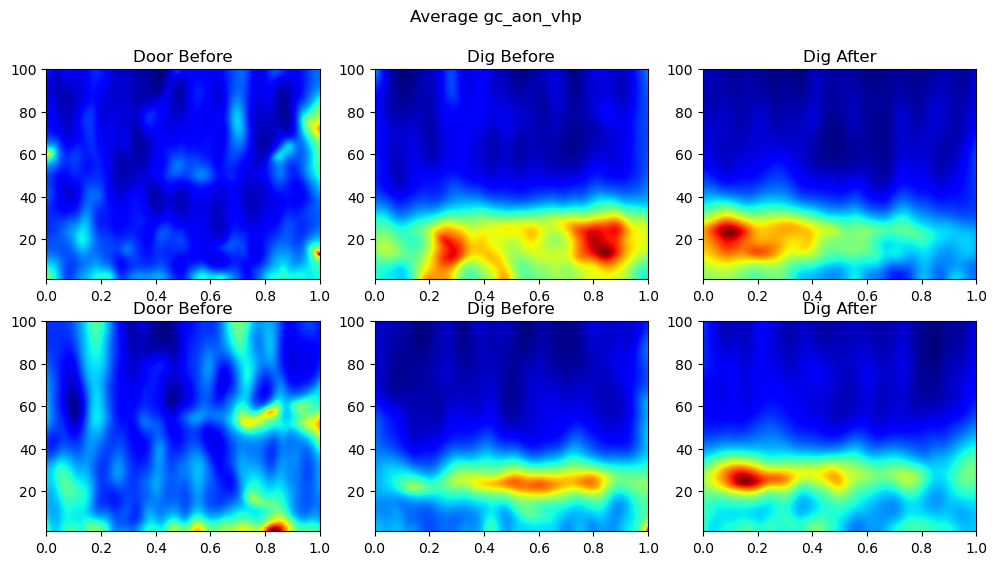

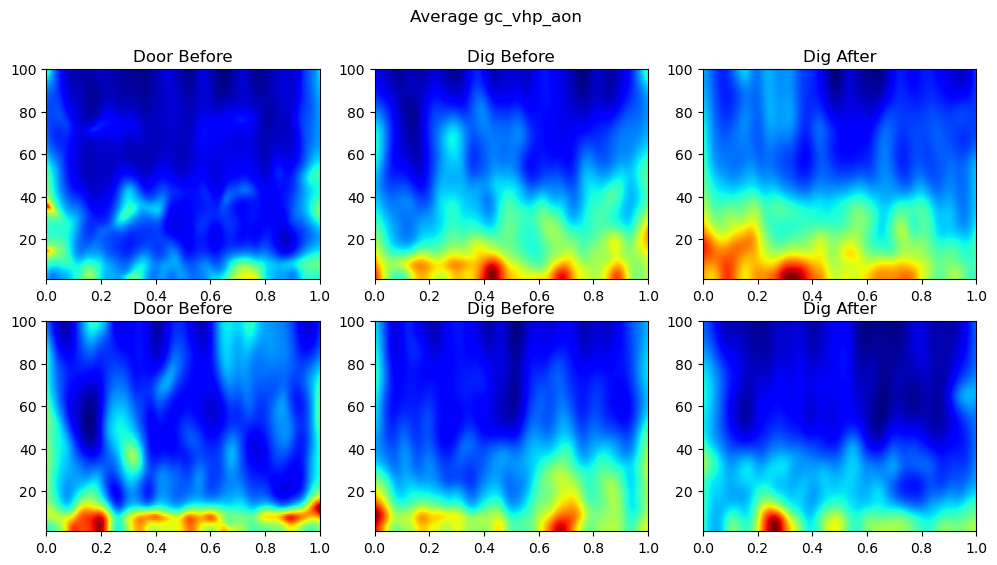

In [25]:

gc_list = ['gc_aon_vhp', 'gc_vhp_aon']#, 'net_gc']
events_dict = {'gc_door_before':'Door Before', 'gc_dig_before': 'Dig Before', 'gc_dig_after' :'Dig After'}

for gc in gc_list:
    fig, axs = plt.subplots(2, 3, figsize=(12, 6))
    fig.suptitle(f'Average {gc}')
    for coli, event in enumerate(events_dict.keys()):
        all_gc_data_df=pd.read_pickle(savepath+f'{event}.pkl')
        
        BWcontext_data=all_gc_data_df[(all_gc_data_df['task']=='BWcontext')]
        BWnocontext_data=all_gc_data_df[(all_gc_data_df['task']=='BWnocontext')]
        
        bw_context_mean=BWcontext_data[gc].mean()
        bw_nocontext_mean=BWnocontext_data[gc].mean()
        #print(bw_context_mean.shape, bw_nocontext_mean.shape)
        vmin = min(bw_context_mean.min(), bw_nocontext_mean.min())
        vmax = max(bw_context_mean.max(), bw_nocontext_mean.max())
        axs[0, coli].imshow(bw_context_mean, extent=[0, 1, 1, 100], aspect='auto', cmap='jet',origin='lower')#, vmin=vmin, vmax=vmax)
        axs[0, coli].set_title(f'{events_dict[event]}')
        axs[1, coli].imshow(bw_nocontext_mean, extent=[0, 1, 1, 100], aspect='auto', cmap='jet',origin='lower')#, vmin=vmin, vmax=vmax)
        axs[1, coli].set_title(f'{events_dict[event]}')
        # for ax in axs:
        #     ax.axvline(0, color='k', linestyle='--', linewidth=2)
        #     ax.axhline(12, color='green', linestyle='--')
        #     ax.axhline(30, color='green', linestyle='--')
    #fig.colorbar(axs[0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
    plt.show()


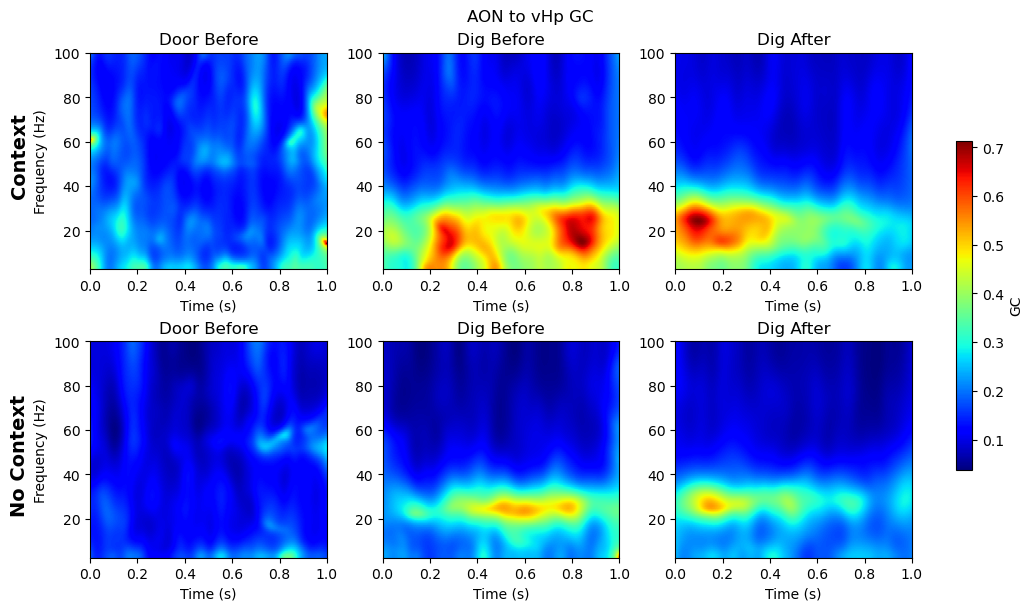

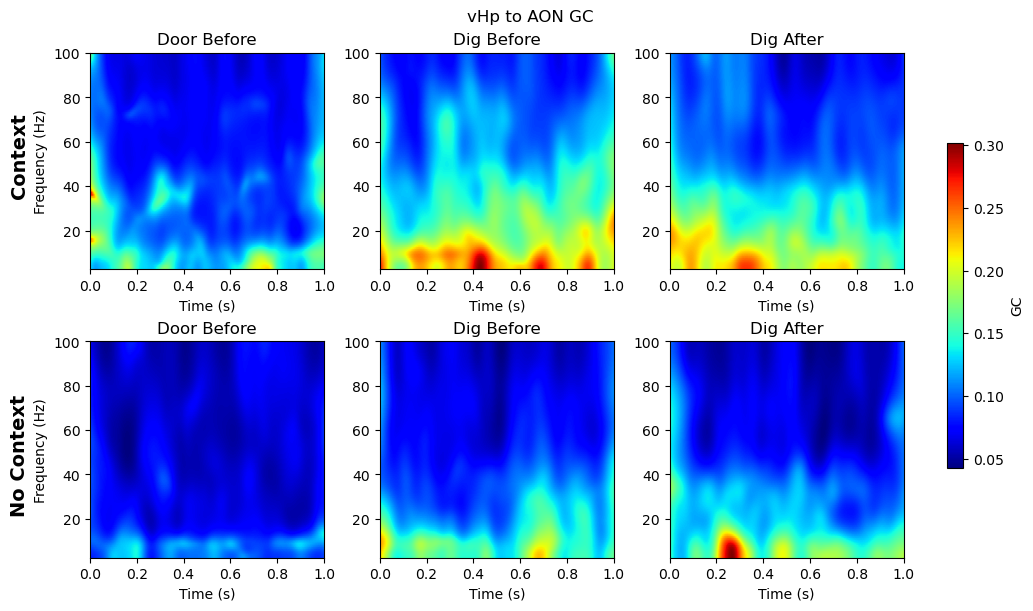

In [36]:
gc_list = {'gc_aon_vhp' :"AON to vHp", 'gc_vhp_aon':"vHp to AON"}#, 'net_gc']
events_dict = {'gc_door_before':'Door Before', 'gc_dig_before': 'Dig Before', 'gc_dig_after' :'Dig After'}
writer = pd.ExcelWriter(savepath+'events_granger_causality_spectrograms.xlsx')
for gc in gc_list.keys():
    
    fig, axs = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True)
    fig.suptitle(f'{gc_list[gc]} GC')
    
    all_data = {}
    
    for coli, event in enumerate(events_dict.keys()):
        all_gc_data_df=pd.read_pickle(savepath+f'{event}.pkl')
        
        BWcontext_data=all_gc_data_df[(all_gc_data_df['task']=='BWcontext')]
        BWnocontext_data=all_gc_data_df[(all_gc_data_df['task']=='BWnocontext')]
        
        bw_context_mean=BWcontext_data[gc].mean()
        bw_nocontext_mean=BWnocontext_data[gc].mean()
        
        # Store data for Excel export
        all_data[f'{events_dict[event]}_context'] = bw_context_mean
        all_data[f'{events_dict[event]}_nocontext'] = bw_nocontext_mean
        
        vmin = min(bw_context_mean.min(), bw_nocontext_mean.min())
        vmax = max(bw_context_mean.max(), bw_nocontext_mean.max())
        
        im0 = axs[0, coli].imshow(bw_context_mean, extent=[0, 1, 2.5, 100], aspect='auto', cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
        axs[0, coli].set_title(f'{events_dict[event]}')
        axs[0, coli].set_xlabel('Time (s)')
        if coli == 0:
            axs[0, coli].set_ylabel('Frequency (Hz)')
        
        im1 = axs[1, coli].imshow(bw_nocontext_mean, extent=[0, 1, 2.5, 100], aspect='auto', cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
        axs[1, coli].set_title(f'{events_dict[event]}')
        axs[1, coli].set_xlabel('Time (s)')
        if coli == 0:
            axs[1, coli].set_ylabel('Frequency (Hz)')
    
    # Add colorbar
    fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label='GC')
    
    # Add row labels
    fig.text(-0.02, 0.75, 'Context', va='center', rotation='vertical', fontsize=14, fontweight='bold')
    fig.text(-0.02, 0.25, 'No Context', va='center', rotation='vertical', fontsize=14, fontweight='bold')
    
    # Save figure
    fig.savefig(savepath+f'gc_events_{gc}_spectrogram.png', format='png', dpi=300, bbox_inches='tight')
    
    # Export data to Excel with frequency and time axes
    for key, data in all_data.items():
        # Create frequency and time arrays
        n_freqs, n_times = data.shape
        frequencies = np.linspace(2.5, 100, n_freqs)
        times = np.linspace(0, 1, n_times)
        
        # Create DataFrame with frequency as index and time as columns
        df = pd.DataFrame(data, index=frequencies, columns=times)
        df.index.name = 'Frequency (Hz)'
        df.columns.name = 'Time (s)'
        
        df.to_excel(writer, sheet_name=f'{gc_list[gc]}_{key}'[:31])
    
    plt.show()
writer.close()

## GC Density

In [ ]:
con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')

# Extract all columns at once using vectorized operations
experiments = con_data_df_clean['experiment'].values
rat_ids = con_data_df_clean['rat_id'].values
tasks = con_data_df_clean['task'].values
events_dict = {'mne_epoch_door_before':'gc_door_before','mne_epoch_dig_before':'gc_dig_before','mne_epoch_dig_after':'gc_dig_after'}


for event in events_dict.keys():

    events_of_interest = con_data_df_clean[event].values  ### CHANGE THIS TO THE DESIRED EVENT

    all_gc_data_real = []
    all_gc_data_shuffled = []
    

    # Iterate only through the length, using vectorized column access
    for i in range(len(con_data_df_clean)):
        experiment = experiments[i]
        rat_id = rat_ids[i]
        task = tasks[i]
        event_of_interest = events_of_interest[i]
        
        print(f'Processing Rat: {rat_id}, Experiment: {experiment}, Task: {task}')
        
        aon_signals = [
            idx
            for idx, ch_info in enumerate(event_of_interest.info["chs"])
            if "AON" in ch_info["ch_name"]
        ]
        
        vhp_signals = [
            idx
            for idx, ch_info in enumerate(event_of_interest.info["chs"])
            if "vHp" in ch_info["ch_name"]
        ]
        
        indices_aon_vhp = (np.array([aon_signals]), np.array([vhp_signals]))
        print(indices_aon_vhp)
        indices_vhp_aon = (np.array([vhp_signals]), np.array([aon_signals]))
        
        event_of_interest = event_of_interest.resample(500)
        event_of_interest_shuffled = event_of_interest.copy()
        event_of_interest_shuffled = coherence_functions.randomize_timepoints(event_of_interest_shuffled)
        
        
        fmin=2.5
        fmax=100
        freqs = np.arange(fmin,fmax)
        n_cycles = freqs/3

        ##### Calculating and appending Real GC


        con_aon_vhp_real = mne_connectivity.spectral_connectivity_epochs(
            event_of_interest, method='gc', sfreq=int(fs), indices=indices_aon_vhp,
            mode='multitaper', mt_bandwidth=2.8, 
            verbose=False, fmin=fmin, fmax=fmax, faverage=False, gc_n_lags=5, rank=None
        )
        
        con_vhp_aon_real = mne_connectivity.spectral_connectivity_epochs(
            event_of_interest, method='gc', sfreq=int(fs), indices=indices_vhp_aon,
           mode='multitaper', mt_bandwidth=2.8,
            verbose=False, fmin=fmin, fmax=fmax, faverage=False, gc_n_lags=5, rank=None
        )
        
        coh_aon_vhp_real = con_aon_vhp_real.get_data()[0, :]
        coh_vhp_aon_real = con_vhp_aon_real.get_data()[0, :]
        
        all_gc_data_real.append([experiment, rat_id, task, coh_aon_vhp_real, coh_vhp_aon_real])
        
        ##### Calculating and appending Shuffled GC
        
        con_aon_vhp_shuffled = mne_connectivity.spectral_connectivity_epochs(
            event_of_interest_shuffled, method='gc', sfreq=int(fs), indices=indices_aon_vhp,
            mode='multitaper', mt_bandwidth=2.8, 
            verbose=False, fmin=fmin, fmax=fmax, faverage=False, gc_n_lags=5, rank=None
        )
        
        con_vhp_aon_shuffled = mne_connectivity.spectral_connectivity_epochs(
            event_of_interest_shuffled, method='gc', sfreq=int(fs), indices=indices_vhp_aon,
           mode='multitaper', mt_bandwidth=2.8,
            verbose=False, fmin=fmin, fmax=fmax, faverage=False, gc_n_lags=5, rank=None
        )
        
        coh_aon_vhp_shuffled = con_aon_vhp_shuffled.get_data()[0, :]
        coh_vhp_aon_shuffled = con_vhp_aon_shuffled.get_data()[0, :]
        
        all_gc_data_shuffled.append([experiment, rat_id, task, coh_aon_vhp_shuffled, coh_vhp_aon_shuffled])


    all_gc_data_df = pd.DataFrame(all_gc_data_real, columns=['experiment', 'rat_id', 'task', 'gc_aon_vhp', 'gc_vhp_aon'])
    all_gc_data_df.to_pickle(savepath+f'{events_dict[event]}_density.pkl')

    all_gc_data_df_shuffled = pd.DataFrame(all_gc_data_shuffled, columns=['experiment', 'rat_id', 'task', 'gc_aon_vhp', 'gc_vhp_aon'])
    all_gc_data_df_shuffled.to_pickle(savepath+f'{events_dict[event]}_density_shuffled.pkl')

### Plotting Avg GC density

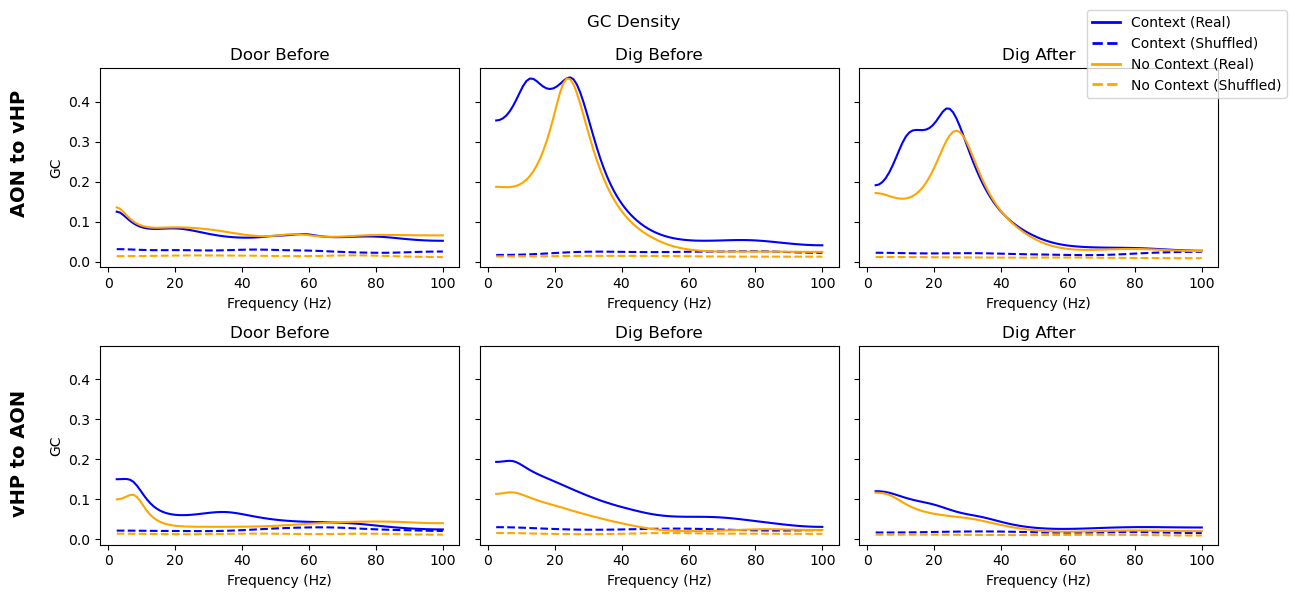

In [23]:
gc_list = {'gc_aon_vhp':'red', 'gc_vhp_aon':'blue'}#, 'net_gc']
events_dict = {'gc_door_before_density':'Door Before', 'gc_dig_before_density': 'Dig Before', 'gc_dig_after_density' :'Dig After'}
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
fig.suptitle(f'GC Density')
writer=pd.ExcelWriter(savepath+'events_granger_causality_density.xlsx')
for coli, event in enumerate(events_dict.keys()):
    all_gc_data_df=pd.read_pickle(savepath+f'{event}.pkl')
    all_gc_data_df_shuffled=pd.read_pickle(savepath+f'{event}_shuffled.pkl')
    
    gc_density_dict={}
        
    BWcontext_data_real_df=all_gc_data_df[(all_gc_data_df['task']=='BWcontext')]
    BWnocontext_data_real_df=all_gc_data_df[(all_gc_data_df['task']=='BWnocontext')]
    BWcontext_data_shuffled_df=all_gc_data_df_shuffled[(all_gc_data_df_shuffled['task']=='BWcontext')]
    BWnocontext_data_shuffled_df=all_gc_data_df_shuffled[(all_gc_data_df_shuffled['task']=='BWnocontext')]
    
    for rowi,gc in enumerate(gc_list.keys()):
        
        BWcontext_data_real=np.vstack(BWcontext_data_real_df[gc].to_numpy())
        BWnocontext_data_real=np.vstack(BWnocontext_data_real_df[gc].to_numpy())
        BWcontext_data_shuffled=np.vstack(BWcontext_data_shuffled_df[gc].to_numpy())
        BWnocontext_data_shuffled=np.vstack(BWnocontext_data_shuffled_df[gc].to_numpy())
        
        bw_context_mean_real=np.mean(BWcontext_data_real, axis=0)
        bw_nocontext_mean_real=np.mean(BWnocontext_data_real, axis=0)
        bw_context_mean_shuffled=np.mean(BWcontext_data_shuffled, axis=0)
        bw_nocontext_mean_shuffled=np.mean(BWnocontext_data_shuffled, axis=0)
        bw_context_std_real=np.std(BWcontext_data_real, axis=0)
        bw_nocontext_std_real=np.std(BWnocontext_data_real, axis=0)
        bw_context_std_shuffled=np.std(BWcontext_data_shuffled, axis=0)
        bw_nocontext_std_shuffled=np.std(BWnocontext_data_shuffled, axis=0)
        freqs = np.linspace(2.5,100,len(bw_context_mean_real))
        axs[rowi, coli].plot(freqs, bw_context_mean_real, label='Context Real', color='blue')
        axs[rowi, coli].plot(freqs, bw_context_mean_shuffled, label='Context Shuffled', color='blue', linestyle='dashed')
        axs[rowi, coli].plot(freqs, bw_nocontext_mean_real, label='No Context Real', color='orange')
        axs[rowi, coli].plot(freqs, bw_nocontext_mean_shuffled, label='No Context Shuffled', color='orange', linestyle='dashed')
        axs[rowi, coli].set_title(f'{events_dict[event]}')
        axs[rowi, coli].set_xlabel('Frequency (Hz)')
        if coli == 0:
            axs[rowi, coli].set_ylabel('GC')
        
        gc_density_dict.update({
            f'real_{gc}_bwcontext_mean': bw_context_mean_real,
            f'real_{gc}_bwcontext_sem': bw_context_std_real,
            f'real_{gc}_bwnocontext_mean': bw_nocontext_mean_real,
            f'real_{gc}_bwnocontext_sem': bw_nocontext_std_real,
            f'shuffled_{gc}_bwcontext_mean': bw_context_mean_shuffled,
            f'shuffled_{gc}_bwcontext_sem': bw_context_std_shuffled,
            f'shuffled_{gc}_bwnocontext_mean': bw_nocontext_mean_shuffled,
            f'shuffled_{gc}_bwnocontext_sem': bw_nocontext_std_shuffled,
        })
    gc_density_dict['freqs'] = freqs
    gc_density_df = pd.DataFrame(gc_density_dict)
    gc_density_df.to_excel(writer, sheet_name=events_dict[event])

fig.text(-0.02, 0.75, 'AON to vHP', va='center', rotation='vertical', fontsize=14, fontweight='bold')
fig.text(-0.02, 0.25, 'vHP to AON', va='center', rotation='vertical', fontsize=14, fontweight='bold')

writer.close()
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color='blue', lw=2),
           Line2D([0], [0], color='blue', linestyle='dashed', lw=2),
           Line2D([0], [0], color='orange', lw=2),
           Line2D([0], [0], color='orange', linestyle='dashed', lw=2)]
labels = ['Context (Real)', 'Context (Shuffled)', 'No Context (Real)', 'No Context (Shuffled)']

fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
fig.savefig(savepath+'gc_events_density.png', format='png', dpi=300, bbox_inches = 'tight')
plt.show()

## GC Boxplot

In [5]:
all_gc_data_df=pd.read_pickle(savepath+f'gc_door_before_density.pkl')

def get_band_gc(data_array, band_start, band_end):
    freq_axs = np.linspace(2.5, 100, len(data_array))
    band_data = data_array[(freq_axs >= band_start) & (freq_axs <= band_end)]
    power_sum = np.sum(band_data)
    freq_diff = freq_axs[1] - freq_axs[0]
    return power_sum * freq_diff

test_data = all_gc_data_df['gc_aon_vhp'].iloc[0]

beta_gc = get_band_gc(test_data, 12, 30)
print(beta_gc)

bands_dict = {'beta': [12, 30], 'gamma': [30, 80],'theta':[4,12], 'total': [1, 100]}
for band, (band_start, band_end) in bands_dict.items():
    all_gc_data_df[f'{band}_aon_to_vhp'] = all_gc_data_df['gc_aon_vhp'].apply(lambda x: get_band_gc(x, band_start, band_end))
    all_gc_data_df[f'{band}_vhp_to_aon'] = all_gc_data_df['gc_vhp_aon'].apply(lambda x: get_band_gc(x, band_start, band_end))

all_gc_data_df=all_gc_data_df.drop(columns=['gc_aon_vhp', 'gc_vhp_aon'])

event_df_melted = pd.melt(all_gc_data_df, id_vars=['experiment', 'rat_id', 'task'], var_name='band', value_name='gc')
split_cols = event_df_melted['band'].str.split('_', n=1, expand=True)
event_df_melted['band'] = split_cols[0]
event_df_melted['direction'] = split_cols[1]
event_df_melted['data_type'] = 'real'

2.556151404609524


gc_door_before_density Door Before
gc_dig_before_density Dig Before
gc_dig_after_density Dig After


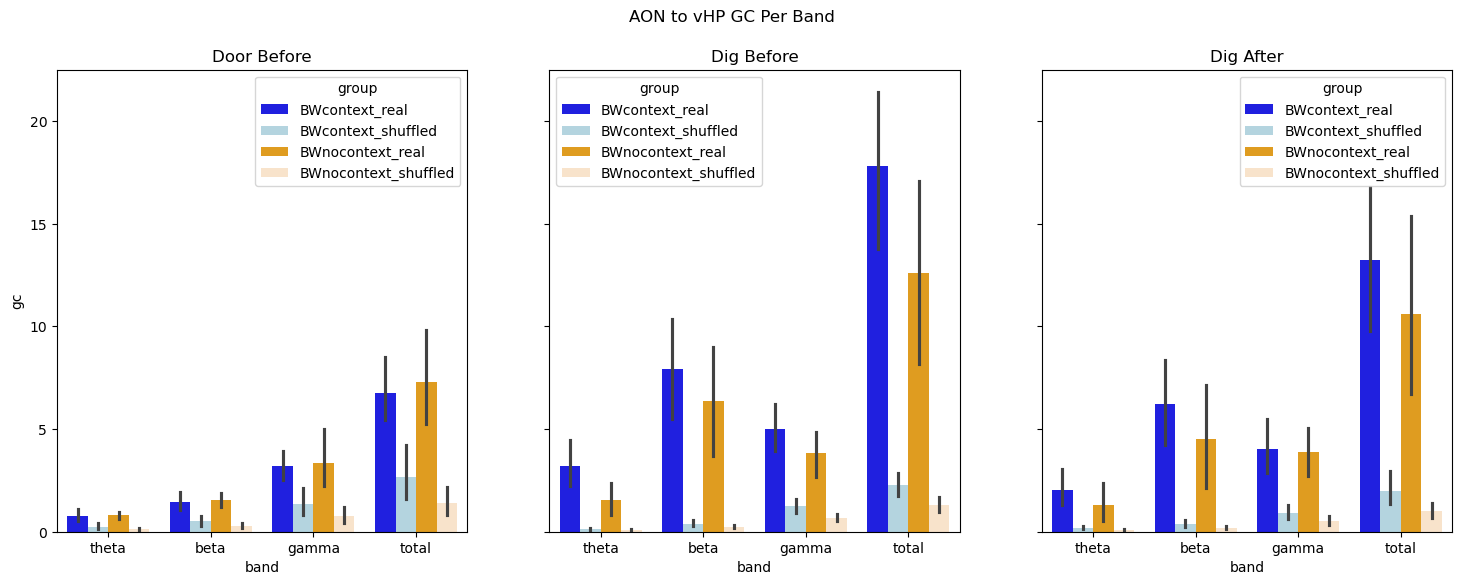

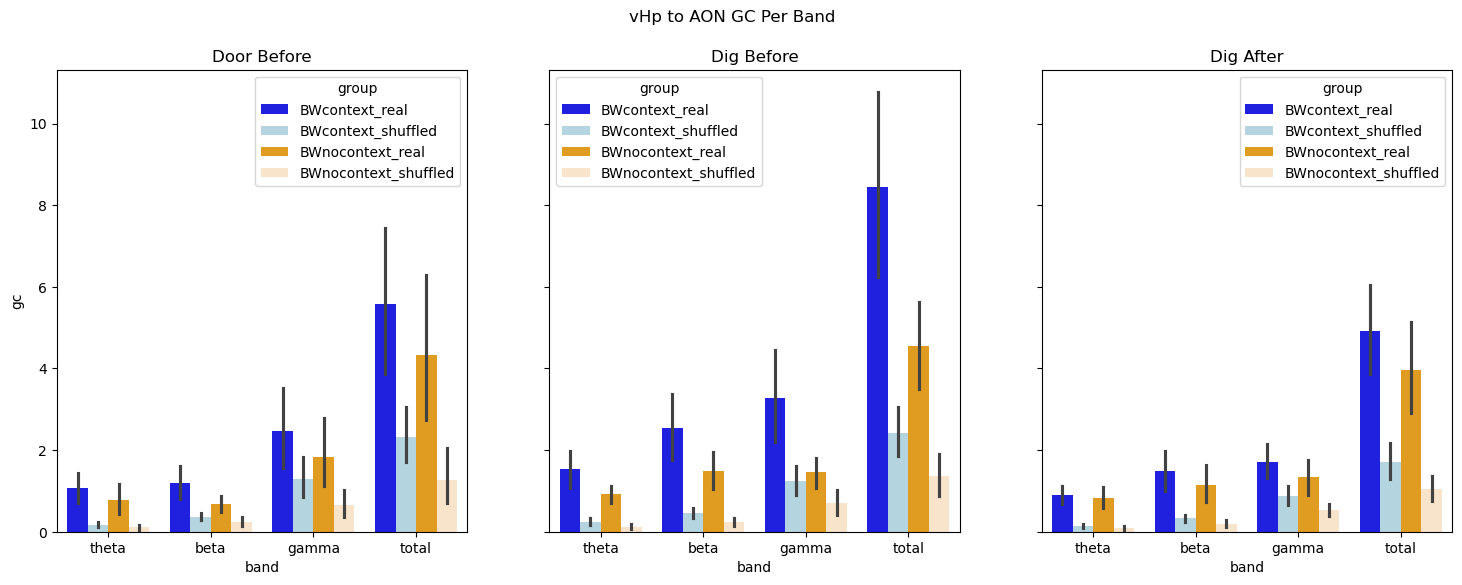

In [31]:
gc_list = {'gc_aon_vhp':'red', 'gc_vhp_aon':'blue'}#, 'net_gc']
events_dict = {'gc_door_before_density':'Door Before', 'gc_dig_before_density': 'Dig Before', 'gc_dig_after_density' :'Dig After'}
bands_dict = {'beta': [12, 30], 'gamma': [30, 80],'theta':[4,12], 'total': [2.5, 100]}

fig1, axs1 = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig1.suptitle(f'AON to vHP GC Per Band')

fig2, axs2 = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig2.suptitle(f'vHp to AON GC Per Band')

data_type_suffix_dict ={'real':'','shuffled':'_shuffled'}

writer=pd.ExcelWriter(savepath+'events_granger_causality_perband.xlsx')

for coli, (file_name, event_name) in enumerate(events_dict.items()):
    print(file_name, event_name)
    event_df = []
    for (data_type, suffix) in data_type_suffix_dict.items():
        all_gc_data_df=pd.read_pickle(savepath+f'{file_name}{suffix}.pkl')
        for band, (band_start, band_end) in bands_dict.items():
            
            all_gc_data_df[f'{band}_aon_to_vhp'] = all_gc_data_df['gc_aon_vhp'].apply(lambda x: get_band_gc(x, band_start, band_end))
            all_gc_data_df[f'{band}_vhp_to_aon'] = all_gc_data_df['gc_vhp_aon'].apply(lambda x: get_band_gc(x, band_start, band_end))
            
        all_gc_data_df=all_gc_data_df.drop(columns=['gc_aon_vhp', 'gc_vhp_aon'])
        event_df_melted = pd.melt(all_gc_data_df, id_vars=['experiment', 'rat_id', 'task'], var_name='band', value_name='gc')
        split_cols = event_df_melted['band'].str.split('_', n=1, expand=True)
        event_df_melted['band'] = split_cols[0]
        event_df_melted['direction'] = split_cols[1]
        event_df_melted['data_type'] = data_type
        col_data = event_df_melted.pop('gc')
        event_df_melted['gc'] = col_data        
        event_df.append(event_df_melted)
        
    combined_df = pd.concat(event_df)
    combined_df.to_excel(writer, sheet_name = event_name)
    combined_df['group'] = combined_df['task'] + '_' + combined_df['data_type']
    
    hue_order = ['BWcontext_real', 'BWcontext_shuffled', 'BWnocontext_real', 'BWnocontext_shuffled']
    palette = {'BWcontext_real': 'blue', 'BWcontext_shuffled': 'lightblue', 
           'BWnocontext_real': 'orange', 'BWnocontext_shuffled': 'bisque'}
    band_order = ['theta', 'beta', 'gamma','total']
    ax1=axs1[coli]
    ax2=axs2[coli]

    ax1.set_title(f'{event_name}')
    ax2.set_title(f'{event_name}')

    sns.barplot(x='band', y='gc', hue='group',order=band_order, hue_order=hue_order,
    palette=palette,data=combined_df[combined_df['direction']=='aon_to_vhp'], ax=ax1)
    
    sns.barplot(x='band', y='gc', hue='group',order=band_order, hue_order=hue_order,
    palette=palette,data=combined_df[combined_df['direction']=='vhp_to_aon'], ax=ax2)

fig1.savefig(savepath + 'gc_events_aon_to_vhp_perband.png', format='png', dpi=300, bbox_inches ='tight')
fig2.savefig(savepath + 'gc_events_vhp_to_aon_perband.png', format='png', dpi=300, bbox_inches ='tight')

writer.close()

## [NOT USED]

In [ ]:
all_gc_data_df = pd.read_pickle(savepath+'gc_around_dig.pkl')

for row in all_gc_data_df.itertuples(index=False):
    experiment = row.experiment
    rat_id = row.rat_id
    task = row.task
    gc_aon_vhp = row.gc_aon_vhp
    gc_vhp_aon = row.gc_vhp_aon
    net_gc = gc_aon_vhp - gc_vhp_aon
    vmin = min(gc_aon_vhp.min(), gc_vhp_aon.min(), net_gc.min())
    vmax = max(gc_aon_vhp.max(), gc_vhp_aon.max(), net_gc.max())
    print(f'Processing Rat: {rat_id}, Experiment: {experiment}, Task: {task}')
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    fig.suptitle(f'Granger Causality Rat: {rat_id}, Experiment: {experiment}, Task: {task}', fontsize=20)

    im = axs[0].imshow(gc_aon_vhp, extent=[-0.7, 0.7, 1, 100], aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0].set_title('AON -> vHp')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Frequency (Hz)')
    
    axs[1].imshow(gc_vhp_aon, extent=[-0.7, 0.7, 1, 100], aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1].set_title('vHp -> AON')
    axs[1].set_xlabel('Time (s)')

    axs[2].imshow(net_gc, extent=[-0.7, 0.7, 1, 100], aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[2].set_title('Difference (AON -> vHp) - (vHp -> AON)')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Frequency (Hz)')

    for ax in axs:
        ax.axvline(0, color='k', linestyle='--', linewidth=2)
        ax.axhline(12, color='green', linestyle='--')
        ax.axhline(30, color='green', linestyle='--')
    # Create a common colorbar for all three subplots
    # Remove the previous imshow call for axs[2] above, use this one for colorbar
    cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02)
    #plt.tight_layout()
    #plt.savefig(savepath + f'{task}_{rat_id}_{experiment}_gc_around_dig.png', dpi=300)
    plt.show()

In [ ]:
con_data_df_clean=pd.read_pickle(savepath+'mne_epochs_array_df.pkl')

event_list=['mne_epoch_around_door','mne_epoch_around_dig']

print(event_list)
BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

rat_list=np.unique(con_data_df_clean['rat_id'])
print(rat_list)
all_con_data=[]
all_con_data_mean=[]
for task_num,task_name in enumerate(task_data_dict.keys()):
        task_data=task_data_dict[task_name]
    #print(task_name)
    # for rat_num, rat_name in enumerate(rat_list):
    #     rat_task_data=task_data[task_data['rat_id']==rat_name]
        row=[task_name]
    #     #print(row)
        row_2=[task_name]
        for event in event_list:
            #print(event)
            event_epoch_list=task_data[event]
            aon_vHp_con=[]
            for event_epoch in event_epoch_list:
                    #print(row,event, event_epoch) 
                    fmin=1
                    fmax=100
                    freqs = np.arange(fmin,fmax)
                    n_cycles = freqs/2
                    
                    ###Specifying the Indices for AON and vHp channels
                    aon_signals=[
                    idx
                    for idx, ch_info in enumerate(event_epoch.info["chs"])
                    if "AON" in ch_info["ch_name"]
                    ]
                    print(aon_signals)
                    vhp_signals=[
                        idx
                        for idx, ch_info in enumerate(event_epoch.info["chs"])
                        if "vHp" in ch_info["ch_name"]
                    ]
                    print(vhp_signals)

                    indices_aon_vhp = (np.array([aon_signals]), np.array([vhp_signals]))
                    indices_vhp_aon = (np.array([vhp_signals]), np.array([aon_signals]))      
                    gc_ab = mne_connectivity.spectral_connectivity_epochs(event_epoch, method=["gc"], indices=indices_aon_vhp, fmin=2.5, fmax=100, rank=None,gc_n_lags=20)
                    gc_ba= mne_connectivity.spectral_connectivity_epochs(event_epoch, method=["gc"], indices=indices_vhp_aon, fmin=2.5, fmax=100, rank=None,gc_n_lags=20)
                    net_gc= gc_ab.get_data() - gc_ba.get_data()
                    print(net_gc.shape)

                    coh = net_gc[0]
                    #coh=np.abs(coh)
                    print(coh.shape)
                    indices = coh.names
                    print(indices)

                    for i in range(coh.shape[0]):
                        for j in range(coh.shape[1]):
                            if 'AON' in indices[j] and 'vHp' in indices[i]:
                                aon_vHp_con.append(coh[i,j,:,:])
            row.append(np.mean(aon_vHp_con, axis=0))
            row_2.append(np.mean(aon_vHp_con))
        all_con_data.append(row)                    
        all_con_data_mean.append(row_2)
# Convert all_con_data to a DataFrame for easier manipulation
all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)
#all_con_data_df.to_pickle(savepath+'coherence_spectrogram_around_door_dig.pkl')
fs=2000
event_list=['mne_epoch_around_door','mne_epoch_around_dig']
fs=2000
times=np.arange(-2, 2, 1/fs)
fig, axs=plt.subplots(2,2, figsize=(20,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Around Door','Around Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('')

    axs[0,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[0,i].set_title(event_names[i], fontsize=20)
    axs[0,i].vlines(0, 0, 100, color='k', linestyle='--')
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)', fontsize=20)
    axs[1,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[1,i].set_title(event_names[i], fontsize=20)
    axs[1,i].vlines(0, 0, 100, color='k', linestyle='--')

    axs[0,0].text(-0.2, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.2, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    axs[1,i].tick_params(axis='both', which='major', labelsize=20)
    axs[0,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    axs[0,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds
    axs[1,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    axs[1,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds

    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence', loc='center', fontsize=20, labelpad=10)
cbar.ax.tick_params(labelsize=20)  # Set colorbar tick label size

#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\aon_vhp_coherence_event_spectrogram.png',format='png', dpi=600, bbox_inches='tight')
plt.show()


## Calculating complex coherence values

### Truncated Coherence with Quiver

In [ ]:
#################
time_window = 1
fs=2000
#################
con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')
#con_data_df_clean=pd.read_pickle(savepath+f'mne_epochs_array_df_shuffled_truncated_{int(time_window*fs)}.pkl')

In [ ]:

event_list=['mne_epoch_door_before', 'mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig']
fs=2000

shuffled = True


importlib.reload(lfp_pre_processing_functions)
print(event_list)
BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

rat_list=np.unique(con_data_df_clean['rat_id'])
print(rat_list)
all_coh_abs_data=[]
all_coh_abs_data_mean=[]
all_coh_phase_data=[]
all_coh_phase_data_mean=[]
ind_rows_df=[]
for task_num,task_name in enumerate(task_data_dict.keys()):
        task_data=task_data_dict[task_name]
    #print(task_name)
    # for rat_num, rat_name in enumerate(rat_list):
    #     rat_task_data=task_data[task_data['rat_id']==rat_name]
        row_coh_abs=[task_name]
        row_coh_abs_mean=[task_name]
        row_coh_phase=[task_name]
        row_coh_phase_mean=[task_name]

        for event in event_list:
            #print(event)
            event_epoch_list=task_data[event]
            rat_id_list=task_data['rat_id']
            exp_list=task_data['experiment']
            
            aon_vhp_coh_abs=[]
            aon_vhp_coh_phase=[]
            for rowi,event_epoch in enumerate(event_epoch_list):
                    #print(row,event, event_epoch) 
                    rat_id=rat_id_list.iloc[rowi]
                    experiment=exp_list.iloc[rowi]
                    print(f'Processing Rat: {rat_id}, Experiment: {experiment}, Task: {task_name}, Event: {event}')
                    fmin=1
                    fmax=100
                    freqs = np.arange(fmin,fmax)
                    n_cycles = freqs/3

                    if shuffled:
                        event_epoch = lfp_pre_processing_functions.randomize_timepoints(event_epoch)
                        suffix = "_shuffled"
                    else:
                        event_epoch=event_epoch
                        suffix = ""
                    con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='cohy', sfreq=int(fs),
                                                         mode='cwt_morlet', cwt_freqs=freqs,
                                                         cwt_n_cycles=n_cycles, verbose=False, fmin=1, fmax=100, faverage=False)
                    coh = con.get_data(output='dense')
                    coh_abs = np.abs(coh)
                    coh_phase = np.angle(coh)

                    indices = con.names
                    print(indices)
                    print(coh.shape)
                    print(coh_abs.shape)
                    print(coh_phase.shape)

                    for i in range(coh.shape[0]):
                        for j in range(coh.shape[1]):
                            if 'AON' in indices[j] and 'vHp' in indices[i]:
                                coherence_abs=coh_abs[i,j,:,:]
                                coherence_abs=np.arctanh(coherence_abs)  # Apply Fisher transformation
                                aon_vhp_coh_abs.append(coherence_abs)
                                aon_vhp_coh_phase.append(coh_phase[i,j,:,:])
                                ind_row =[rat_id, experiment, task_name, event, f'{indices[j]}-{indices[i]}', coh_phase[i,j,:,:]]

                                ind_rows_df.append(ind_row)

            row_coh_abs.append(np.mean(aon_vhp_coh_abs, axis=0))
            row_coh_abs_mean.append(np.mean(aon_vhp_coh_abs))
            row_coh_phase.append(np.mean(aon_vhp_coh_phase, axis=0))
            row_coh_phase_mean.append(np.mean(aon_vhp_coh_phase))
        all_coh_abs_data.append(row_coh_abs)
        all_coh_abs_data_mean.append(row_coh_abs_mean)
        all_coh_phase_data.append(row_coh_phase)
        all_coh_phase_data_mean.append(row_coh_phase_mean)
        
ind_rows_df = pd.DataFrame(ind_rows_df, columns=['rat_id', 'experiment', 'task', 'event', 'channel_pair', 'coherence_phase'])


ind_rows_df.to_pickle(savepath+f'coherence_phase_individual_epochs_around_door_dig{suffix}_truncated_{int(time_window*fs)}.pkl')

all_coh_abs_data_df = pd.DataFrame(all_coh_abs_data, columns=['task'] + event_list)
all_coh_abs_data_df.to_pickle(savepath+f'coherence_abs_spectrogram_around_door_dig{suffix}_truncated_{int(time_window*fs)}.pkl')

all_coh_phase_data_df = pd.DataFrame(all_coh_phase_data, columns=['task'] + event_list)
all_coh_phase_data_df.to_pickle(savepath+f'coherence_phase_spectrogram_around_door_dig{suffix}_truncated_{int(time_window*fs)}.pkl')


fs=2000

In [ ]:
test = aon_vhp_coh_phase[0]
print(test.shape)

In [ ]:
time_window = 1
fs=2000


fmin = 12
fmax = 30
tmin = 0.5
tmax = 0.9


all_coh_phase_data_df_shuffled=pd.read_pickle(savepath+f'coherence_phase_spectrogram_around_door_dig_shuffled_truncated_{int(time_window*fs)}.pkl')
all_coh_phase_data_df_real=pd.read_pickle(savepath+f'coherence_phase_spectrogram_around_door_dig_truncated_{int(time_window*fs)}.pkl')



import numpy as np
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt

# Extract phase data for each condition

truncated_phase_data_real = all_coh_phase_data_df_real['mne_epoch_around_dig'].apply(lambda x: x[fmin:fmax, int(tmin*fs):int(tmax*fs)])  # Theta band (8-12 Hz) and time window (0 to 0.4s)

# phase_context = np.array(all_coh_phase_data_df.loc[all_coh_phase_data_df['task'] == 'BWcontext', 'mne_epoch_around_dig'].iloc[0]).flatten()
# phase_nocontext = np.array(all_coh_phase_data_df.loc[all_coh_phase_data_df['task'] == 'BWnocontext', 'mne_epoch_around_dig'].iloc[0]).flatten()
phase_context = np.array(truncated_phase_data_real[all_coh_phase_data_df_real['task'] == 'BWcontext'].iloc[0]).flatten()
phase_nocontext = np.array(truncated_phase_data_real[all_coh_phase_data_df_real['task'] == 'BWnocontext'].iloc[0]).flatten()

truncated_phase_data_shuffled = all_coh_phase_data_df_shuffled['mne_epoch_around_dig'].apply(lambda x: x[fmin:fmax, int(tmin*fs):int(tmax*fs)])  # Theta band (8-12 Hz) and time window (0 to 0.4s)
phase_context_shuffled = np.array(truncated_phase_data_shuffled[all_coh_phase_data_df_shuffled['task'] == 'BWcontext'].iloc[0]).flatten()
phase_nocontext_shuffled = np.array(truncated_phase_data_shuffled[all_coh_phase_data_df_shuffled['task'] == 'BWnocontext'].iloc[0]).flatten()

# Convert phase to [0, 2pi]
phase_context = np.mod(phase_context, 2 * np.pi)
phase_nocontext = np.mod(phase_nocontext, 2 * np.pi)

phase_context_shuffled = np.mod(phase_context_shuffled, 2 * np.pi)
phase_nocontext_shuffled = np.mod(phase_nocontext_shuffled, 2 * np.pi)

fig, axs = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 6))
axs=axs.flatten()
colors = {'BWcontext': 'blue', 'BWnocontext': 'orange'}

# Plot BW Context
axs[0].hist(phase_context, bins=100, density=True, color=colors['BWcontext'], alpha=0.7)
axs[0].set_title('Phase Difference Histogram\nBW Context', fontsize=16)
axs[0].set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
axs[0].set_xlim(0, 2 * np.pi)

# Plot BW No Context
axs[1].hist(phase_nocontext, bins=100, density=True, color=colors['BWnocontext'], alpha=0.7)
axs[1].set_title('Phase Difference Histogram\nBW No Context', fontsize=16)
axs[1].set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
axs[1].set_xlim(0, 2 * np.pi)

axs[2].hist(phase_context_shuffled, bins=100, density=True, color=colors['BWcontext'], alpha=0.7)
axs[2].set_title('Phase Difference Histogram (Shuffled)\nBW Context', fontsize=16)
axs[2].set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
axs[2].set_xlim(0, 2 * np.pi)

axs[3].hist(phase_nocontext_shuffled, bins=100, density=True, color=colors['BWnocontext'], alpha=0.7)
axs[3].set_title('Phase Difference Histogram (Shuffled)\nBW No Context', fontsize=16)
axs[3].set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
axs[3].set_xlim(0, 2 * np.pi)


plt.tight_layout()
fig.savefig(savepath+f'coherence_phase_histogram_around_dig_truncated_{int(time_window*fs)}.png', dpi=300, bbox_inches='tight')
plt.show()
# Statistical test for difference in phase distributions between tasks

# Use the Kolmogorov-Smirnov test to compare the two phase distributions
ks_stat, p_value = ks_2samp(phase_context, phase_nocontext)
print(f"KS statistic: {ks_stat:.4f}, p-value: {p_value:.4e}")

if p_value < 0.05:
    print("There is a significant difference between the phase distributions of the two tasks.")
else:
    print("No significant difference between the phase distributions of the two tasks.")

### Making the polar plot but without averaging across experiments

In [ ]:
time_window = 1
fs=2000


fmin = 30 
fmax = 80
tmin = 0.4
tmax = 0.7


# all_coh_phase_data_df_shuffled=pd.read_pickle(savepath+f'coherence_phase_spectrogram_around_door_dig_shuffled_truncated_{int(time_window*fs)}.pkl')
# all_coh_phase_data_df_real=pd.read_pickle(savepath+f'coherence_phase_spectrogram_around_door_dig_truncated_{int(time_window*fs)}.pkl')

all_coh_phase_data_df_shuffled=pd.read_pickle(savepath+f'coherence_phase_individual_epochs_around_door_dig_shuffled_truncated_{int(time_window*fs)}.pkl')
all_coh_phase_data_df_real=pd.read_pickle(savepath+f'coherence_phase_individual_epochs_around_door_dig_truncated_{int(time_window*fs)}.pkl')


import numpy as np
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt

# Extract phase data for each condition
writer = pd.ExcelWriter(savepath+f'coherence_phase_analysis_around_door_dig_truncated_{int(time_window*fs)}.xlsx')
bands_dict = {
    'Theta': (4, 8),
    'Beta': (12, 30),
    'Gamma': (30, 80)
}

for band_name, (fmin, fmax) in bands_dict.items():
    all_coh_phase_data_df_shuffled=pd.read_pickle(savepath+f'coherence_phase_individual_epochs_around_door_dig_shuffled_truncated_{int(time_window*fs)}.pkl')
    all_coh_phase_data_df_real=pd.read_pickle(savepath+f'coherence_phase_individual_epochs_around_door_dig_truncated_{int(time_window*fs)}.pkl')

    all_coh_phase_data_df_real['coherence_phase'] = all_coh_phase_data_df_real['coherence_phase'].apply(lambda x: x[fmin:fmax, int(tmin*fs):int(tmax*fs)])  # Theta band (8-12 Hz) and time window (0 to 0.4s)

    all_coh_phase_data_df_real['coherence_phase'] = all_coh_phase_data_df_real['coherence_phase'].apply(lambda x: x.flatten())  # Theta band (8-12 Hz) and time window (0 to 0.4s)

    bw_context_data = all_coh_phase_data_df_real[(all_coh_phase_data_df_real['task'] == 'BWcontext') & (all_coh_phase_data_df_real['event']=='mne_epoch_around_dig')]
    phase_context = np.array([value for lst in bw_context_data['coherence_phase'] for value in lst]).flatten()

    bw_nocontext_data = all_coh_phase_data_df_real[(all_coh_phase_data_df_real['task'] == 'BWnocontext') & (all_coh_phase_data_df_real['event']=='mne_epoch_around_dig')]
    phase_nocontext = np.array([value for lst in bw_nocontext_data['coherence_phase'] for value in lst]).flatten()


    all_coh_phase_data_df_shuffled['coherence_phase'] = all_coh_phase_data_df_shuffled['coherence_phase'].apply(lambda x: x[fmin:fmax, int(tmin*fs):int(tmax*fs)])  # Theta band (8-12 Hz) and time window (0 to 0.4s)
    all_coh_phase_data_df_shuffled['coherence_phase'] = all_coh_phase_data_df_shuffled['coherence_phase'].apply(lambda x: x.flatten())  # Theta band (8-12 Hz) and time window (0 to 0.4s)
    bw_context_data_shuffled = all_coh_phase_data_df_shuffled[(all_coh_phase_data_df_shuffled['task'] == 'BWcontext') & (all_coh_phase_data_df_shuffled['event']=='mne_epoch_around_dig')]
    phase_context_shuffled = np.array([value for lst in bw_context_data_shuffled['coherence_phase'] for value in lst]).flatten()


    bw_nocontext_data_shuffled = all_coh_phase_data_df_shuffled[(all_coh_phase_data_df_shuffled['task'] == 'BWnocontext') & (all_coh_phase_data_df_shuffled['event']=='mne_epoch_around_dig')]
    phase_nocontext_shuffled = np.array([value for lst in bw_nocontext_data_shuffled['coherence_phase'] for value in lst]).flatten()


    # Convert phase to [0, 2pi]
    phase_context = np.mod(phase_context, 2 * np.pi)
    phase_nocontext = np.mod(phase_nocontext, 2 * np.pi)

    phase_context_shuffled = np.mod(phase_context_shuffled, 2 * np.pi)
    phase_nocontext_shuffled = np.mod(phase_nocontext_shuffled, 2 * np.pi)

    fig, axs = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 6))
    fig.suptitle('Coherence Phase Freq - {}-{} Hz, Time - {}-{} s'.format(fmin, fmax, tmin, tmax), fontsize=16)
    axs=axs.flatten()
    colors = {'BWcontext': 'black', 'BWnocontext': 'grey'}

    # Plot BW Context
    axs[0].hist(phase_context, bins=100, density=True, color=colors['BWcontext'], alpha=0.7)
    axs[0].set_title('Context', fontsize=16)
    axs[0].set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
    axs[0].set_xlim(0, 2 * np.pi)
    counts, edges = np.histogram(phase_context, bins=100, range=(0, 2*np.pi))

    # 5. Get bin centers
    # This is the Python/NumPy way to find the midpoint of each bin
    locs = (edges[:-1] + edges[1:]) / 2
    closed_locs = np.append(locs, locs[0])
    closed_counts = np.append(counts, counts[0])
    # 6. Plot the line (MATLAB: plot(locs, counts, 'LineWidth', 3);)
    axs[0].plot(closed_locs, closed_counts, 'black', linewidth=1, label='Bin Centers Line') # 'r-' adds color

    # Plot BW No Context
    axs[1].hist(phase_nocontext, bins=100, density=True, color=colors['BWnocontext'], alpha=0.7)
    axs[1].set_title('No Context', fontsize=16)
    axs[1].set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
    axs[1].set_xlim(0, 2 * np.pi)

    axs[2].hist(phase_context_shuffled, bins=100, density=True, color=colors['BWcontext'], alpha=0.7)
    axs[2].set_title('Context(Shuffled)', fontsize=16)
    axs[2].set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
    axs[2].set_xlim(0, 2 * np.pi)

    axs[3].hist(phase_nocontext_shuffled, bins=100, density=True, color=colors['BWnocontext'], alpha=0.7)
    axs[3].set_title('No Context(Shuffled)', fontsize=16)
    axs[3].set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
    axs[3].set_xlim(0, 2 * np.pi)


    plt.tight_layout()
    fig.savefig(savepath+f'coherence_phase_polarhist_around_dig_{fmin}_{fmax}_{int(time_window*fs)}.png', dpi=300, bbox_inches='tight')
    plt.show()
    # Statistical test for difference in phase distributions between tasks


    #########Plotting in a simple histogram##########
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    axs=axs.flatten()
    fig.suptitle('Coherence Phase Freq - {}-{} Hz, Time - {}-{} s'.format(fmin, fmax, tmin, tmax), fontsize=16)
    colors = {'BWcontext': 'black', 'BWnocontext': 'grey'}

    # Convert phase values from [0, 2π] to [-π, π]
    phase_context_centered = np.where(phase_context > np.pi, phase_context - 2*np.pi, phase_context)
    phase_nocontext_centered = np.where(phase_nocontext > np.pi, phase_nocontext - 2*np.pi, phase_nocontext)
    phase_context_shuffled_centered = np.where(phase_context_shuffled > np.pi, phase_context_shuffled - 2*np.pi, phase_context_shuffled)
    phase_nocontext_shuffled_centered = np.where(phase_nocontext_shuffled > np.pi, phase_nocontext_shuffled - 2*np.pi, phase_nocontext_shuffled)

    # Plotting the histograms with centered x-axis
    axs[0].hist(phase_context_centered, bins=100, density=True, color=colors['BWcontext'], alpha=0.7)
    axs[0].set_title('Context', fontsize=16)
    axs[0].set_xticks(np.linspace(-np.pi, np.pi, 7))
    axs[0].set_xticklabels(['-π', '-2π/3', '-π/3', '0', 'π/3', '2π/3', 'π'])
    axs[0].set_xlim(-np.pi, np.pi)

    axs[1].hist(phase_nocontext_centered, bins=100, density=True, color=colors['BWnocontext'], alpha=0.7)
    axs[1].set_title('No Context', fontsize=16)
    axs[1].set_xticks(np.linspace(-np.pi, np.pi, 7))
    axs[1].set_xticklabels(['-π', '-2π/3', '-π/3', '0', 'π/3', '2π/3', 'π'])
    axs[1].set_xlim(-np.pi, np.pi)

    axs[2].hist(phase_context_shuffled_centered, bins=100, density=True, color=colors['BWcontext'], alpha=0.7)
    axs[2].set_title('Context(Shuffled)', fontsize=16)
    axs[2].set_xticks(np.linspace(-np.pi, np.pi, 7))
    axs[2].set_xticklabels(['-π', '-2π/3', '-π/3', '0', 'π/3', '2π/3', 'π'])
    axs[2].set_xlim(-np.pi, np.pi)

    axs[3].hist(phase_nocontext_shuffled_centered, bins=100, density=True, color=colors['BWnocontext'], alpha=0.7)
    axs[3].set_title('No Context(Shuffled)', fontsize=16)
    axs[3].set_xticks(np.linspace(-np.pi, np.pi, 7))
    axs[3].set_xticklabels(['-π', '-2π/3', '-π/3', '0', 'π/3', '2π/3', 'π'])
    axs[3].set_xlim(-np.pi, np.pi)

    plt.tight_layout()
    fig.savefig(savepath+f'coherence_phase_histogram_around_dig_{fmin}_{fmax}_{int(time_window*fs)}.png', dpi=300, bbox_inches='tight')
    plt.show()
    # Statistical test for difference in phase distributions between tasks

    data_dict = {'context_real': phase_context,
                 'nocontext_real': phase_nocontext,
                 'context_shuffled': phase_context_shuffled,
                 'nocontext_shuffled': phase_nocontext_shuffled}
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))
    df.to_excel(writer, sheet_name=f'{band_name}_phase_data', index=False)
writer.close()

ks_stat, p_value = ks_2samp(phase_context, phase_nocontext)
print(f"KS statistic: {ks_stat:.4f}, p-value: {p_value:.4e}")

if p_value < 0.05:
    print("There is a significant difference between the phase distributions of the two tasks.")
else:
    print("No significant difference between the phase distributions of the two tasks.")

### Making polar plots with Context and No Context in single plot

In [ ]:
time_window = 1
fs=2000


fmin = 30 
fmax = 80
tmin = 0.4
tmax = 0.7


# all_coh_phase_data_df_shuffled=pd.read_pickle(savepath+f'coherence_phase_spectrogram_around_door_dig_shuffled_truncated_{int(time_window*fs)}.pkl')
# all_coh_phase_data_df_real=pd.read_pickle(savepath+f'coherence_phase_spectrogram_around_door_dig_truncated_{int(time_window*fs)}.pkl')

all_coh_phase_data_df_shuffled=pd.read_pickle(savepath+f'coherence_phase_individual_epochs_around_door_dig_shuffled_truncated_{int(time_window*fs)}.pkl')
all_coh_phase_data_df_real=pd.read_pickle(savepath+f'coherence_phase_individual_epochs_around_door_dig_truncated_{int(time_window*fs)}.pkl')


In [ ]:


import numpy as np
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt

# Extract phase data for each condition
writer = pd.ExcelWriter(savepath+f'coherence_phase_analysis_around_door_dig_truncated_{int(time_window*fs)}.xlsx')
bands_dict = {
    'Theta': (4, 8),
    'Beta': (12, 30),
    'Gamma': (30, 80)
}

tmin = 0
tmax = 1

tmin_idx = int(tmin * fs)
tmax_idx = int(tmax * fs)

events_dict = {
'mne_epoch_door_before': 'Door Before',
'mne_epoch_dig_before': 'Dig Before',
'mne_epoch_dig_after': 'Dig After',
}

fig, axs = plt.subplots(3,3, subplot_kw={'projection': 'polar'}, figsize=(18, 12))

for axi_row,(band_name, (fmin, fmax)) in enumerate(bands_dict.items()):

    for axi_col,(event_key, event_name) in enumerate(events_dict.items()):

        for data_type in ['real', 'shuffled']:
            if data_type == 'real':
                all_coh_phase_data_df = pd.read_pickle(savepath+f'coherence_phase_individual_epochs_around_door_dig_truncated_{int(time_window*fs)}.pkl')
                linestyle = 'solid'  
            else:
                all_coh_phase_data_df = pd.read_pickle(savepath+f'coherence_phase_individual_epochs_around_door_dig_shuffled_truncated_{int(time_window*fs)}.pkl')
                linestyle = 'dashed'
            print(f'{axi_row} {axi_col} Processing Band: {band_name}, Event: {event_name}, Data Type: {data_type}')

            


            all_coh_phase_data_df['coherence_phase'] = all_coh_phase_data_df['coherence_phase'].apply(lambda x: x[fmin:fmax, tmin_idx:tmax_idx])
            all_coh_phase_data_df['coherence_phase'] = all_coh_phase_data_df['coherence_phase'].apply(lambda x: x.flatten())  

            bw_context_data = all_coh_phase_data_df[(all_coh_phase_data_df['task'] == 'BWcontext') & (all_coh_phase_data_df['event']==event_key)]
            phase_context = np.array([value for lst in bw_context_data['coherence_phase'] for value in lst]).flatten()

            bw_nocontext_data = all_coh_phase_data_df[(all_coh_phase_data_df['task'] == 'BWnocontext') & (all_coh_phase_data_df['event']==event_key)]
            phase_nocontext = np.array([value for lst in bw_nocontext_data['coherence_phase'] for value in lst]).flatten()

            # Convert phase to [0, 2pi]
            phase_context = np.mod(phase_context, 2 * np.pi)
            phase_nocontext = np.mod(phase_nocontext, 2 * np.pi)

            ax = axs[axi_row, axi_col]    
            
            counts, edges = np.histogram(phase_context, bins=100, range=(0, 2*np.pi), density=True)
            locs = (edges[:-1] + edges[1:]) / 2
            closed_locs = np.append(locs, locs[0])
            closed_counts = np.append(counts, counts[0])
            ax.fill(closed_locs, closed_counts, color='blue', alpha=0.3)  # Fill the area with black color
            ax.plot(closed_locs, closed_counts, 'blue', linewidth=1, label=f'Context ({data_type})', linestyle=linestyle) # 'r-' adds color

            counts, edges = np.histogram(phase_nocontext, bins=100, range=(0, 2*np.pi), density=True)
            locs = (edges[:-1] + edges[1:]) / 2
            closed_locs = np.append(locs, locs[0])
            closed_counts = np.append(counts, counts[0])
            ax.fill(closed_locs, closed_counts, color='orange', alpha=0.3)  # Fill the area with grey color
            ax.plot(closed_locs, closed_counts, 'orange', linewidth=1, label=f'No Context ({data_type})', linestyle=linestyle)  #ax.set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
            ax.set_xlim(0, 2 * np.pi)
            ax.set_rticks([])  # Remove radial ticks for clarity
            # if axi_row == 0 and axi_col == 0:
            #     ax.legend(loc='upper right', fontsize=8)

            ax.set_title(f'{band_name} Band - {event_name}', fontsize=12)
            #ax.set_rmax(0.5)  # Set maximum radius for better visualization
# Create custom labels that combine color, style and condition
legend_elements = [
    plt.Line2D([0], [0], color='blue', linestyle='solid', label='Context (real)'),
    plt.Line2D([0], [0], color='blue', linestyle='dashed', label='Context (shuffled)'),
    plt.Line2D([0], [0], color='orange', linestyle='solid', label='No Context (real)'),
    plt.Line2D([0], [0], color='orange', linestyle='dashed', label='No Context (shuffled)')
]

# Add legend at the bottom
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0), 
          ncol=4, fontsize=12)

# Adjust subplot spacing to make room for legend
plt.subplots_adjust(bottom=0.12)
fig.suptitle(f'Coherence Phase Analysis {tmin}s-{tmax}s', fontsize=16)
plt.tight_layout()
plt.show()
fig.savefig(savepath+f'coherence_phase_polarhist_all_events_{int(tmin*fs)}-{int(tmax*fs)}.png', dpi=300, bbox_inches='tight')



In [ ]:

event_list=['mne_epoch_around_door','mne_epoch_around_dig']
fs=2000
times=np.arange(-0.7, 0.7, 1/fs)
fig, axs=plt.subplots(2,2, figsize=(20,10), sharey=True)
all_con_data_df=all_coh_abs_data_df
aon_vhp_phase=all_coh_phase_data_df
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Around Door','Around Dig']
freqs=np.arange(2.5, 100, 0.5)
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    coh_phase = aon_vhp_phase[event][0]
    X, Y = np.meshgrid(np.linspace(times[0], times[-1], coh_phase.shape[1]), np.linspace(freqs[0], freqs[-1], coh_phase.shape[0]))

    U = np.cos(coh_phase)
    V = np.sin(coh_phase)
    f_x = 100
    f_y = 5
    axs[0, i].quiver(X[2::f_y, ::f_x], Y[2::f_y, ::f_x], U[2::f_y, ::f_x], V[2::f_y, ::f_x], angles='uv', scale=40, alpha=0.7)

    axs[0,i].set_xlabel('')

    axs[0,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[0,i].set_title(event_names[i], fontsize=20)
    axs[0,i].vlines(0, 0, 100, color='k', linestyle='--')
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    
    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    coh_phase = aon_vhp_phase[event][1]
    X, Y = np.meshgrid(np.linspace(times[0], times[-1], coh_phase.shape[1]), np.linspace(freqs[0], freqs[-1], coh_phase.shape[0]))

    U = np.cos(coh_phase)
    V = np.sin(coh_phase)
    f_x = 100
    f_y = 5
    axs[1, i].quiver(X[2::f_y, ::f_x], Y[2::f_y, ::f_x], U[2::f_y, ::f_x], V[2::f_y, ::f_x], angles='uv', scale=40, alpha=0.7)

    
    axs[1,i].set_xlabel('Time (s)', fontsize=20)
    axs[1,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[1,i].set_title(event_names[i], fontsize=20)
    axs[1,i].vlines(0, 0, 100, color='k', linestyle='--')

    axs[0,0].text(-0.2, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.2, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    axs[1,i].tick_params(axis='both', which='major', labelsize=20)
    # axs[0,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    # axs[0,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds
    # axs[1,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    # axs[1,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds

    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence (Z-transformed)', loc='center', fontsize=20, labelpad=10)
cbar.ax.tick_params(labelsize=20)  # Set colorbar tick label size

fig.savefig(savepath+'aon_vhp_coherogram.png',format='png', dpi=600, bbox_inches='tight')
plt.show()

# 7. Behavior Correlation

## 7.1 Behavior Correlation with Power


In [ ]:
behavior_df=pd.read_pickle(savepath+'compiled_data_all_epochs.pkl')
behavior_df.iloc[:,-5:]=behavior_df.iloc[:,-5:].applymap(lambda x: scipy.signal.welch(x, fs=2000, nperseg=2000)[1])

bands_dict = {'beta': [12, 30], 'gamma': [30, 80], 'theta': [4, 12], 'total': [1, 100]}
for col in behavior_df.columns[-7:]:
    for band, (band_start, band_end) in bands_dict.items():
        behavior_df[band + '_' + col] = behavior_df[col].apply(lambda x: functions.get_band_power(x, band_start, band_end))

behavior_df['channel'] = behavior_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')

behavior_df_grouped=behavior_df.groupby(['task', 'channel'])
writer=pd.ExcelWriter(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_power_correlation.xlsx')
for (task, channel), group in behavior_df_grouped:

    fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, constrained_layout=True)
    axs = axs.flatten()
    group=behavior_df[(behavior_df['channel']==channel) & (behavior_df['task']==task)]

    power_columns=group.columns[17:]
    print(power_columns)
    group_melted=pd.melt(group, id_vars=['rat', 'task', 'channel', 'correct?'], value_vars=power_columns, var_name='band_event', value_name='power')
    group_melted['band']=group_melted['band_event'].apply(lambda x: x.split('_')[0])
    group_melted['event']=group_melted['band_event'].apply(lambda x: x.split('_')[1:])
    group_melted['event']=group_melted['event'].apply(lambda x: x[0]+'_'+x[1])
    group_melted['correct?']=group_melted['correct?'].apply(lambda x: 'Incorrect' if x=='0' else 'Correct')
    
    group_melted.to_excel(writer, sheet_name=f'{channel}_{task}')


    correct_counts = group_melted[group_melted['correct?'] == 'Correct'].shape[0]
    incorrect_counts = group_melted[group_melted['correct?'] == 'Incorrect'].shape[0]
    print(f"Number of Corrects: {correct_counts}")
    print(f"Number of Incorrects: {incorrect_counts}")
    events_list=['pre_door','post_door','pre_dig','post_dig']
    for i, event in enumerate(events_list):
        ax=axs[i]
        sns.boxplot(x='band', y='power', hue='correct?', data=group_melted[group_melted['event']==event], showfliers=False, ax=ax)
        #sns.stripplot(x='band', y='power', hue='correct?', data=aon_behavior_df_melted[aon_behavior_df_melted['event']==event], dodge=True, edgecolor='black', linewidth=1, jitter=True, ax=ax)
        ax.set_title(event)
        ax.set_xlabel('')
        ax.set_ylabel('Power')
        ax.legend(title='Correct?')
    fig.suptitle(f'{channel} {task}')
    fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_power_{channel}_{task}.png')
writer.close()

## 7.2 Behavior Correlation with Coherence

In [ ]:
import mne
time_window=  1
fs=2000
behavior_coherence_df=pd.read_pickle(savepath+f'compiled_data_all_epochs_truncated_{int(time_window*fs)}.pkl')
behavior_coherence_df_marked=pd.read_pickle(savepath+f'marked_mne_epochs_array_df_truncated_2000_251125.pkl')


In [ ]:

behavior_coherence_df['unique_id']=behavior_coherence_df['rat']+'_'+behavior_coherence_df['task']+behavior_coherence_df['date']
behavior_coherence_df_grouped=behavior_coherence_df.groupby(['unique_id', 'trial'])
behavior_coherence_compiled_data_df=[]

for (unique_id, trial), group in behavior_coherence_df_grouped:
    print(unique_id, trial)
    channels_list=list(group['channel'].unique())
    print(channels_list)
    info=mne.create_info(ch_names=channels_list, sfreq=fs, ch_types='eeg')

    mne_epoch_door_before=np.zeros((1,len(channels_list),int(time_window*fs)))
    mne_epoch_door_after=np.zeros((1,len(channels_list),int(time_window*fs)))
    mne_epoch_dig_before=np.zeros((1,len(channels_list),int(time_window*fs)))
    mne_epoch_dig_after=np.zeros((1,len(channels_list),int(time_window*fs)))
    mne_epoch_around_door=np.zeros((1,len(channels_list),int(time_window*fs)*2))
    mne_epoch_around_dig=np.zeros((1,len(channels_list),int(time_window*fs)*2))

    for channel_num, channel_id in enumerate(channels_list):
        data=group[group['channel']==channel_id]
        mne_epoch_door_before[0,channel_num,:]=data['pre_door'].values[0][:int(time_window*fs)]
        mne_epoch_door_after[0,channel_num,:]=data['post_door'].values[0][:int(time_window*fs)]
        mne_epoch_dig_before[0,channel_num,:]=data['pre_dig'].values[0][:int(time_window*fs)]
        mne_epoch_dig_after[0,channel_num,:]=data['post_dig'].values[0][:int(time_window*fs)]
        mid_point = int(len(data['around_door'].values[0])/2)
        mne_epoch_around_door[0,channel_num,:]=data['around_door'].values[0][mid_point-int(time_window*fs):mid_point+int(time_window*fs)]
        mne_epoch_around_dig[0,channel_num,:]=data['around_dig'].values[0][mid_point-int(time_window*fs):mid_point+int(time_window*fs)]

    # mne_epoch_around_door_truncated = mne_epoch_around_door[:, :, 3000:5000]
    # mne_epoch_around_dig_truncated = mne_epoch_around_dig[:, :, 3000:5000]
    mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
    mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
    mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
    mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
    mne_epoch_around_door = mne.EpochsArray(mne_epoch_around_door, info)
    mne_epoch_around_dig = mne.EpochsArray(mne_epoch_around_dig, info)
    
    behavior_coherence_compiled_data={
        'rat': group['rat'].values[0],
        'task': group['task'].values[0],
        'date': group['date'].values[0],
        'unique_id': unique_id,
        'trial': trial,
        'side': group['side'].values[0],
        'correct?': group['correct'].values[0],
        'time_to_dig': group['timestamps'].iloc[0][1] - group['timestamps'].iloc[0][0],
        'pre_door': mne_epoch_door_before,
        'post_door': mne_epoch_door_after,
        'pre_dig': mne_epoch_dig_before,
        'post_dig': mne_epoch_dig_after,
        'around_door': mne_epoch_around_door,
        'around_dig': mne_epoch_around_dig
        ,'around_door_truncated': mne_epoch_around_door,
        'around_dig_truncated': mne_epoch_around_dig}
    
    behavior_coherence_compiled_data_df.append(behavior_coherence_compiled_data)
behavior_coherence_compiled_data_df=pd.DataFrame(behavior_coherence_compiled_data_df)
behavior_coherence_compiled_data_df.to_pickle(savepath+f'behavior_coherence_single_epochs_mne_truncated_{int(time_window*fs)}.pkl')

# def lfp_to_mne_epoch(lfp_data):
#     fs=2000
#     freqs = np.arange(1,100)
#     n_cycles = freqs/2
#     empty_array=np.zeros((1,1,len(lfp_data)))
#     empty_array[0,0,:]=lfp_data
#     info = mne.create_info(ch_names=['1'], sfreq=fs, ch_types='eeg')
#     mne_epoch = mne.EpochsArray(empty_array, info)
#     return mne_epoch

# behavior_coherence_df[['pre_door','post_door', 'pre_dig', 'post_dig']]=behavior_coherence_df[['pre_door','post_door', 'pre_dig', 'post_dig']].applymap(lambda x: lfp_to_mne_epoch(x))

## Dropping bad epochs

In [ ]:
import json
time_window=  1
fs=2000
behavior_coherence_compiled_data_df_truncated=pd.read_pickle(savepath+f'behavior_coherence_single_epochs_mne_truncated_{int(time_window*fs)}.pkl')
print(behavior_coherence_compiled_data_df_truncated.columns)
common_cols = ['rat', 'task', 'date', 'unique_id', 'trial', 'side', 'correct?','time_to_dig']

pre_door_df = behavior_coherence_compiled_data_df_truncated[common_cols+['pre_door']]
pre_dig_df = behavior_coherence_compiled_data_df_truncated[common_cols+['pre_dig']]
post_dig_df = behavior_coherence_compiled_data_df_truncated[common_cols+['post_dig']]

annotated_file = pd.read_csv(savepath+'con_data_df_annotation.csv')


### Total number of bad epochs

In [ ]:
total_bad_pre_door =0
total_bad_pre_dig =0
total_bad_post_dig =0

for index, row in annotated_file.iterrows():
    door_before_bad_epochs = len(json.loads(row['annotation_door_before']))
    dig_before_bad_epochs = len(json.loads(row['annotation_dig_before']))
    dig_after_bad_epochs = len(json.loads(row['annotation_dig_after']))
    
    total_bad_pre_door = total_bad_pre_door + door_before_bad_epochs 
    total_bad_pre_dig = total_bad_pre_dig + dig_before_bad_epochs
    total_bad_post_dig  =   total_bad_post_dig + dig_after_bad_epochs

print(total_bad_pre_door)
print(total_bad_pre_dig)
print(total_bad_post_dig)

In [ ]:

pre_door_df_filtered = []
pre_dig_df_filtered = []
post_dig_df_filtered = []
# Iterate over rows using iterrows()



for index, row in annotated_file.iterrows():
    print(index)
    unique_id = f"{row['rat_id']}_{row['task']}{row['date']}"
    print(unique_id)
    pre_door_exp_df = pre_door_df[pre_door_df['unique_id']==unique_id]
    pre_dig_exp_df = pre_dig_df[pre_dig_df['unique_id']==unique_id]
    post_dig_exp_df = post_dig_df[post_dig_df['unique_id']==unique_id]
    
    door_before_bad_epochs = json.loads(row['annotation_door_before'])
    dig_before_bad_epochs = json.loads(row['annotation_dig_before'])
    dig_after_bad_epochs = json.loads(row['annotation_dig_after'])
    
    pre_door_exp_df_filtered = pre_door_exp_df[~pre_door_exp_df['trial'].isin(door_before_bad_epochs)]
    pre_dig_exp_df_filtered = pre_dig_exp_df[~pre_dig_exp_df['trial'].isin(dig_before_bad_epochs)]
    post_dig_exp_df_filtered = post_dig_exp_df[~post_dig_exp_df['trial'].isin(dig_after_bad_epochs)]
    
    pre_door_df_filtered.append(pre_door_exp_df_filtered)
    pre_dig_df_filtered.append(pre_dig_exp_df_filtered)
    post_dig_df_filtered.append(post_dig_exp_df_filtered)

    
pre_door_df_filtered=pd.concat(pre_door_df_filtered).reset_index(drop=True)
pre_dig_df_filtered=pd.concat(pre_dig_df_filtered).reset_index(drop=True)
post_dig_df_filtered=pd.concat(post_dig_df_filtered).reset_index(drop=True)


In [ ]:
importlib.reload(coherence_functions)
importlib.reload(power_functions)
bands_dict = {'beta': [12, 30], 'gamma': [30, 80],'theta':[4,12],'theta+beta':[4,30] ,'total': [1, 100]}
for band, (band_start, band_end) in bands_dict.items():
    pre_door_df_filtered[band + '_' + 'pre_door'] = pre_door_df_filtered['pre_door'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_behavior(x, band_start=band_start, band_end=band_end))
    pre_dig_df_filtered[band + '_' + 'pre_dig'] = pre_dig_df_filtered['pre_dig'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_behavior(x, band_start=band_start, band_end=band_end))
    post_dig_df_filtered[band + '_' + 'post_dig'] = post_dig_df_filtered['post_dig'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_behavior(x, band_start=band_start, band_end=band_end))

    pre_door_df_filtered[band + '_' + 'pli_pre_door'] = pre_door_df_filtered['pre_door'].apply(lambda x: coherence_functions.convert_epoch_to_pli_behavior(x, band_start=band_start, band_end=band_end))
    pre_dig_df_filtered[band + '_' + 'pli_pre_dig'] = pre_dig_df_filtered['pre_dig'].apply(lambda x: coherence_functions.convert_epoch_to_pli_behavior(x, band_start=band_start, band_end=band_end))
    post_dig_df_filtered[band + '_' + 'pli_post_dig'] = post_dig_df_filtered['post_dig'].apply(lambda x: coherence_functions.convert_epoch_to_pli_behavior(x, band_start=band_start, band_end=band_end))

    pre_door_df_filtered[band + '_' + 'plv_pre_door'] = pre_door_df_filtered['pre_door'].apply(lambda x: coherence_functions.convert_epoch_to_plv_behavior(x, band_start=band_start, band_end=band_end))
    pre_dig_df_filtered[band + '_' + 'plv_pre_dig'] = pre_dig_df_filtered['pre_dig'].apply(lambda x: coherence_functions.convert_epoch_to_plv_behavior(x, band_start=band_start, band_end=band_end))
    post_dig_df_filtered[band + '_' + 'plv_post_dig'] = post_dig_df_filtered['post_dig'].apply(lambda x: coherence_functions.convert_epoch_to_plv_behavior(x, band_start=band_start, band_end=band_end))

    pre_door_df_filtered[band + '_' + 'aon_power_pre_door'] = pre_door_df_filtered['pre_door'].apply(lambda x: power_functions.convert_epoch_to_power(x, band_start=band_start, band_end=band_end, brain_area="AON"))
    pre_dig_df_filtered[band + '_' + 'aon_power_pre_dig'] = pre_dig_df_filtered['pre_dig'].apply(lambda x: power_functions.convert_epoch_to_power(x, band_start=band_start, band_end=band_end, brain_area="AON"))
    post_dig_df_filtered[band + '_' + 'aon_power_post_dig'] = post_dig_df_filtered['post_dig'].apply(lambda x: power_functions.convert_epoch_to_power(x, band_start=band_start, band_end=band_end, brain_area="AON"))

    pre_door_df_filtered[band + '_' + 'vhp_power_pre_door'] = pre_door_df_filtered['pre_door'].apply(lambda x: power_functions.convert_epoch_to_power(x, band_start=band_start, band_end=band_end, brain_area="vHp"))
    pre_dig_df_filtered[band + '_' + 'vhp_power_pre_dig'] = pre_dig_df_filtered['pre_dig'].apply(lambda x: power_functions.convert_epoch_to_power(x, band_start=band_start, band_end=band_end, brain_area="vHp"))
    post_dig_df_filtered[band + '_' + 'vhp_power_post_dig'] = post_dig_df_filtered['post_dig'].apply(lambda x: power_functions.convert_epoch_to_power(x, band_start=band_start, band_end=band_end, brain_area="vHp"))

pre_door_df_filtered.to_pickle(savepath + 'coh_beh_pre_door_df.pkl')
pre_dig_df_filtered.to_pickle(savepath + 'coh_beh_pre_dig_df.pkl')
post_dig_df_filtered.to_pickle(savepath + 'coh_beh_post_dig_df.pkl')

In [ ]:
pre_door_df_filtered=pd.read_pickle(savepath + 'coh_beh_pre_door_df.pkl')
pre_dig_df_filtered=pd.read_pickle(savepath + 'coh_beh_pre_dig_df.pkl')
post_dig_df_filtered=pd.read_pickle(savepath + 'coh_beh_post_dig_df.pkl')

pre_door_df_filtered=pre_door_df_filtered.drop('pre_door', axis=1)
pre_dig_df_filtered=pre_dig_df_filtered.drop('pre_dig', axis=1)
post_dig_df_filtered=post_dig_df_filtered.drop('post_dig', axis=1)

pre_door_df_filtered.to_csv(savepath + 'coh_beh_pre_door_1000ms.csv')
pre_dig_df_filtered.to_csv(savepath + 'coh_beh_pre_dig_1000ms.csv')
post_dig_df_filtered.to_csv(savepath + 'coh_beh_post_dig_1000ms.csv')

In [ ]:
from scipy.stats import linregress

pre_door_df_filtered=pd.read_pickle(savepath + 'coh_beh_pre_door_df.pkl')
pre_dig_df_filtered=pd.read_pickle(savepath + 'coh_beh_pre_dig_df.pkl')
post_dig_df_filtered=pd.read_pickle(savepath + 'coh_beh_post_dig_df.pkl')

band = 'beta'
event_of_interest = 'pre_dig'

event_band = f'{band}_{event_of_interest}'


task_experiments = pre_dig_df_filtered.groupby(['task','unique_id'])
task_list= pre_dig_df_filtered['task'].unique()
print(task_list)

fig, ax = plt.subplots(1,1)
for task in task_list:
    task_data  = pre_dig_df_filtered[pre_dig_df_filtered['task']==task]
    ax.scatter(task_data['time_to_dig'], task_data[event_band], label = task)
plt.show()


for task in task_list:
    task_data = pre_dig_df_filtered[pre_dig_df_filtered['task'] == task]
    unique_experiments = task_data['unique_id'].unique()

    fig, axs = plt.subplots(4, 5, figsize=(20, 20))
    fig.suptitle(f'{task} - Coherence vs Time to Dig', fontsize=20, y=1.02)
    dk1_i=0
    dk3_i=0
    dk5_i=0
    dk6_i=0
    for experiment in unique_experiments:
        print(task, experiment)    
        task_exp_data =  task_data[task_data['unique_id'] == experiment]
        time_to_dig = task_exp_data['time_to_dig']
        coherence_value = task_exp_data[event_band]
        
        rat_id = task_exp_data['rat'].values[0]
        if rat_id == 'dk1':
            ax = axs[0, dk1_i]
            dk1_i += 1
        elif rat_id == 'dk3':
            ax = axs[1, dk3_i]
            dk3_i += 1
        elif rat_id == 'dk5':
            ax = axs[2, dk5_i]
            dk5_i += 1
        elif rat_id == 'dk6':
            ax = axs[3, dk6_i]
            dk6_i += 1
        else:
            continue  # Skip if rat_id is not one of the specified rats
        ax.scatter(time_to_dig, coherence_value, label=experiment)
        
        ## Plotting Regression
        slope, intercept, r_value, p_value, std_err = linregress(time_to_dig, coherence_value)
        ax.plot(time_to_dig, intercept + slope * time_to_dig, color='red', label=f'Fit: y={slope:.2f}x+{intercept:.2f}\nR²={r_value**2:.2f}, p={p_value:.4f}')
        ax.set_title(f'Rat: {rat_id}', fontsize=16)
                
        
        ax.set_title(f'Rat: {rat_id}', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

### Performing multivariate regression with mixed effects model


In [ ]:
data = pre_dig_df_filtered

context_data = data[data['task']=='BWcontext']
nocontext_data = data[data['task']=='BWnocontext']


In [ ]:
import sys
print(sys.executable)
import sys
!c:\Users\sinha\AppData\Local\Programs\Python\Python312\python.exe -m pip install statsmodels

In [ ]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

# Prepare data
context_data_clean = context_data.copy()

# Log transform the outcome
context_data_clean['log_time_to_dig'] = np.log(context_data_clean['time_to_dig'])

# Rename problematic column names for theta+beta band
context_data_clean = context_data_clean.rename(columns={
    'theta+beta_pre_dig': 'theta_plus_beta_pre_dig',
    'theta+beta_plv_pre_dig': 'theta_plus_beta_plv_pre_dig',
    'theta+beta_pli_pre_dig': 'theta_plus_beta_pli_pre_dig',
    'theta+beta_aon_power_pre_dig': 'theta_plus_beta_aon_power_pre_dig',
    'theta+beta_vhp_power_pre_dig': 'theta_plus_beta_vhp_power_pre_dig'
})

# Dictionary to store results
all_results = {}

# Define bands with their proper names for column access
bands_analysis = {
    'beta': 'beta',
    'gamma': 'gamma',
    'theta': 'theta',
    'theta+beta': 'theta_plus_beta',
    'total': 'total'
}

# Run analysis for each band
for band_name, band_prefix in bands_analysis.items():
    print(f"\n{'='*70}")
    print(f"ANALYZING {band_name.upper()} BAND - LOG TRANSFORMED")
    print(f"{'='*70}\n")
    
    # Build formula
    formula = f"""log_time_to_dig ~ trial + {band_prefix}_pre_dig + {band_prefix}_plv_pre_dig + 
                  {band_prefix}_pli_pre_dig + {band_prefix}_aon_power_pre_dig + 
                  {band_prefix}_vhp_power_pre_dig"""
    
    try:
        # Fit model with clustered standard errors
        model = smf.ols(formula, data=context_data_clean)
        result = model.fit(cov_type='cluster', 
                          cov_kwds={'groups': context_data_clean['rat']})
        
        # Store result
        all_results[band_name] = result
        
        # Print summary
        print(result.summary())
        
    except Exception as e:
        print(f"Error analyzing {band_name} band: {e}")
        all_results[band_name] = None

# Create comprehensive summary table
print(f"\n{'='*80}")
print("COMPREHENSIVE SUMMARY: ALL FREQUENCY BANDS (LOG TRANSFORMED)")
print(f"{'='*80}\n")

summary_data = []

for band_name, result in all_results.items():
    if result is not None:
        # Get the column prefix
        band_prefix = bands_analysis[band_name]
        vhp_var = f'{band_prefix}_vhp_power_pre_dig'
        
        # Extract key statistics
        summary_data.append({
            'Band': band_name,
            'Trial_Beta': result.params['trial'],
            'Trial_P': result.pvalues['trial'],
            'VHP_Beta': result.params[vhp_var],
            'VHP_SE': result.bse[vhp_var],
            'VHP_P': result.pvalues[vhp_var],
            'VHP_CI_Lower': result.conf_int().loc[vhp_var, 0],
            'VHP_CI_Upper': result.conf_int().loc[vhp_var, 1],
            'R_squared': result.rsquared,
            'Adj_R_squared': result.rsquared_adj,
            'AIC': result.aic,
            'BIC': result.bic
        })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Add significance flags and effect interpretation
summary_df['VHP_Sig'] = summary_df['VHP_P'].apply(
    lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else 'ns'
)
summary_df['Trial_Sig'] = summary_df['Trial_P'].apply(
    lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else 'ns'
)

# Calculate percent change in original scale (multiplicative effect)
summary_df['VHP_Percent_Change'] = (np.exp(summary_df['VHP_Beta']) - 1) * 100

# Display summary
print(summary_df.to_string(index=False))

# Print significant findings
print(f"\n{'='*80}")
print("SIGNIFICANT VHP POWER EFFECTS (p < 0.05):")
print(f"{'='*80}\n")

sig_findings = summary_df[summary_df['VHP_P'] < 0.05].sort_values('VHP_P')
if len(sig_findings) > 0:
    for _, row in sig_findings.iterrows():
        print(f"{row['Band'].upper()} Band:")
        print(f"  Beta coefficient: {row['VHP_Beta']:.4f} {row['VHP_Sig']}")
        print(f"  Standard error: {row['VHP_SE']:.4f}")
        print(f"  P-value: {row['VHP_P']:.6f}")
        print(f"  95% CI: [{row['VHP_CI_Lower']:.4f}, {row['VHP_CI_Upper']:.4f}]")
        print(f"  Effect: {row['VHP_Percent_Change']:.1f}% change in digging time")
        print(f"  (Positive = slower, Negative = faster)")
        print()
else:
    print("No significant VHP power effects found.")

# Print trial effects
print(f"\n{'='*80}")
print("TRIAL EFFECTS (Learning):")
print(f"{'='*80}\n")

for _, row in summary_df.iterrows():
    sig_marker = row['Trial_Sig']
    if sig_marker != 'ns':
        print(f"{row['Band'].upper()}: β = {row['Trial_Beta']:.4f} {sig_marker}, p = {row['Trial_P']:.4f}")

# Model comparison
print(f"\n{'='*80}")
print("MODEL FIT COMPARISON:")
print(f"{'='*80}\n")

best_model = summary_df.loc[summary_df['Adj_R_squared'].idxmax()]
print(f"Best fitting model: {best_model['Band'].upper()} band")
print(f"Adjusted R²: {best_model['Adj_R_squared']:.4f}")
print(f"AIC: {best_model['AIC']:.2f}")

print("\nAll models ranked by Adjusted R²:")
print(summary_df[['Band', 'Adj_R_squared', 'AIC']].sort_values('Adj_R_squared', ascending=False).to_string(index=False))

# Save results to CSV
summary_df.to_csv('frequency_band_analysis_results.csv', index=False)
print(f"\n{'='*80}")
print("Results saved to 'frequency_band_analysis_results.csv'")
print(f"{'='*80}")

## Converting the short MNE Epochs to coherence

In [ ]:
time_window = 0.7  # seconds
fs = 2000  # Sampling frequency
for time_window in [0.7]:
    behavior_coherence_compiled_data_df_truncated=pd.read_pickle(savepath+f'behavior_coherence_single_epochs_mne_truncated_{int(time_window*fs)}.pkl')

    print(behavior_coherence_compiled_data_df_truncated.head())
    importlib.reload(coherence_functions)
    bands_dict = {'beta': [12, 30], 'gamma': [30, 80],'theta':[4,12], 'total': [1, 100]}
    for col in ['pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door','around_dig']:
        print(col)
        for band, (band_start, band_end) in bands_dict.items():
            behavior_coherence_compiled_data_df_truncated[band + '_' + col] = behavior_coherence_compiled_data_df_truncated[col].apply(lambda x: coherence_functions.convert_epoch_to_coherence_behavior(x, band_start=band_start, band_end=band_end))
    behavior_coherence_compiled_data_df_truncated.drop(columns=['pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door','around_dig'], inplace=True)
    behavior_coherence_compiled_data_df_truncated.to_pickle(savepath+f'\\behavior_coherence_compiled_data_df_truncated_{int(time_window*fs)}.pkl')

## Plot Coherence vs Time to Dig

In [ ]:
time_window=  0.7
fs=2000
from scipy.stats import linregress
behavior_coherence_compiled_data_df_truncated=pd.read_pickle(savepath+f'behavior_coherence_compiled_data_df_truncated_{int(time_window*fs)}.pkl')
#behavior_coherence_compiled_data_df_truncated['beta_pre_dig'] = behavior_coherence_compiled_data_df_truncated['beta_pre_dig'] - behavior_coherence_compiled_data_df_truncated['beta_pre_door']
#behavior_coherence_compiled_data_df_truncated['theta_pre_dig'] = behavior_coherence_compiled_data_df_truncated['theta_pre_dig'] - behavior_coherence_compiled_data_df_truncated['theta_pre_door']
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3,2,figsize=(20, 20), sharey=True, constrained_layout=True)
axs = axs.flatten()

fig_hist, axs_hist = plt.subplots(3, 2, figsize=(20, 20), sharey=True, constrained_layout=True)
axs_hist = axs_hist.flatten()

grouped_df=behavior_coherence_compiled_data_df_truncated.groupby(['task'])
band='theta'
event='around_dig'
task_dict = {'BWcontext': 'Context', 'BWnocontext': 'No Context'}

events_dict ={'pre_door':'Pre Door', 'post_door':'Post Door', 'pre_dig':'Pre Dig', 'post_dig':'Post Dig', 'around_door':'Around Door', 'around_dig':'Around Dig'}
for i, event in enumerate(events_dict.keys()):
    ax = axs[i]
    ax_hist = axs_hist[i]
    print(np.where(behavior_coherence_compiled_data_df_truncated['{}_{}'.format(band,event)]==0))
    for task, group in grouped_df:
        print(task)
        print('{}_{}'.format(band,event))
        group = group[(np.abs(group['{}_{}'.format(band,event)]))>0]
        print(group['{}_{}'.format(band,event)].mean())
        group = group[(np.abs(group['time_to_dig'] - group['time_to_dig'].mean()) <= (3 * group['time_to_dig'].std()))] # Removing Outliers from Time
        group = group[(np.abs(group['{}_{}'.format(band,event)] - group['{}_{}'.format(band,event)].mean()) <= (3 * group['{}_{}'.format(band,event)].std()))]  #Removing Outliers from Coherence
        
        #Plotting Regression
        sns.regplot(y='time_to_dig', x='{}_{}'.format(band,event), data=group, ax=ax, label=task[0])
        y= group['time_to_dig'].values
        x= group['{}_{}'.format(band,event)].values
        slope, intercept, r, p, se = linregress(x, y)
        print(f'{task[0]}: Slope: {slope}, Intercept: {intercept}, R-squared: {r**2}, P-value: {p}')
        
        ## Plotting Histogram
        sns.histplot(group['{}_{}'.format(band,event)], bins=30, kde=True, ax=ax_hist, label=task[0], color=colors[task[0]], stat='density', alpha=0.5)
        ax_hist.axvline(group['{}_{}'.format(band,event)].mean(), color=colors[task[0]], linestyle='--', label=f'{task[0]} Mean')
        ax_hist.axvline(group['{}_{}'.format(band,event)].median(), color=colors[task[0]], linestyle=':', label=f'{task[0]} Median')
    
    #Setting Histogram axis labels and title and legend
    ax_hist.set_title(f'{events_dict[event]} - {band} Coherence Histogram', fontsize=16)
    ax_hist.set_xlabel('Beta Coherence (Z-transformed)', fontsize=14)            
    handles, labels = ax_hist.get_legend_handles_labels()
    ax_hist.legend()
    #ax_hist.legend(handles, [task_dict[l] for l in labels], title='Task', loc='upper right', fontsize=12)    
    
    
    ax.set_title(f'{events_dict[event]}', fontsize=16)
    ax.set_xlabel('Beta Coherence (Z-transformed)', fontsize=14)
    ax.set_ylabel('Time to Dig (s)', fontsize=14)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [task_dict[l] for l in labels], title='Task', loc='upper right', fontsize=12)
    #ax.legend(title='Task')
    
    ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
fig.suptitle(f'{band} Coherence vs Time to Dig', fontsize=20, y=1.02)
#fig.savefig(savepath+f'{band}_coherence_vs_time_to_dig_{int(time_window*fs)}.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


## Coherence vs Time to Dig per rat


In [ ]:
time_window=  0.4
fs=2000
event_of_interest = 'post_dig'
band_of_interest = 'gamma'

event_band = f'{band_of_interest}_{event_of_interest}'

from scipy.stats import linregress
behavior_coherence_compiled_data_df_truncated=pd.read_pickle(savepath+f'behavior_coherence_compiled_data_df_truncated_{int(time_window*fs)}.pkl')
task_experiments = behavior_coherence_compiled_data_df_truncated.groupby(['task','unique_id'])
task_list= behavior_coherence_compiled_data_df_truncated['task'].unique()
print(task_list)
for task in task_list:
    task_data = behavior_coherence_compiled_data_df_truncated[behavior_coherence_compiled_data_df_truncated['task'] == task]
    unique_experiments = task_data['unique_id'].unique()

    fig, axs = plt.subplots(4, 5, figsize=(20, 20))
    fig.suptitle(f'{task} - Coherence vs Time to Dig', fontsize=20, y=1.02)
    dk1_i=0
    dk3_i=0
    dk5_i=0
    dk6_i=0
    for experiment in unique_experiments:
        print(task, experiment)    
        task_exp_data =  task_data[task_data['unique_id'] == experiment]
        time_to_dig = task_exp_data['time_to_dig']
        coherence_value = task_exp_data[event_band]
        
        rat_id = task_exp_data['rat'].values[0]
        if rat_id == 'dk1':
            ax = axs[0, dk1_i]
            dk1_i += 1
        elif rat_id == 'dk3':
            ax = axs[1, dk3_i]
            dk3_i += 1
        elif rat_id == 'dk5':
            ax = axs[2, dk5_i]
            dk5_i += 1
        elif rat_id == 'dk6':
            ax = axs[3, dk6_i]
            dk6_i += 1
        else:
            continue  # Skip if rat_id is not one of the specified rats
        ax.scatter(time_to_dig, coherence_value, label=experiment)
        
        ## Plotting Regression
        slope, intercept, r_value, p_value, std_err = linregress(time_to_dig, coherence_value)
        ax.plot(time_to_dig, intercept + slope * time_to_dig, color='red', label=f'Fit: y={slope:.2f}x+{intercept:.2f}\nR²={r_value**2:.2f}, p={p_value:.4f}')
        ax.set_title(f'Rat: {rat_id}', fontsize=16)
                
        
        ax.set_title(f'Rat: {rat_id}', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
        

## Plot Coherence through trials as experiments

In [ ]:
event_of_interest = 'pre_dig' 
band_of_interest = 'beta'
time_window = 0.4  # seconds
fs = 2000  # Sampling frequency

behavior_coherence_compiled_data_df_truncated=pd.read_pickle(savepath+f'behavior_coherence_compiled_data_df_truncated_{int(time_window*fs)}.pkl')
power_per_trial_df = pd.read_excel(savepath+'power_per_trial_mt.xlsx')


In [ ]:


band_event = band_of_interest+'_'+event_of_interest

vmin = behavior_coherence_compiled_data_df_truncated[band_event].min()
vmax = behavior_coherence_compiled_data_df_truncated[band_event].max()

coherence_bwcontext_data = behavior_coherence_compiled_data_df_truncated[behavior_coherence_compiled_data_df_truncated['task'] == 'BWcontext']
coherence_bwnocontext_data = behavior_coherence_compiled_data_df_truncated[behavior_coherence_compiled_data_df_truncated['task'] == 'BWnocontext']

power_bwcontext_data = power_per_trial_df[power_per_trial_df['task'] == 'BWcontext']
power_bwnocontext_data = power_per_trial_df[power_per_trial_df['task'] == 'BWnocontext']

# fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs = axs.flatten()
#task_data_dict = {'BWcontext': coherence_bwcontext_data, 'BWnocontext': coherence_bwnocontext_data}
# task_list =[ 'BWcontext', 'BWnocontext']
# for axi,(task_name, task_data) in enumerate(task_data_dict.items()):
#     print(f"Task: {task_name}")
#     experiment_ids = task_data['unique_id'].unique()
#     print(f"Number of unique IDs for {task_name}: {len(experiment_ids)}")
#     task_data_dict = {}
#     for experiment_idi in experiment_ids:
#         experiment_data=task_data[task_data['unique_id'] == experiment_idi]
#         rat_date = experiment_idi.split('_')[0] +'_'+experiment_idi.split('_')[1][-8:]
#         task_data_dict[rat_date] = experiment_data[band_event].values
#     task_data_dict['trials'] = np.arange(start=1,stop=21,step=1, dtype=int)  # Assuming 20 trials per unique ID
#     task_data_df = pd.DataFrame.from_dict(task_data_dict, orient='index').T
#     task_data_df = task_data_df.fillna(0)  # Fill NaN values with 0
#     task_data_df = task_data_df.loc[:, (task_data_df != 0).any(axis=0)]
#     ax = axs[axi]
#     ax.set_title(f'{task_name} - {band_of_interest} {event_of_interest}', fontsize=16)
#     ax.set_xlabel('Trials', fontsize=14)
#     ax.set_ylabel(f'{band_of_interest} Coherence (Z-transformed)', fontsize=14)
#     sns.heatmap(task_data_df.set_index('trials').T, cmap='Purples', ax=ax, cbar_kws={'label': f'{band_of_interest} Coherence (Z-transformed)'}, vmin=vmin, vmax=vmax)
    # If you want to see the unique IDs themselves, uncomment the next line
    # print(f"Unique IDs: {unique_ids}")
aon_power_per_trial_df = power_per_trial_df[power_per_trial_df['channel'] == 'AON']
vHp_power_per_trial_df = power_per_trial_df[power_per_trial_df['channel'] == 'vHp']

fig, axs = plt.subplots(3, 2, figsize=(20, 10), sharex=True, constrained_layout=True)    
task_list = ['BWcontext', 'BWnocontext']
for axi, task_name in enumerate(task_list):
    print(f"Task: {task_name}")
    coherence_task_data = behavior_coherence_compiled_data_df_truncated[behavior_coherence_compiled_data_df_truncated['task'] == task_name]
    aon_power_task_data = aon_power_per_trial_df[aon_power_per_trial_df['task'] == task_name]
    vhp_power_task_data = vHp_power_per_trial_df[vHp_power_per_trial_df['task'] == task_name]    
    coherence_task_dict = {}
    aon_power_task_dict = {}
    vhp_power_task_dict = {}
    experiment_ids = coherence_task_data['unique_id'].unique()
    for experiment_idi in experiment_ids:
        
        rat_idi = experiment_idi.split('_')[0]
        date_idi = experiment_idi.split('_')[1][-8:]
        rat_date = rat_idi + '_' + date_idi

        coherence_experiment_data=coherence_task_data[coherence_task_data['unique_id'] == experiment_idi]
        
        ## Power Data
        aon_power_experiment_data = aon_power_task_data[aon_power_task_data['unique_id'] == rat_idi+"_"+task_name+'_'+date_idi]
        vhp_power_experiment_data = vhp_power_task_data[vhp_power_task_data['unique_id'] == rat_idi+"_"+task_name+'_'+date_idi]
        
        aon_power_per_trial_list=[]
        vhp_power_per_trial_list=[]
        for triali in range(0, 20):
            if triali not in aon_power_experiment_data['trial'].values:
                print(f"Trial {triali} not found in AON power data for {experiment_idi}. Skipping...")
                aon_power_per_trial_list.append(0)
            else:
                aon_power_trial = aon_power_experiment_data[aon_power_experiment_data['trial'] == triali][f'{band_event}_mt'].values
                aon_power_per_trial_list.append(aon_power_trial.mean())
            
            if triali not in vhp_power_experiment_data['trial'].values:
                print(f"Trial {triali} not found in vHp power data for {experiment_idi}. Skipping...")
                vhp_power_per_trial_list.append(0)
            else:
                vhp_power_trial = vhp_power_experiment_data[vhp_power_experiment_data['trial'] == triali][f'{band_event}_mt'].values
                vhp_power_per_trial_list.append(vhp_power_trial.mean())
        aon_power_per_trial_list = np.array(aon_power_per_trial_list)
        vhp_power_per_trial_list = np.array(vhp_power_per_trial_list)
        
        coherence_task_dict[rat_date] = coherence_experiment_data[band_event].values
        aon_power_task_dict[rat_date] = aon_power_per_trial_list
        vhp_power_task_dict[rat_date] = vhp_power_per_trial_list
        
    def dict_to_df(task_data_dict):
        # Exclude 'trials' key from min/max calculation
        arrays = [v for k, v in task_data_dict.items() if k != 'trials']
        vmin = np.min(np.concatenate(arrays))
        vmax = np.max(np.concatenate(arrays))
        task_data_dict['trials'] = np.arange(start=1,stop=21,step=1, dtype=int)
        task_data_df = pd.DataFrame.from_dict(task_data_dict, orient='index').T
        task_data_df = task_data_df.fillna(0)  # Fill NaN values with 0
        #task_data_df = task_data_df.loc[:, (task_data_df != 0).any(axis=0)]
        return task_data_df, vmin, vmax
    task_data_dicts ={ 'Coherence' : coherence_task_dict,
                        'AON Power': aon_power_task_dict,
                        'vHp Power': vhp_power_task_dict}
    for j, (task_data_name, task_data_dict) in enumerate(task_data_dicts.items()):
        task_data_df,vmin,vmax = dict_to_df(task_data_dict)
        print(f"Task Data for {task_data_name}:", vmin, vmax)
        ax = axs[j, axi]
        ax.set_title(f'{task_name} - {band_of_interest} {event_of_interest} - {task_data_name}', fontsize=16)
        ax.set_xlabel('Trials', fontsize=14)
        ax.set_ylabel(f'{task_data_name} (Z-transformed)', fontsize=14)
        sns.heatmap(task_data_df.set_index('trials').T, cmap='Purples', ax=ax, cbar_kws={'label': f'{task_data_name} (Z-transformed)'}, vmin=vmin, vmax=vmax)
        ax.set_xticklabels(task_data_df['trials'], rotation=45)
fig.savefig(savepath+f'{band_of_interest}_coherence_power_vs_trials_{event_of_interest}.png', format='png', dpi=600, bbox_inches='tight')


### Doing Mann Whitney U Test

In [ ]:
time_window=0.4
fs=2000
behavior_coherence_compiled_data_df_truncated=pd.read_pickle(savepath+f'behavior_coherence_compiled_data_df_truncated_{int(time_window*fs)}.pkl')

event_of_interest = 'around_dig' 
band_of_interest = 'beta'

band_event = band_of_interest+'_'+event_of_interest

vmin = behavior_coherence_compiled_data_df_truncated[band_event].min()
vmax = behavior_coherence_compiled_data_df_truncated[band_event].max()

bwcontext_data = behavior_coherence_compiled_data_df_truncated[behavior_coherence_compiled_data_df_truncated['task'] == 'BWcontext']
bwnocontext_data = behavior_coherence_compiled_data_df_truncated[behavior_coherence_compiled_data_df_truncated['task'] == 'BWnocontext']

t,p = scipy.stats.mannwhitneyu(bwcontext_data[band_event], bwnocontext_data[band_event])
print(f"Mann - Whitney U test between BWcontext and BWNocontext for {band_event}: t={t}, p={p}")

## Coherence Phase Analysis

### Converting the short MNE Epochs to Phase

In [ ]:
time_window=0.7
fs=2000
behavior_coherence_compiled_data_df_truncated=pd.read_pickle(savepath+f'behavior_coherence_single_epochs_mne_truncated_{int(time_window*fs)}.pkl')
print(behavior_coherence_compiled_data_df_truncated.head())

In [ ]:
importlib.reload(coherence_functions)
bands_dict = {'beta': [12, 30]}#, 'gamma': [30, 80],'theta':[4,12], 'total': [1, 100]}
for col in ['pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door','around_dig']:
    print(col)
    for band, (band_start, band_end) in bands_dict.items():
        behavior_coherence_compiled_data_df_truncated[band + '_' + col] = behavior_coherence_compiled_data_df_truncated[col].apply(lambda x: coherence_functions.convert_epoch_to_phase_behavior(x, band_start=band_start, band_end=band_end))
behavior_coherence_compiled_data_df_truncated.drop(columns=['pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door','around_dig'], inplace=True)
behavior_coherence_compiled_data_df_truncated.to_pickle(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_phase_compiled_data_df_truncated_{int(time_window*fs)}.pkl')

In [ ]:
behavior_coherence_compiled_data_df_truncated=pd.read_pickle(savepath+f'behavior_phase_compiled_data_df_truncated_{int(time_window*fs)}.pkl')
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3,2,figsize=(20, 20), sharey=True, constrained_layout=True)
axs = axs.flatten()

grouped_df=behavior_coherence_compiled_data_df_truncated.groupby(['task'])
band='beta'
event='around_dig'
events_dict ={'pre_door':'Pre Door', 'post_door':'Post Door', 'pre_dig':'Pre Dig', 'post_dig':'Post Dig', 'around_door':'Around Door', 'around_dig':'Around Dig'}
for i, event in enumerate(events_dict.keys()):
    ax = axs[i]
    ax.set_title(f'{events_dict[event]}', fontsize=16)
    print(np.where(behavior_coherence_compiled_data_df_truncated['{}_{}'.format(band,event)]==0))
    for task, group in grouped_df:
        print(task)
        print('{}_{}'.format(band,event))
        group = group[(np.abs(group['{}_{}'.format(band,event)]))>0]
        print(group['{}_{}'.format(band,event)].mean())
        group['{}_{}'.format(band,event)] = group['{}_{}'.format(band,event)].apply(lambda x: np.arctanh(x))
        print(group['{}_{}'.format(band,event)].mean())
        group = group[(np.abs(group['time_to_dig'] - group['time_to_dig'].mean()) <= (3 * group['time_to_dig'].std()))]
        group = group[(np.abs(group['{}_{}'.format(band,event)] - group['{}_{}'.format(band,event)].mean()) <= (3 * group['{}_{}'.format(band,event)].std()))]
        sns.regplot(x='time_to_dig', y='{}_{}'.format(band,event), data=group, ax=ax, label=task)
    ax.set_ylabel('Beta PLI', fontsize=14)
    ax.set_xlabel('Time to Dig (s)', fontsize=14)
    ax.legend(title='Task')
    ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
fig.suptitle(f'Beta pli vs Time to Dig', fontsize=20, y=1.02)
#fig.savefig(savepath+'beta_coherence_vs_time_to_dig.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

# Plot histogram of beta values for each event, comparing BW Context and BW No Context
fig, axs = plt.subplots(3, 2, figsize=(20, 20), sharey=True, constrained_layout=True)
axs = axs.flatten()
events = list(events_dict.keys())
for i, event in enumerate(events):
    ax = axs[i]
    for task in ['BWcontext', 'BWnocontext']:
        data = behavior_coherence_compiled_data_df_truncated[
            behavior_coherence_compiled_data_df_truncated['task'] == task
        ]['{}_{}'.format(band, event)].dropna()
        ax.hist(data, bins=30, alpha=0.6, label=task, density=True)
    ax.set_title(f'{events_dict[event]}', fontsize=16)
    ax.set_xlabel('Beta Value', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.legend(title='Task')
    ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
fig.suptitle('Histogram of Beta Values per Event', fontsize=20, y=1.02)
plt.show()

## Load the Behavior Coherence Data

In [ ]:
time_window=  0.4
fs=2000

loaded_df=pd.read_pickle(savepath+f'\\behavior_coherence_compiled_data_df_truncated_{int(time_window*fs)}.pkl')
print(loaded_df.head())
coherence_band_event_df=loaded_df.loc[:,'beta_pre_door':]
print(coherence_band_event_df.columns)
group_melted=pd.melt(loaded_df, id_vars=['rat', 'task', 'date', 'trial','correct?', 'time_to_dig'], value_vars=coherence_band_event_df.columns, var_name='band_event', value_name='coherence')
group_melted['band']=group_melted['band_event'].apply(lambda x: x.split('_')[0])
group_melted['event']=group_melted['band_event'].apply(lambda x: x.split('_')[1:])
group_melted['event']=group_melted['event'].apply(lambda x: x[0]+'_'+x[1])
group_melted.drop(columns=['band_event'], inplace=True)
group_melted['correct?']=group_melted['correct?'].apply(lambda x: 'Incorrect' if x=='0' else 'Correct')
events_list=['pre_door','post_door','pre_dig','post_dig', 'around_door', 'around_dig']
writer=pd.ExcelWriter(savepath+f'behavior_coherence_compiled_data_df_truncated_{int(time_window*fs)}.xlsx')
for event in events_list:
    event_df=group_melted[group_melted['event']==event]
    event_df.to_excel(writer, sheet_name=event)
writer.close()



loaded_df=loaded_df.drop(columns=['around_door_truncated','around_dig_truncated'])
writer=pd.ExcelWriter(savepath+f'beh_dig_coh_compiled_{int(time_window*fs/2)}ms.xlsx')
loaded_df.to_excel(writer)
writer.close()

### This plots the number of correct vs incorrect trials and the coherence. The idea is to check if the correct trials in general had a higher coherence than incorrect trials.

In [ ]:


bwcontext_df=group_melted[group_melted['task']=='BWcontext']
correct_counts = bwcontext_df[bwcontext_df['correct?'] == 'Correct'].shape[0]
incorrect_counts = bwcontext_df[bwcontext_df['correct?'] == 'Incorrect'].shape[0]
print(f"Number of Corrects: {correct_counts}", f"Number of Incorrects: {incorrect_counts}", 'bwcontext')
bwnocontext_df=group_melted[group_melted['task']=='BWnocontext']
correct_counts = bwnocontext_df[bwnocontext_df['correct?'] == 'Correct'].shape[0]
incorrect_counts = bwnocontext_df[bwnocontext_df['correct?'] == 'Incorrect'].shape[0]
print(f"Number of Corrects: {correct_counts}", f"Number of Incorrects: {incorrect_counts}", 'bwnocontext')
%matplotlib inline
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, constrained_layout=True)
axs = axs.flatten()
for i, event in enumerate(events_list):
    ax=axs[i]
    sns.boxplot(x='band', y='coherence', hue='correct?',hue_order=['Correct', 'Incorrect'], data=bwcontext_df[group_melted['event']==event], showfliers=False, ax=ax)
    sns.stripplot(x='band', y='coherence', hue='correct?',hue_order=['Correct', 'Incorrect'], data=bwcontext_df[group_melted['event']==event], dodge=True, edgecolor='black', linewidth=1, jitter=True, ax=ax, size=1, legend=False)
    ax.set_title(event)
    ax.set_xlabel('')
    ax.set_ylabel('Coherence')
    ax.legend(title='Correct?')
fig.suptitle(f'BW Context Coherence and Correctness')
#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_coherence_BWcontext.png')

fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, constrained_layout=True)
axs = axs.flatten()
for i, event in enumerate(events_list):
    ax=axs[i]
    sns.boxplot(x='band', y='coherence', hue='correct?',hue_order=['Correct', 'Incorrect'], data=bwnocontext_df[group_melted['event']==event], showfliers=False, ax=ax)
    sns.stripplot(x='band', y='coherence', hue='correct?',hue_order=['Correct', 'Incorrect'], data=bwnocontext_df[group_melted['event']==event], dodge=True, edgecolor='black', linewidth=1, jitter=True, ax=ax, size=1, legend=False)
    ax.set_title(event)
    ax.set_xlabel('')
    ax.set_ylabel('Coherence')
    ax.legend(title='Correct?')
fig.suptitle(f'BW No Context Coherence and Correctness')
#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_coherence_BWnocontext.png')


In [ ]:
tasks=['BWcontext','BWnocontext']
loaded_df['correct?']=loaded_df['correct?'].apply(lambda x: 'Correct' if x=='1' else 'Incorrect')
correctness=['Correct','Incorrect']
fig, axs=plt.subplots(2,2, figsize=(20,10))
axs=axs.flatten()
axi=0
for task in tasks:
    for dig_type in correctness:

        ax=axs[axi]
        task_df=loaded_df[(loaded_df['task']==task) & (loaded_df['correct?']==dig_type)]
        events_list=['pre_door','post_door','pre_dig','post_dig']
        bands=['total','beta','theta','gamma']
        
        correlation_matrix = np.zeros((len(events_list), len(bands)))

        for i, event in enumerate(events_list):
            for j, band in enumerate(bands):
                column_name = f'{band}_{event}'
                correlation_matrix[i, j] = task_df['time_to_dig'].corr(task_df[column_name])
        
        cax = ax.matshow(correlation_matrix, cmap='coolwarm')
        fig.colorbar(cax, ax=ax)

        ax.set_xticks(np.arange(len(bands)))
        ax.set_yticks(np.arange(len(events_list)))
        ax.set_xticklabels(bands)
        ax.set_yticklabels(events_list)
        ax.set_title(f'{task} {dig_type}')
        axi=axi+1
fig.tight_layout()
# plt.show()
# plt.xlabel('Bands')
# plt.ylabel('Events')
# plt.title('Correlation Matrix Heatmap')
# plt.show()        
# bwcontext_df=loaded_df[(loaded_df['task']=='BWcontext') & (loaded_df['correct?']=='0')]
# events_list=['pre_door','post_door','pre_dig','post_dig']
# bands=['total','beta','theta','gamma']

# correlation_matrix = np.zeros((len(events_list), len(bands)))

# for i, event in enumerate(events_list):
#     for j, band in enumerate(bands):
#         column_name = f'{band}_{event}'
#         correlation_matrix[i, j] = bwcontext_df['time_to_dig'].corr(bwcontext_df[column_name])

# fig, ax = plt.subplots(figsize=(10, 8))
# cax = ax.matshow(correlation_matrix, cmap='coolwarm')
# fig.colorbar(cax)

# ax.set_xticks(np.arange(len(bands)))
# ax.set_yticks(np.arange(len(events_list)))
# ax.set_xticklabels(bands)
# ax.set_yticklabels(events_list)

# plt.xlabel('Bands')
# plt.ylabel('Events')
# plt.title('Correlation Matrix Heatmap')
# plt.show()

In [ ]:
!pip install statsmodels

In [ ]:
import seaborn as sns
import statsmodels
from scipy.stats import pearsonr, spearmanr
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
from scipy.stats import ttest_ind
loaded_df=pd.read_pickle(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_coherence_compiled_data_df_truncated_{int(time_window*fs)}.pkl')
print(loaded_df.head())
loaded_df=loaded_df[loaded_df['rat']!='dk3']
print(loaded_df.head())

fig, ax=plt.subplots(1,1, figsize=(10,10))
tasks=['BWcontext','BWnocontext']
loaded_df['correct?']=loaded_df['correct?'].apply(lambda x: 'Correct' if x=='1' else 'Incorrect')
correctness=['Correct','Incorrect']
bwcontext_incorrect_df=loaded_df[(loaded_df['task']=='BWcontext')]
bwnocontext_incorrect_df=loaded_df[(loaded_df['task']=='BWnocontext')]
x=bwcontext_incorrect_df['time_to_dig']
y=bwcontext_incorrect_df['beta_pre_dig']
df = pd.DataFrame({'coherence': y, 'time': x})
df.drop(df[df['coherence'] == 0].index, inplace=True)  # Remove rows with coherence = 0

try:
    correlation_coefficient, p_value = pearsonr(df['coherence'], df['time'])

    print(f"Pearson Correlation Coefficient (r): {correlation_coefficient:.4f}")
    print(f"P-value: {p_value:.4f}")
    correlation_coefficient_s, p_value_s = spearmanr(df['coherence'], df['time'])

    print(f"\nSpearman Rank Correlation Coefficient (rs): {correlation_coefficient_s:.4f}")
    print(f"P-value: {p_value_s:.4f}")

    # --- Interpretation ---
    alpha = 0.05 # Set your significance level
    print(f"\nSignificance Level (alpha): {alpha}")

    if p_value <= alpha:
        print("Result: Reject the null hypothesis (H0).")
        print("Conclusion: There is a statistically significant linear relationship between the variables.")
    else:
        print("Result: Fail to reject the null hypothesis (H0).")
        print("Conclusion: There is NOT enough evidence for a statistically significant linear relationship.")

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure 'coherence_data' and 'time_data' are populated correctly with numerical lists or arrays of the same length.")
# --- Create a Pandas DataFrame ---

print(f"Original number of data points: {len(df)}")

# --- Calculate IQR Fences for BOTH variables ---
Q1_coherence = df['coherence'].quantile(0.25)
Q3_coherence = df['coherence'].quantile(0.75)
IQR_coherence = Q3_coherence - Q1_coherence
lower_fence_coherence = Q1_coherence - 1.5 * IQR_coherence
upper_fence_coherence = Q3_coherence + 1.5 * IQR_coherence

Q1_time = df['time'].quantile(0.25)
Q3_time = df['time'].quantile(0.75)
IQR_time = Q3_time - Q1_time
lower_fence_time = Q1_time - 1.5 * IQR_time
upper_fence_time = Q3_time + 1.5 * IQR_time


print("\n--- Outlier Fences ---")
print(f"Coherence: Lower={lower_fence_coherence:.2f}, Upper={upper_fence_coherence:.2f}")
print(f"Time:      Lower={lower_fence_time:.2f}, Upper={upper_fence_time:.2f}")

# --- Identify outliers (points outside fences for EITHER variable) ---
outlier_condition = (
    (df['coherence'] < lower_fence_coherence) | (df['coherence'] > upper_fence_coherence) |
    (df['time'] < lower_fence_time) | (df['time'] > upper_fence_time)
)

outliers = df[outlier_condition]
print(f"\nIdentified {len(outliers)} potential outliers:")
print(outliers)
# --- Filter out the outliers ---
df_filtered = df[~outlier_condition] # Use ~ to negate the condition, keeping non-outliers
print(f"\nNumber of data points after removing outliers: {len(df_filtered)}")


# --- Recalculate Correlation on Filtered Data ---
if len(df_filtered) > 1: # Need at least 2 points to calculate correlation
    # Extract the filtered data columns
    coherence_filtered = df_filtered['coherence']
    time_filtered = df_filtered['time']

    # Calculate original correlation (optional comparison)
    try:
      original_r, original_p = pearsonr(df['coherence'], df['time'])
      print(f"\nOriginal Correlation (r): {original_r:.4f}, p-value: {original_p:.4f}")
    except Exception as e:
      print(f"\nCould not calculate original correlation: {e}")


    # Calculate filtered correlation
    try:
      filtered_r, filtered_p = pearsonr(coherence_filtered, time_filtered)
      print(f"Filtered Correlation (r): {filtered_r:.4f}, p-value: {filtered_p:.4f}")

      # Interpretation (using alpha = 0.05)
      alpha = 0.05
      if filtered_p <= alpha:
          print("Result (Filtered): Reject H0. Statistically significant linear relationship found.")
      else:
          print("Result (Filtered): Fail to reject H0. No statistically significant linear relationship found.")
    except Exception as e:
      print(f"Could not calculate filtered correlation: {e}")

sns.regplot(y=df['coherence'], x=df['time'], label='Context', ax=ax)
sns.regplot(x=bwnocontext_incorrect_df['time_to_dig'], y=bwnocontext_incorrect_df['beta_pre_dig'], label='No context', ax=ax)
plt.xlabel('Time to Dig (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Coherence', fontsize=20)
plt.title('AON-VHP Beta Pre Dig Coherence vs Time to Dig', fontsize=20)
plt.legend(fontsize=20) 
plt.tight_layout()
#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\beta_pre_dig_vs_time_to_dig.png', dpi=300, bbox_inches='tight')
plt.show()

# bwcontext_correct_df=loaded_df[(loaded_df['task']=='BWcontext') & (loaded_df['correct?']=='Correct')]
# bwnocontext_correct_df=loaded_df[(loaded_df['task']=='BWnocontext') & (loaded_df['correct?']=='Correct')]
# sns.regplot(x=bwcontext_correct_df['time_to_dig'], y=bwcontext_correct_df['gamma_pre_dig'], label='BWcontext',robust=True, order=2)
# sns.regplot(x=bwnocontext_correct_df['time_to_dig'], y=bwnocontext_correct_df['gamma_pre_dig'], label='BWnocontext',robust=True, order=2)
# plt.xlabel('Time to Dig')
# plt.ylabel('Beta Pre Dig')
# plt.title('Beta Pre Dig vs Time to Dig for Correct Trials')
# plt.legend()
# plt.show()
# --- Plot SVM regression for BWcontext and BWnocontext separately ---

fig2, ax2 = plt.subplots(1, 1, figsize=(10, 10))

# Prepare data for each task
for task_name, color in colors.items():
  task_df = loaded_df[(loaded_df['task'] == task_name) & (~outlier_condition)]
  if task_df.empty:
    print(f"Skipping {task_name}: no data after outlier removal.")
    continue
  X_task = task_df['time_to_dig'].values.reshape(-1, 1)
  y_task = task_df['beta_pre_dig'].values

  # Fit SVM regression
  svm_poly_task = make_pipeline(
    StandardScaler(),
    SVR(kernel='poly', degree=3, C=1.0, epsilon=0.1)
  )
  svm_poly_task.fit(X_task, y_task)
  x_range_task = np.linspace(X_task.min(), X_task.max(), 200).reshape(-1, 1)
  y_pred_task = svm_poly_task.predict(x_range_task)

  # Scatter and SVM fit
  ax2.scatter(X_task, y_task, color=color, alpha=0.5, label=f'{task_name} data')
  ax2.plot(x_range_task, y_pred_task, color=color, linestyle='-', linewidth=2, label=f'{task_name} SVM fit')

ax2.set_xlabel('Time to Dig (s)', fontsize=20)
ax2.set_ylabel('Coherence', fontsize=20)
ax2.set_title('SVM Poly Fit: BWcontext vs BWnocontext', fontsize=20)
ax2.legend(fontsize=16)
plt.tight_layout()
plt.show()
# Get residuals for each group
residuals = {}
for task_name in colors.keys():
  task_df = loaded_df[(loaded_df['task'] == task_name) & (~outlier_condition)]
  if task_df.empty:
    print(f"Skipping {task_name} residuals: no data after outlier removal.")
    continue
  X_task = task_df['time_to_dig'].values.reshape(-1, 1)
  y_task = task_df['beta_pre_dig'].values
  svm_poly_task = make_pipeline(
    StandardScaler(),
    SVR(kernel='poly', degree=3, C=1.0, epsilon=0.1)
  )
  svm_poly_task.fit(X_task, y_task)
  y_pred_task = svm_poly_task.predict(X_task)
  residuals[task_name] = y_task - y_pred_task

# t-test on residuals (only if both groups have data)
if all(k in residuals and len(residuals[k]) > 0 for k in ['BWcontext', 'BWnocontext']):
  t_stat, p_val = ttest_ind(residuals['BWcontext'], residuals['BWnocontext'], equal_var=False)
  print(f"Residuals t-test: t={t_stat:.4f}, p={p_val:.4g}")
  if p_val < 0.05:
    print("Statistically significant difference in SVM fit residuals between BWcontext and BWnocontext.")
  else:
    print("No statistically significant difference in SVM fit residuals between BWcontext and BWnocontext.")
else:
  print("Not enough data for both groups to perform residuals t-test.")

In [ ]:
from scipy.stats import spearmanr
print(f"Number of data points: {len(df)}")
coherence_data = df['coherence']
time_data = df['time']
# --- Perform the Spearman Rank Correlation Test ---
try:
    correlation_coefficient_s, p_value_s = spearmanr(coherence_data, time_data)

    print(f"\nSpearman Rank Correlation Coefficient (rs): {correlation_coefficient_s:.4f}")
    print(f"P-value: {p_value_s:.4f}")

    # --- Interpretation ---
    alpha = 0.05 # Set your significance level
    print(f"\nSignificance Level (alpha): {alpha}")

    if p_value_s <= alpha:
        print("Result: Reject the null hypothesis (H0).")
        print("Conclusion: There is a statistically significant monotonic relationship between the variables.")
    else:
        print("Result: Fail to reject the null hypothesis (H0).")
        print("Conclusion: There is NOT enough evidence for a statistically significant monotonic relationship.")

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure 'coherence_data' and 'time_data' are populated correctly with numerical lists or arrays of the same length.")
